In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
from utils.corpus import Corpus
from utils.visualization import Visualizer
from utils.tables import TableMaker


corpus = Corpus(registry_path = 'utils/article_registry.json')

from utils.model import Model

model = Model(corpus, 90, seed=36775)
model.load_topics()

tables = TableMaker(model)
viz = Visualizer(model)

1950 - 1959: 38
1960 - 1969: 31
1970 - 1979: 53
1980 - 1989: 94
1990 - 1999: 108
2000 - 2009: 144
2010 - 2019: 341
2020 - 2029: 66
Loading topics from cache


In [27]:
# Defining a color palette

colors = ["ef476f","f78c6b","ffd166","06d6a0","118ab2","073b4c"][::-1]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[f"#{color}" for color in colors]) 
plt.rcParams.update({'font.size': 10})

# Tables

In [7]:
corpus_description_table = tables.compute_corpus_description_table()

In [8]:
print(corpus_description_table.astype(int))

# To export to LaTeX
#print(corpus_description_table.astype(int).to_latex())


                             Count
Number of documents            875
Number of words            3001085
Number of unique words      138192
Number of corrected words   438834
Average document length       3429
Number of Stopwords           1608
Protected words                 50


# Orthographic correction data

In [9]:
data = []
for doc in corpus.documents:
    row = {}
    if not 'unknown_words_start' in doc.__dict__:
        continue
    row['start'] = doc.unknown_words_start
    row['end'] = doc.unknown_words_end
    row['len words pre'] = len(doc.clean_text.split(' '))
    data.append(row)

In [10]:
correction_df = pd.DataFrame(data)
correction_df['Ratio start'] = correction_df['start'] / correction_df['len words pre']
correction_df['Ratio end'] = correction_df['end'] / correction_df['len words pre']
correction_df['Recognition start'] = 1 - correction_df['Ratio start']
correction_df['Recognition end'] = 1 - correction_df['Ratio end']

print(f"Avg. recognized ratio start: {correction_df['Recognition start'].mean():.4f}")
print(f"Avg. recognized ratio start: {correction_df['Recognition end'].mean():.4f}")


Avg. recognized ratio start: 0.9497
Avg. recognized ratio start: 0.9866


In [11]:
to_boxplot_df = correction_df[["Recognition start", "Recognition end"]].melt()

/home/juanrloaiza/.miniconda3/envs/journal/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 55.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/juanrloaiza/.miniconda3/envs/journal/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 78.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


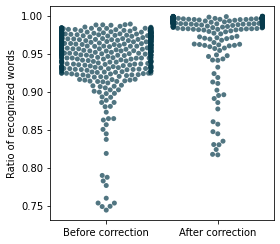

In [12]:
plt.figure(figsize=(4, 3.5))

ax = sns.swarmplot(data=to_boxplot_df, x="variable", y="value", alpha=0.7, palette=[f'#{colors[0]}'])

ax.set_ylabel("Ratio of recognized words")
ax.set_xticklabels(["Before correction", "After correction"])
ax.set_xlabel("")
plt.tight_layout()

plt.savefig("results/figures/fig_correction.pdf")

# Corpus description

In [13]:
data = []

for doc in corpus.documents:
    row = {    }
    row['Year'] = doc.get_date()
    row['Num. of Words'] = len(doc.get_bow_list())
    data.append(row)

articles_per_year_df = pd.DataFrame(data)
articles_per_year_df['Fifth'] = pd.DataFrame(data)['Year'].apply(lambda d: d.year - (d.year % 5))
articles_counts_per_5y = articles_per_year_df.groupby('Fifth')['Year'].count()
articles_avglengths_per_5y = articles_per_year_df.groupby('Fifth')['Num. of Words'].mean()

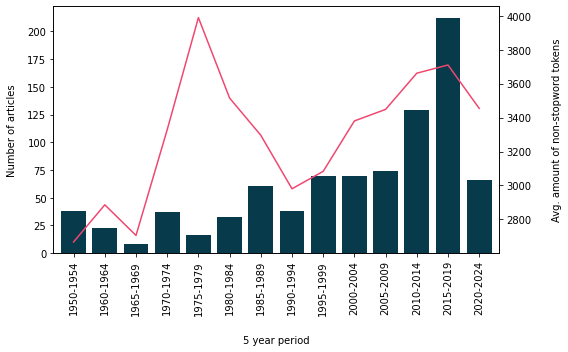

In [14]:
_, ax1 = plt.subplots(figsize=(8,5))

articles_counts_per_5y.plot.bar(ax=ax1, width=0.8, label="Num. of articles")
ax2 = ax1.twinx()
ax2.plot(articles_avglengths_per_5y.values, color=f'#{colors[5]}', label='Avg. article length')

ax1.set_ylabel("Number of articles", labelpad=10)
ax2.set_ylabel("Avg. amount of non-stopword tokens", labelpad=20)

ax1.set_xticklabels([f'{year}-{year+4}' for year in articles_avglengths_per_5y.index])
ax1.set_xlabel("5 year period", labelpad=20)

plt.tight_layout()
plt.savefig("results/figures/fig_numdocuments.pdf")

In [12]:
for main_area, topics in model.get_main_areas().items():
    print(main_area)
    print(sum(len(topic.docs) for topic in topics))

Value theory
571
History of western philosophy
222
Science, logic, and mathematics
160
Philosophical traditions
84
Metaphysics and epistemology
240
Other
231


In [13]:
tables.compute_main_area_descriptor_table("Value theory")

moral          0.021352
principio      0.019351
experiencia    0.016057
vida           0.015813
hombre         0.013888
libertad       0.013350
juicio         0.012853
humano         0.010545
acción         0.010136
razón          0.009080
Name: Value theory (averaged), dtype: float64

## Area plot counting how many documents we have per area and per year

[Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')]


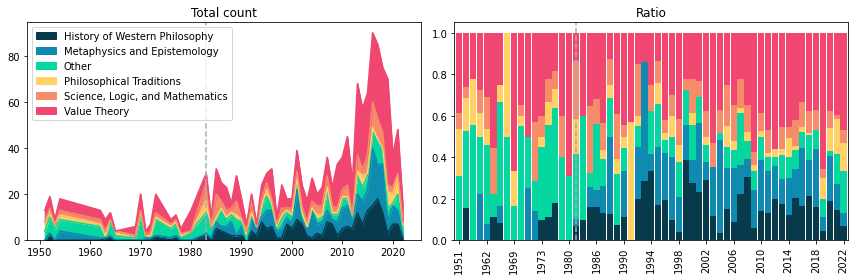

In [38]:
_, axs = plt.subplots(1, 2, figsize=(12, 4))

df =viz.plot_stream_graph(ax=axs[0])
viz.plot_stream_graph(ax=axs[1], normalized=True)

print(axs[0].get_xticklabels())
# _.suptitle('Articles in each main area per year', fontsize=16)

axs[0].set_title("Total count")

axs[1].set_xticks(axs[1].get_xticks()[::4], axs[1].get_xticklabels()[::4])

axs[1].set_title('Ratio')

# Line in 1983
axs[0].axvline(x=1983, linestyle='--', color='#aaa')
axs[1].axvline(x=17, linestyle='--', color='#aaa')

axs[0].set_xlabel('')
axs[1].set_xlabel('')

handles, _ = axs[0].get_legend_handles_labels()

axs[0].legend(
    handles=handles, 
    labels = ['History of Western Philosophy', 'Metaphysics and Epistemology', 
    'Other', 'Philosophical Traditions', 'Science, Logic, and Mathematics', 'Value Theory']
    )
axs[1].get_legend().remove()

plt.tight_layout()
plt.savefig('results/figures/fig2.pdf')

In [9]:
df = df.reset_index()

In [10]:
docs_before_1990 = len([doc for doc in corpus.documents if doc.get_year() < 1990])
docs_after_1990 = len([doc for doc in corpus.documents if doc.get_year() >= 1990])

In [11]:
before_1990 = df[df.index < 1990]

print('Total counts')
print(before_1990.sum())

print('\nRatio')
print((before_1990.sum() / docs_before_1990).round(3))

Total counts
Main area
Date                               113530.0
History of western philosophy         222.0
Metaphysics and epistemology          249.0
Other                                 231.0
Philosophical traditions               84.0
Science, logic, and mathematics       160.0
Value theory                          571.0
dtype: float64

Ratio
Main area
Date                               525.602
History of western philosophy        1.028
Metaphysics and epistemology         1.153
Other                                1.069
Philosophical traditions             0.389
Science, logic, and mathematics      0.741
Value theory                         2.644
dtype: float64


In [12]:
after_1990 = df[df.index >= 1990]
print('Total counts')
print(after_1990.sum())

print('\nRatio')
print((after_1990.sum() / docs_after_1990).round(3))

Total counts
Main area
Date                               0.0
History of western philosophy      0.0
Metaphysics and epistemology       0.0
Other                              0.0
Philosophical traditions           0.0
Science, logic, and mathematics    0.0
Value theory                       0.0
dtype: float64

Ratio
Main area
Date                               0.0
History of western philosophy      0.0
Metaphysics and epistemology       0.0
Other                              0.0
Philosophical traditions           0.0
Science, logic, and mathematics    0.0
Value theory                       0.0
dtype: float64


In [13]:
(before_1990.sum() / docs_before_1990) < (after_1990.sum() / docs_after_1990)

Main area
Date                               False
History of western philosophy      False
Metaphysics and epistemology       False
Other                              False
Philosophical traditions           False
Science, logic, and mathematics    False
Value theory                       False
dtype: bool

In [14]:
total_before_1990 = len([doc for doc in corpus.documents if doc.get_year() < 1990])
print(f"Total docs before 1990: {total_before_1990}")
total_after_1990 = len([doc for doc in corpus.documents if doc.get_year() >= 1990])
print(f"Total docs after 1990: {total_after_1990}")

Total docs before 1990: 216
Total docs after 1990: 659


In [15]:
for main_area in model.get_main_areas():
    print(main_area)
    before_1990 = 0
    after_1990 = 0
    for topic in model.get_main_areas()[main_area]:
        for doc, _ in topic.docs:
            if doc.get_year() < 1990:
                before_1990 += 1
            else:
                after_1990 += 1
        
    print(f"Before 1990: {before_1990} (Ratio = {before_1990 / float(total_before_1990):.2f})")
    print(f"After 1990: {after_1990} (Ratio = {after_1990 / float(total_after_1990):.2f})")
    print("---")


Value theory
Before 1990: 118 (Ratio = 0.55)
After 1990: 453 (Ratio = 0.69)
---
History of western philosophy
Before 1990: 29 (Ratio = 0.13)
After 1990: 193 (Ratio = 0.29)
---
Science, logic, and mathematics
Before 1990: 48 (Ratio = 0.22)
After 1990: 112 (Ratio = 0.17)
---
Philosophical traditions
Before 1990: 28 (Ratio = 0.13)
After 1990: 56 (Ratio = 0.08)
---
Metaphysics and epistemology
Before 1990: 22 (Ratio = 0.10)
After 1990: 218 (Ratio = 0.33)
---
Other
Before 1990: 108 (Ratio = 0.50)
After 1990: 123 (Ratio = 0.19)
---


In [16]:
rows = {}
for main_area in model.get_main_areas():
    print(f"{main_area} & {', '.join(tables.compute_main_area_descriptor_table(main_area).index.to_list())} \\\\")

Value theory & moral, principio, experiencia, vida, hombre, libertad, juicio, humano, acción, razón \\
History of western philosophy & rorty, fichte, infinito, hegel, spinoza, pensar, kant, husserl, objeto, pensamiento \\
Science, logic, and mathematics & priori, ciencia, proposición, lógico, conocimiento, cassirer, teoría, sistema, científico, geometría \\
Philosophical traditions & educación, analogía, analítico, sujeto, analógico, pedagógico, beuchot, aprendizaje, formación, educativo \\
Metaphysics and epistemology & cuerpo, mundo, oración, dios, argumento, significado, justificación, escepticismo, escéptico, religioso \\
Other & filosofía, mill, socrates, mundo, forma, plato, singer, self, relación, palabra \\


# Subareas

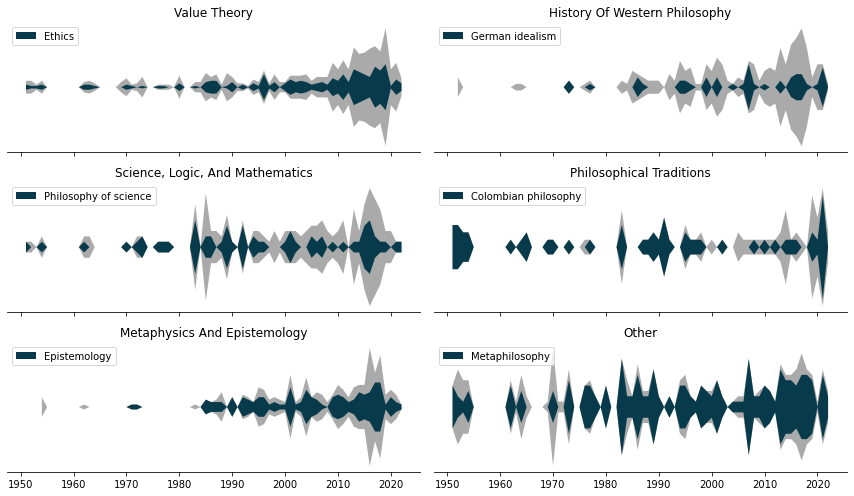

In [11]:
_, axs = plt.subplots(3, 2, figsize=(12, 7), sharex=True)
for area, ax in zip(model.get_main_areas().keys(), axs.flatten()):
    viz.plot_streamgraph_main_and_subarea(area, ax=ax)
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(ax.get_title().title())
    ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig('results/figures/fig_subareas.pdf')

In [68]:
from utils.word_cleanup import clean_word

topics_in_main_area = model.get_main_areas()["Value theory"]
word_probability_matrices = [topic.word_probabilities for topic in topics_in_main_area if "Ethics" in topic.areas]

# This is of shape [num_topics_in_main_area, num_words, num_slices]
concatenated_wpm = np.concatenate(
            [wpm.reshape(1, *wpm.shape) for wpm in word_probability_matrices], axis=0
        )

vocabulary = [clean_word(model.id2word[idx]) for idx in range(len(model.id2word))]

descriptor = pd.DataFrame(
            concatenated_wpm.mean(axis=0),
            index=vocabulary,
            columns=model.corpus.time_slice_years,
        )

descriptor.mean(axis=1).sort_values(ascending=False)[:10]

principio     0.056924
vida          0.040086
capacidad     0.023332
enfoque       0.022333
razón         0.017825
discurso      0.017427
idea          0.014858
teoría        0.014150
ética         0.012938
desarrollo    0.012715
dtype: float64

In [69]:
data = []
for main_area, topics in model.get_main_areas().items():
    # Get biggest subarea in the main area

    total_doc_count_in_main_area = model.count_docs_per_main_area(main_area)
    largest_subareas = sorted(
                total_doc_count_in_main_area.items(), key=lambda d: d[1], reverse=True
            )[:5]
    for subarea, num_docs_in_subarea in largest_subareas:
        word_probability_matrices = [
            topic.word_probabilities for topic in topics if subarea in topic.areas]

        # This is of shape [num_topics_in_main_area, num_words, num_slices]
        concatenated_wpm = np.concatenate(
                    [wpm.reshape(1, *wpm.shape) for wpm in word_probability_matrices], axis=0
                )

        vocabulary = [clean_word(model.id2word[idx]) for idx in range(len(model.id2word))]

        descriptor = pd.DataFrame(
                    concatenated_wpm.mean(axis=0),
                    index=vocabulary,
                    columns=model.corpus.time_slice_years,
                )

        subarea_words = descriptor.mean(axis=1).sort_values(ascending=False)[:10].index.to_list()
            
        data.append({'Main area': main_area, 'Subarea': subarea, 'Items': num_docs_in_subarea, 'Main Words': '; '.join(subarea_words)})

In [72]:
df = pd.DataFrame(data)
df = df.set_index(['Main area', 'Subarea'])
with pd.option_context("max_colwidth", 1000):
    print(df)

                                                                 Items  \
Main area                       Subarea                                  
Value theory                    Ethics                             221   
                                Political theory                   110   
                                Social and political philosophy     72   
                                Kant                                68   
                                Theories of justice                 59   
History of western philosophy   German idealism                     50   
                                Hegel                               48   
                                Kant                                47   
                                Phenomenology                       46   
                                Epistemology                        33   
Science, logic, and mathematics Philosophy of science               62   
                                Philos

In [22]:
df

Items  \
Main area                       Subarea                                  
Value theory                    Ethics                             221   
                                Political theory                   110   
                                Social and political philosophy     72   
                                Kant                                68   
                                Theories of justice                 59   
History of western philosophy   German idealism                     50   
                                Hegel                               48   
                                Kant                                47   
                                Phenomenology                       46   
                                Epistemology                        33   
Science, logic, and mathematics Philosophy of science               62   
                                Philosophy of language              33   
                                Logic                               32   
                                Philosophy of physical science      22   
                                Truth                               22   
Philosophical traditions        Colombian philosophy                53   
                                Philosophy of language              24   
                                Derrida                             24   
                                Ricoeur                             24   
                                Latin american philosophy            7   
Metaphysics and epistemology    Epistemology                       126   
                                Relativism                         102   
                                Philosophy of religion              37   
                                Realism                             27   
                                Theology                            23   
Other                           Metaphilosophy                     170   
                                Phenomenology                      170   
                                Literary pieces                     57   
                                English                              4   

                                                                                                        Main Words  
Main area                       Subarea                                                                             
Value theory                    Ethics                           principio; vida; capacidad; enfoque; razón; di...  
                                Political theory                 principio; capacidad; enfoque; idea; desarroll...  
                                Social and political philosophy  político; política; modelo; social; resultado;...  
                                Kant                             libertad; juicio; voluntad; libre; hume; bello...  
                                Theories of justice              principio; idea; teoría; noción; bien; origina...  
History of western philosophy   German idealism                  fichte; hegel; pensar; pensamiento; lógica; co...  
                                Hegel                            hegel; pensar; pensamiento; lógica; conciencia...  
                                Kant                             kant; razón; kantiano; crítica; conocimiento; ...  
                                Phenomenology                    husserl; objeto; heidegger; ente; mundo; propi...  
                                Epistemology                     kant; concepto; objeto; trascendental; intuici...  
Science, logic, and mathematics Philosophy of science            priori; ciencia; conocimiento; cassirer; cient...  
                                Philosophy of language           proposición; lógico; lenguaje; sujeto; predica...  
                                Logic                            proposición; lógico; sujeto; lógica; predicado...  
               

# Historical topics

Some topics relate more strongly to historical themes and interpretation of an author's work than others. We want to compare these "historical" topics against the rest of the corpus.

In [12]:
import datetime as dt

historical_topics = []
for topic in model.topics:
    if not topic.tags:
        continue
    if '#author' in topic.tags or '#historical' in topic.tags:
        historical_topics.append(topic)

In [13]:
print(f"Number of historical topics: {len(historical_topics)}")
print(f"Ratio to total topics: {len(historical_topics)/model.num_topics:.4f}")

Number of historical topics: 25
Ratio to total topics: 0.2778


In [14]:
historical_docs_ids = set()
for topic in historical_topics:
    historical_docs_ids.update([doc.id for doc, _ in topic.docs])

historical_docs = [corpus.get_article_by_id(doc_id) for doc_id in historical_docs_ids]

In [15]:
historical_docs_by_date = pd.Series([doc.get_date() for doc in historical_docs])
historical_docs_by_date = historical_docs_by_date.value_counts().resample('Y').sum()

In [16]:
all_docs_by_date = pd.Series([doc.get_date() for doc in corpus.documents])
all_docs_by_date = all_docs_by_date.value_counts().resample('Y').sum()

In [17]:
yearly_ratios = (historical_docs_by_date / all_docs_by_date)
yearly_ratios = yearly_ratios.loc[dt.date(year=1983,month=1,day=1):]
# We start in 1983 because we don't have continuous data before

In [18]:
from scipy.stats import linregress

slope, intercept, rvalue, pvalue, stderr = linregress(
    x=yearly_ratios.index.year, 
    y=yearly_ratios.values,
    alternative="less")

print(f"Slope: {slope:.4f}")
print(f"Pearson correlation coefficient: {rvalue:.2f}")
print(f"R2: {rvalue**2:.4f}")
print(f"df: {len(yearly_ratios) - 2}")
print(f"p-value: {pvalue:.4f}")

print(f"{intercept=}")      

Slope: 0.0020
Pearson correlation coefficient: 0.20
R2: 0.0388
df: 38
p-value: 0.8885
intercept=-3.648826716800687


In [19]:
print(f"y = {intercept} + {slope}x")

y = -3.648826716800687 + 0.002008981227875686x


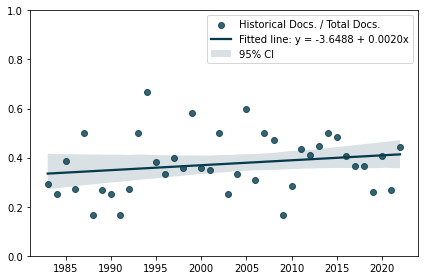

In [28]:
_, ax = plt.subplots(figsize=(6, 4))

p = sns.regplot(x=yearly_ratios.index.year, y=yearly_ratios.values, ax=ax, color='#073b4c')
ax.set_ylim(0, 1)

ax.legend(["Historical Docs. / Total Docs.", f"Fitted line: y = {intercept:.4f} + {slope:.4f}x", "95% CI"])

plt.tight_layout()
plt.savefig('results/figures/fig_historical_corr.pdf')

In [33]:
data = []

for topic in historical_topics:
    row = {
        'Main area': topic.main_area,
        'Subareas': '; '.join([tag.title() for tag in topic.tags[1:] if '#' not in tag]),
        'Words': '; '.join(topic.top_words()),
        'Num. of docs': len(topic.docs) 
        }
    data.append(row)

historical_topics_df = pd.DataFrame(data)
historical_topics_df = historical_topics_df.sort_values(['Main area', 'Num. of docs'], 
    ascending=[True, False])
historical_topics_df = historical_topics_df.set_index(['Main area', 'Subareas', 'Words'])
print(historical_topics_df[historical_topics_df['Num. of docs'] > 5].to_latex())

\begin{tabular}{lllr}
\toprule
             &                                     &                                                                                &  Num. of docs \\
Main area & Subareas & Words &               \\
\midrule
History of western philosophy & Kant; Epistemology & kant; concepto; objeto; trascendental; intuición; conocimiento; unidad; representación; puro; espacio &            33 \\
             & German Idealism; Hegel & pensar; pensamiento; lógica; negación; movimiento; contenido; hegel; lógico; puro; singular &            32 \\
             & Phenomenology; Husserl & objeto; propiedad; referencia; relación; percepción; descripción; nombre; acto; intencional; causal &            18 \\
             & Greek Philosophy; Aristotle & aristóteles; movimiento; naturaleza; aristotélico; alma; forma; platón; natural; esclavo; pasaje &            17 \\
             & Phenomenology; Heidegger & heidegger; ente; mundo; cosa; ontológico; heideggeriano; relación; interpr

In [34]:
historical_topics_df = (historical_topics_df
    .sort_values('Num. of docs', ascending=False)
    .groupby('Main area')
    .head(5)
    .sort_values('Main area')
    .set_index(['Main area', 'Subareas']))

KeyError: "None of ['Main area', 'Subareas'] are in the columns"

In [ ]:
with pd.option_context("max_colwidth", 1000):
    print (historical_topics_df.to_latex())

\begin{tabular}{lllr}
\toprule
             &                                 &                                                                                                      Words &  Num. of docs \\
Main area & Subareas &                                                                                                            &               \\
\midrule
History of western philosophy & Kant; Epistemology &      kant; concepto; objeto; trascendental; intuición; conocimiento; unidad; representación; puro; espacio &            33 \\
             & German Idealism; Hegel &                pensar; pensamiento; lógica; negación; movimiento; contenido; hegel; lógico; puro; singular &            32 \\
             & Phenomenology; Husserl &        objeto; propiedad; referencia; relación; percepción; descripción; nombre; acto; intencional; causal &            18 \\
             & Phenomenology; Heidegger &         heidegger; ente; mundo; cosa; ontológico; heideggeriano; relación; interpre

# Exploring specific topics

In [33]:
model.topics[5].top_word_evolution_table()

(1950, 1960) (1960, 1970) (1970, 1980) (1980, 1990) (1990, 2000)  \
0         kant         kant         kant         kant         kant   
1        razón        razón        razón        razón        razón   
2     kantiano     kantiano     kantiano     kantiano     kantiano   
3  ilustración  ilustración  ilustración  ilustración  ilustración   
4       biblia       biblia       biblia       biblia     práctico   
5     práctico     práctico     práctico     práctico      crítica   
6      crítica      crítica      crítica      crítica   naturaleza   
7   naturaleza   naturaleza   naturaleza   naturaleza       biblia   
8       hombre       hombre       hombre    prejuicio    prejuicio   
9    prejuicio    prejuicio    prejuicio       hombre       hombre   

  (2000, 2010) (2010, 2020) (2020, 2030)  
0         kant         kant         kant  
1        razón        razón        razón  
2     kantiano     kantiano     kantiano  
3  ilustración  ilustración  ilustración  
4      crítica    prejuicio    prejuicio  
5     práctico      crítica      crítica  
6    prejuicio     práctico     práctico  
7   naturaleza   naturaleza   naturaleza  
8       hombre         viii       hombre  
9         viii       hombre         viii

In [34]:
import matplotlib as mpl
# 10 color cycle'
colors = ["#8eac65","#f4b393","#140152","#22007c","#0d00a4", '#321325', '#fcdc4d', '#e01a4f', '#53b3cb', '#a3e7fc']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) 

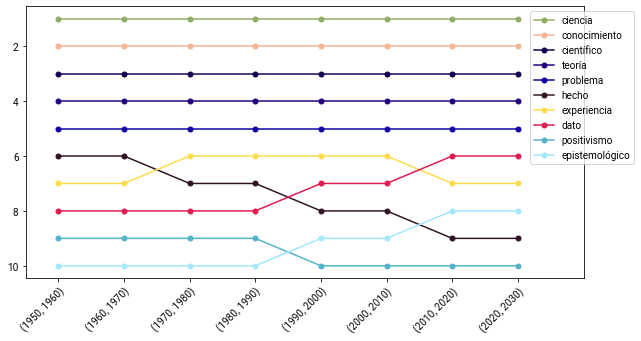

In [35]:
viz.plot_word_evolution_by_topic_graph(56) # This one is interesting

We save the topic plots to files in the results directory.

In [41]:
from pathlib import Path

TOPIC_PLOTS_FOLDER = Path().resolve() / "results" / "topic_plots"

TOPIC_PLOTS_FOLDER.mkdir(exist_ok=True)

/tmp/ipykernel_308699/1772100446.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=144)


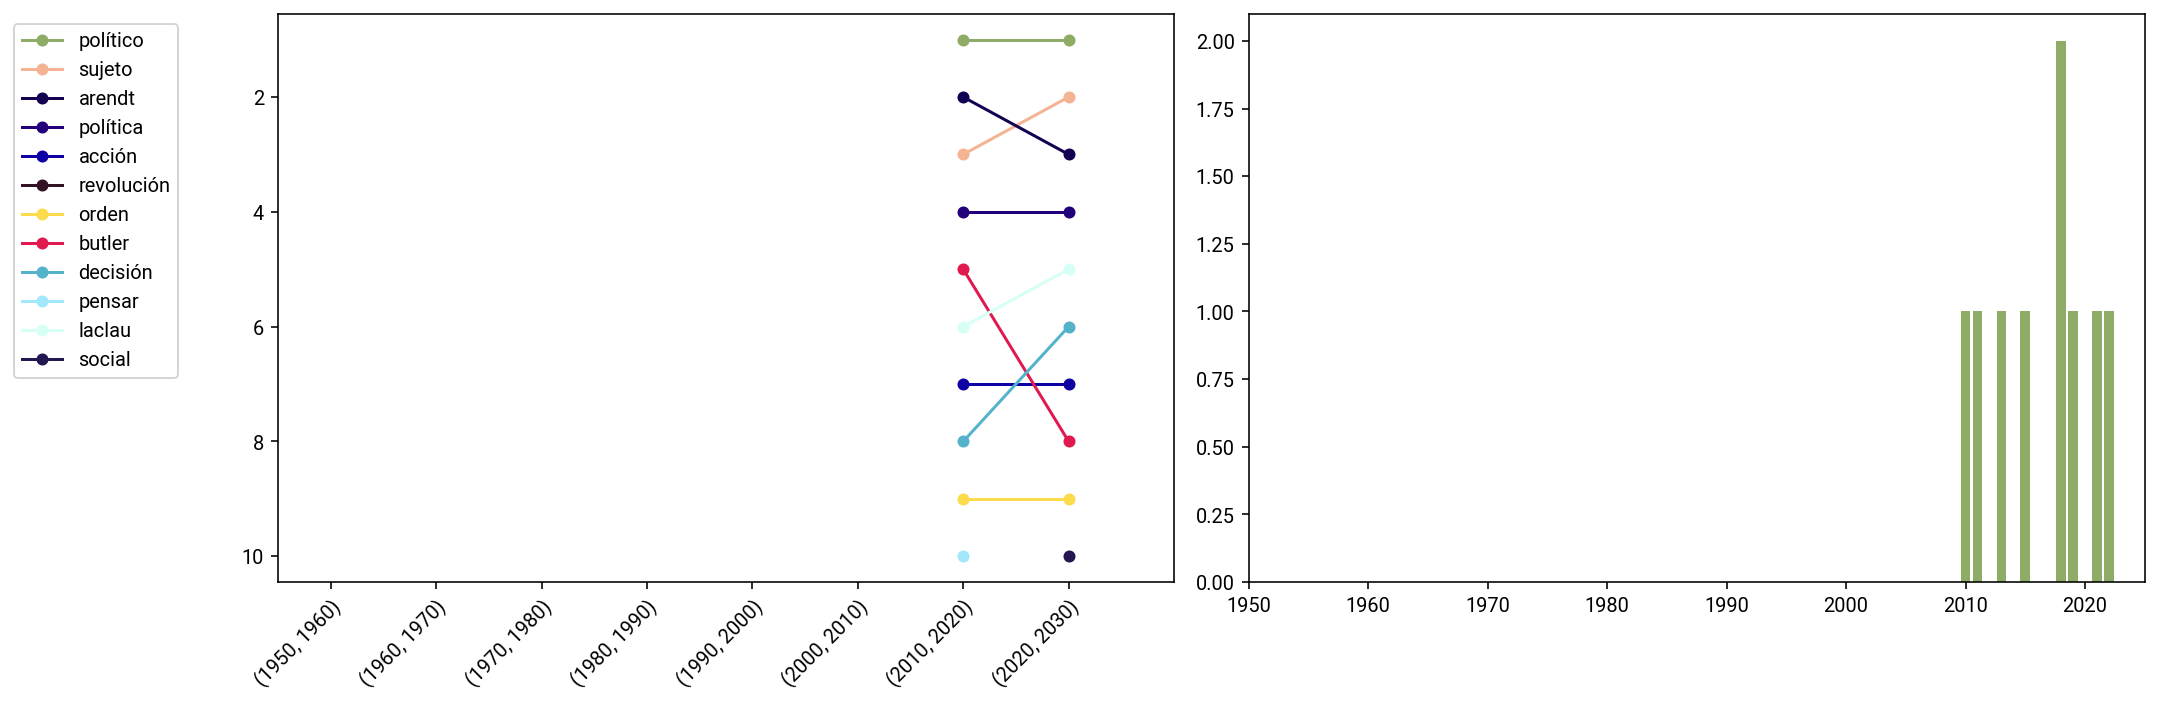

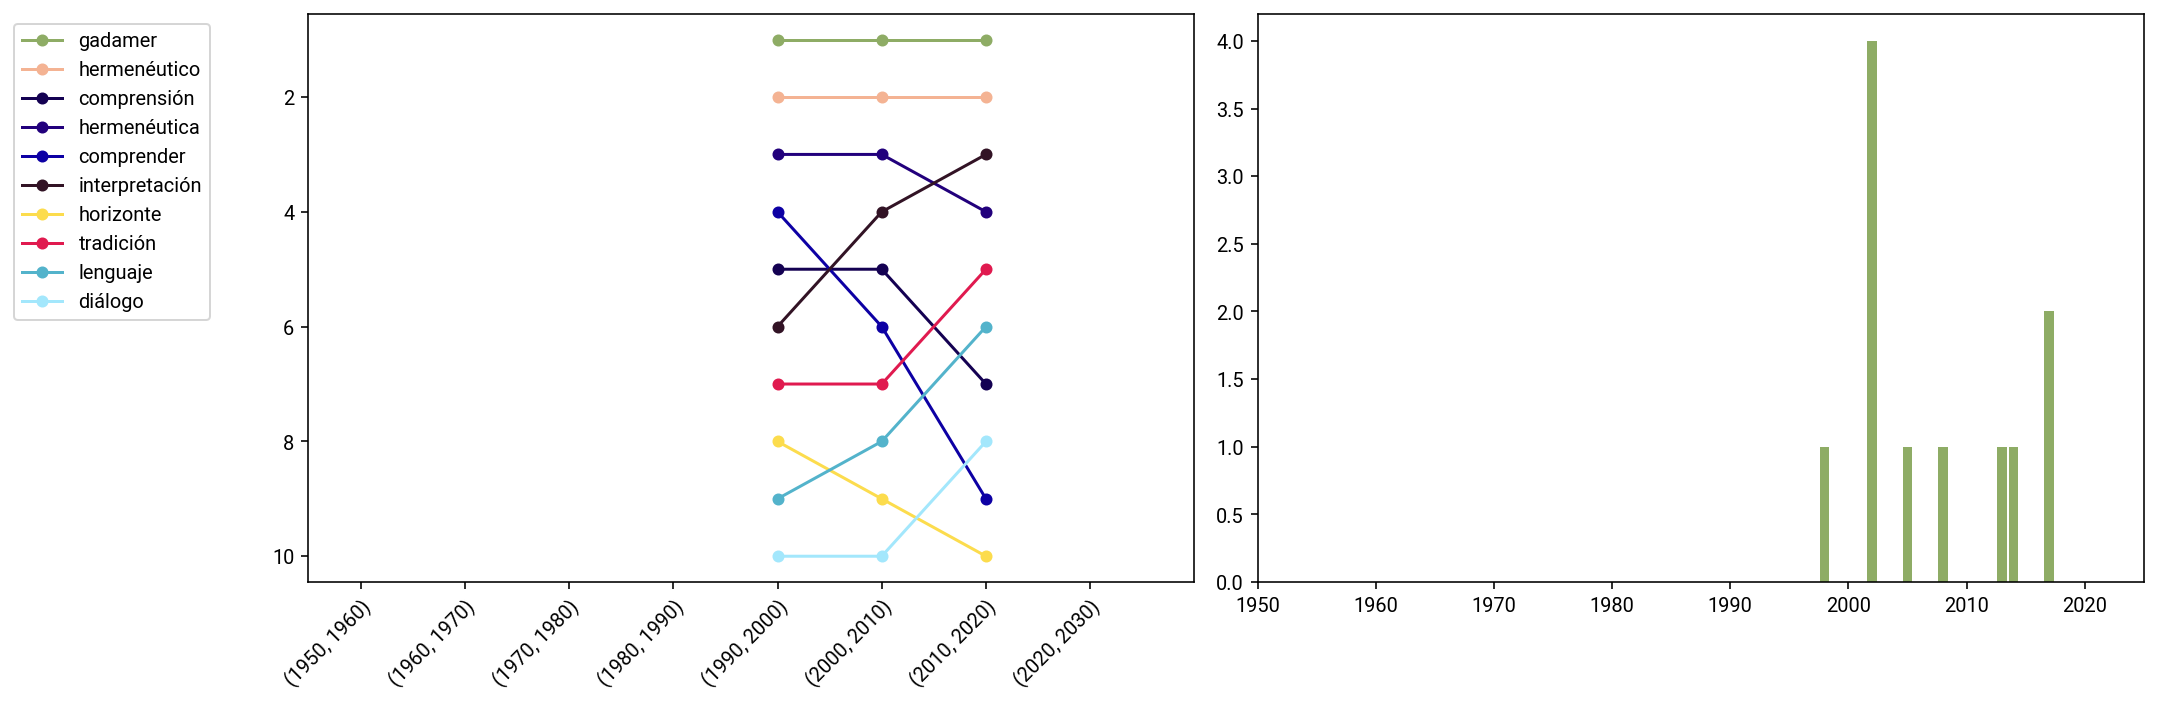

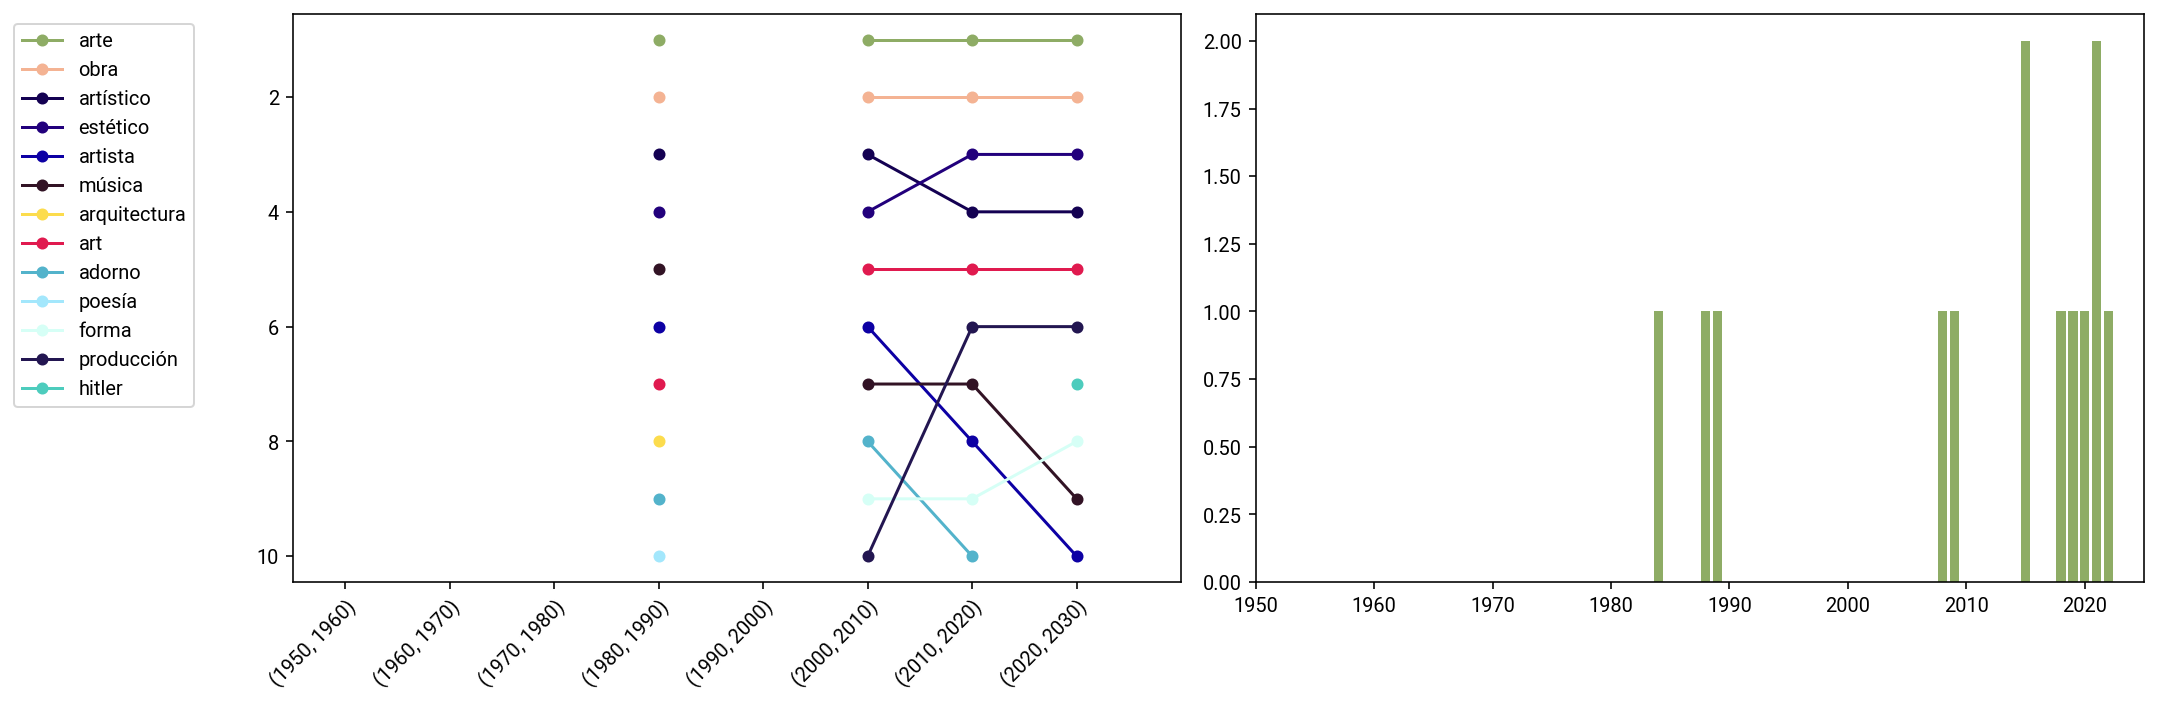

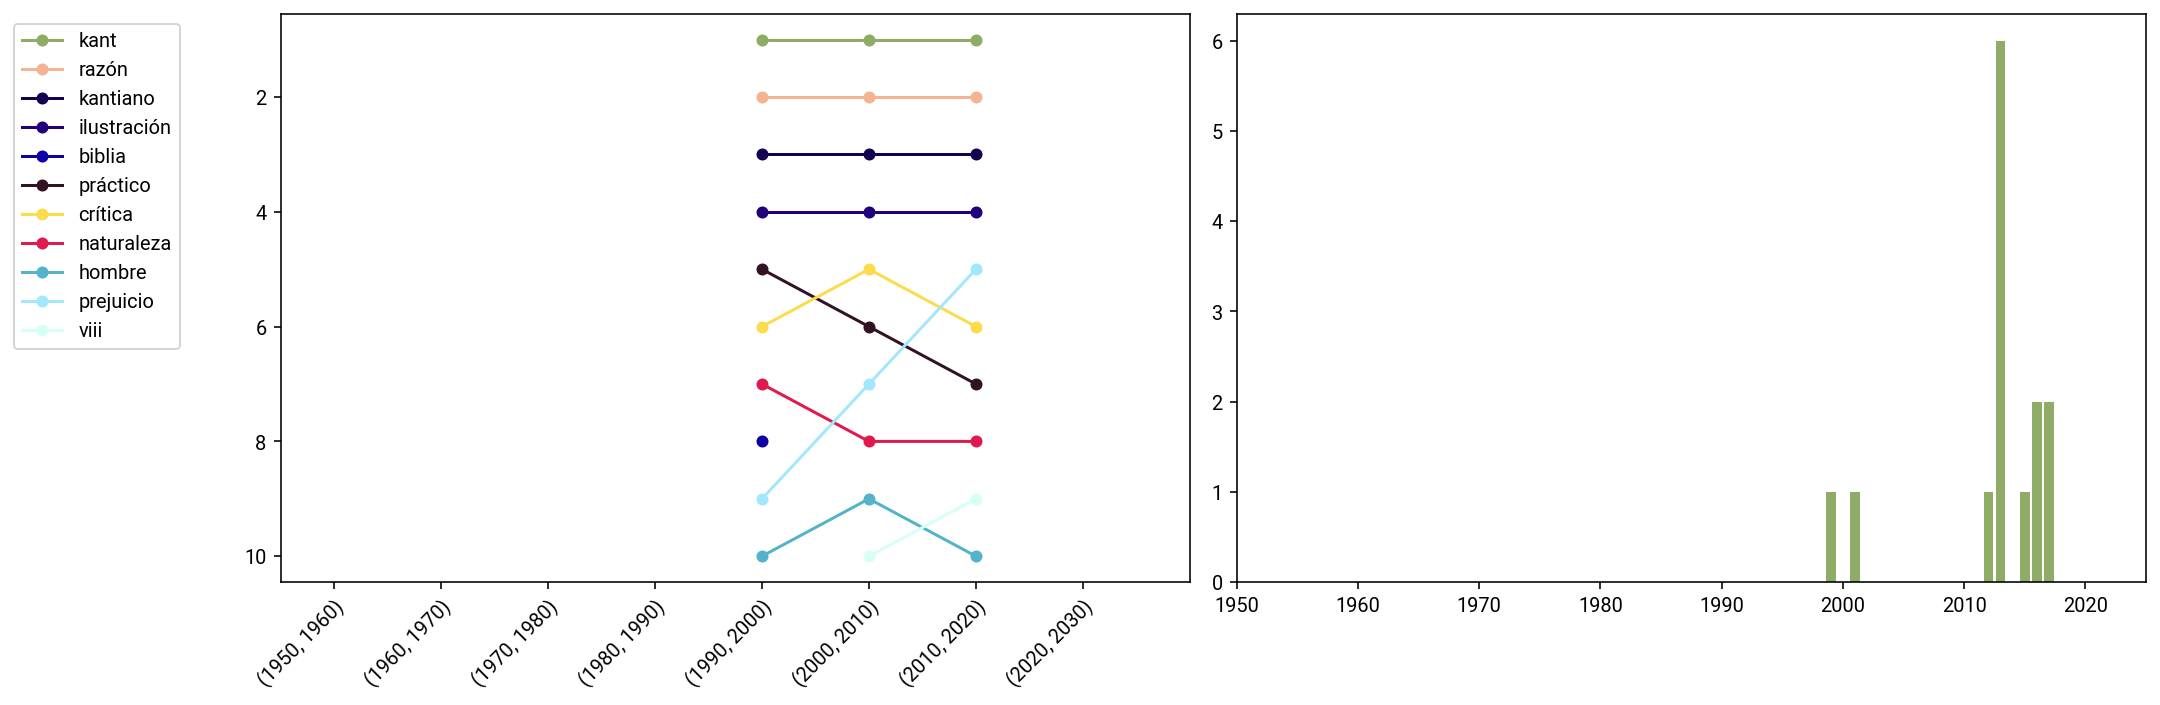

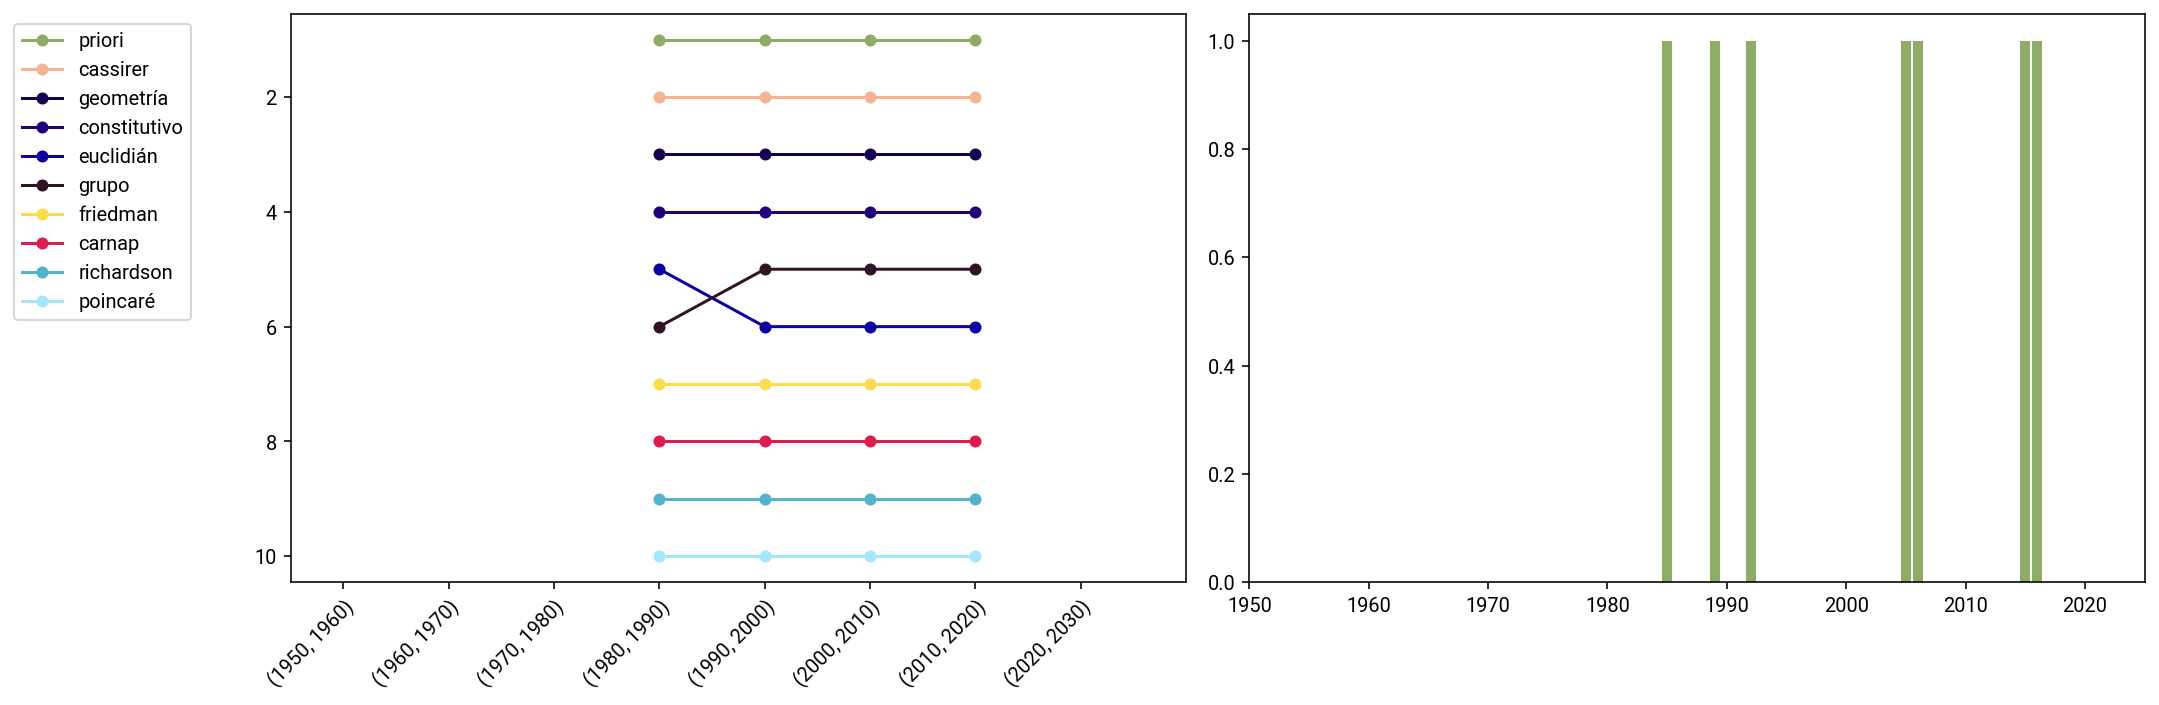

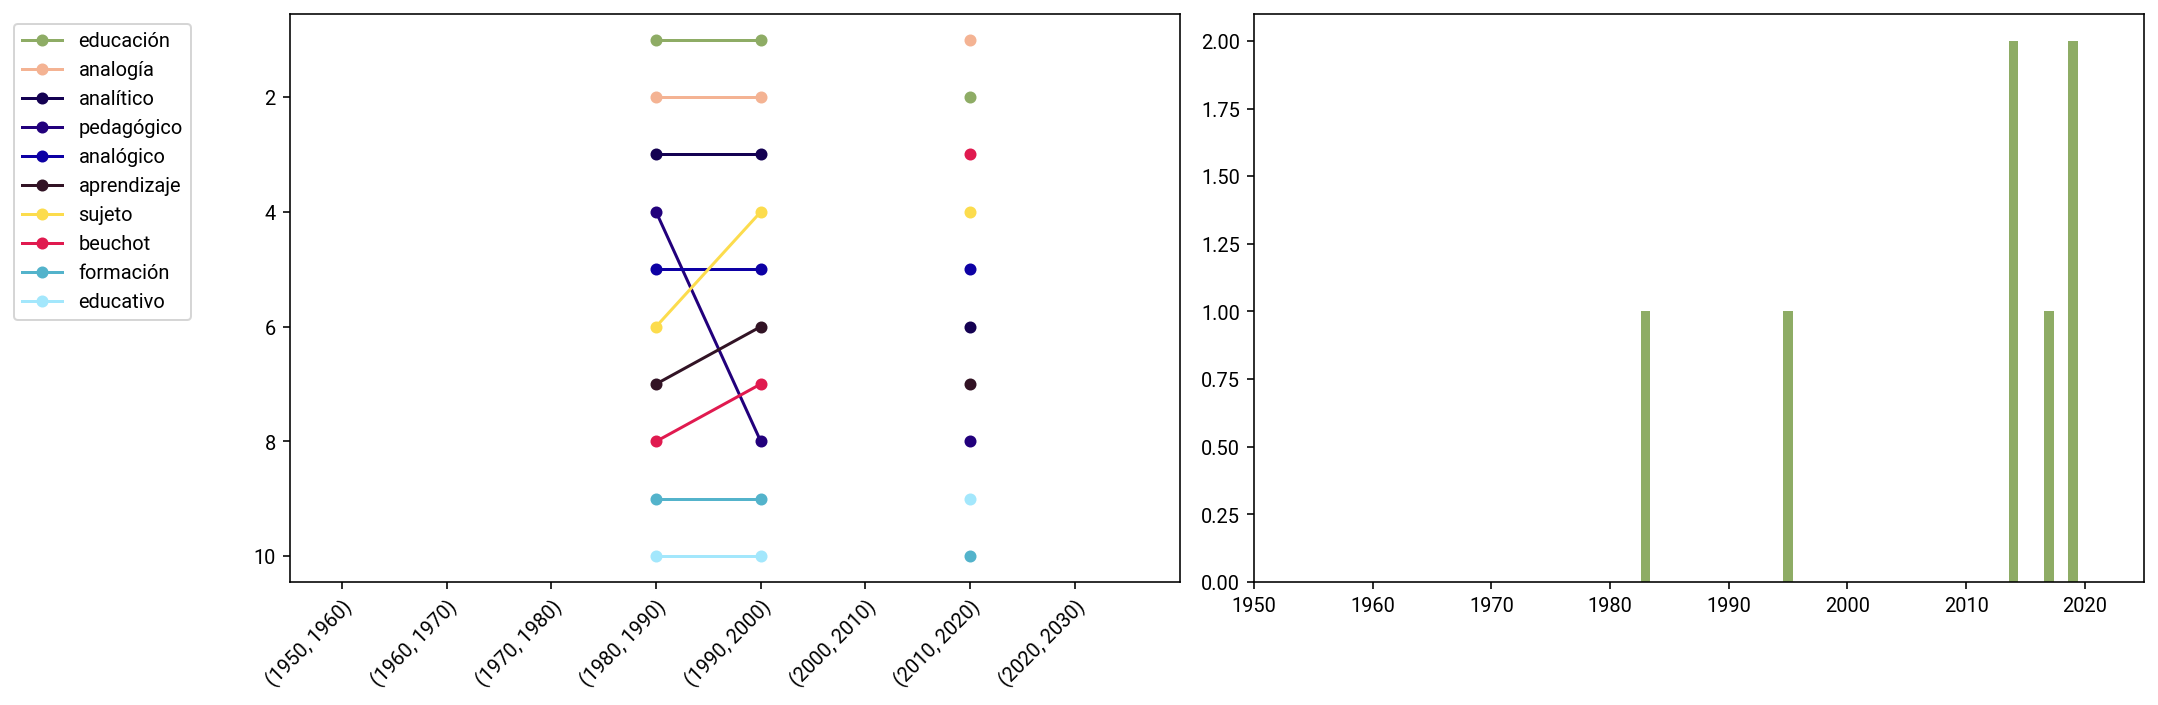

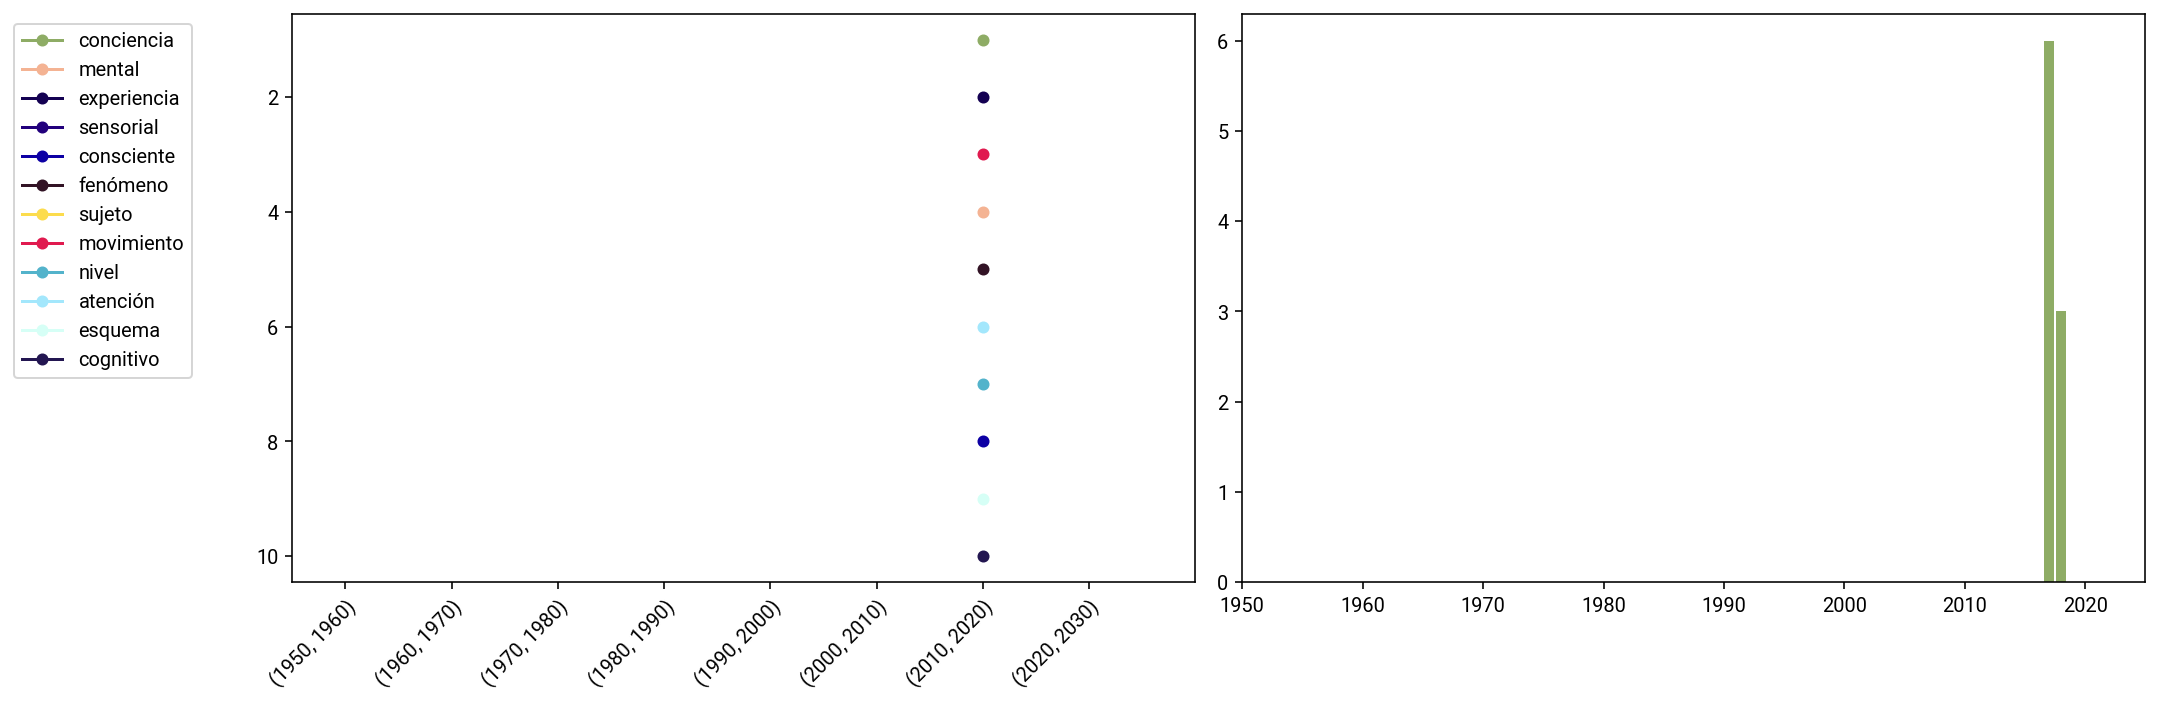

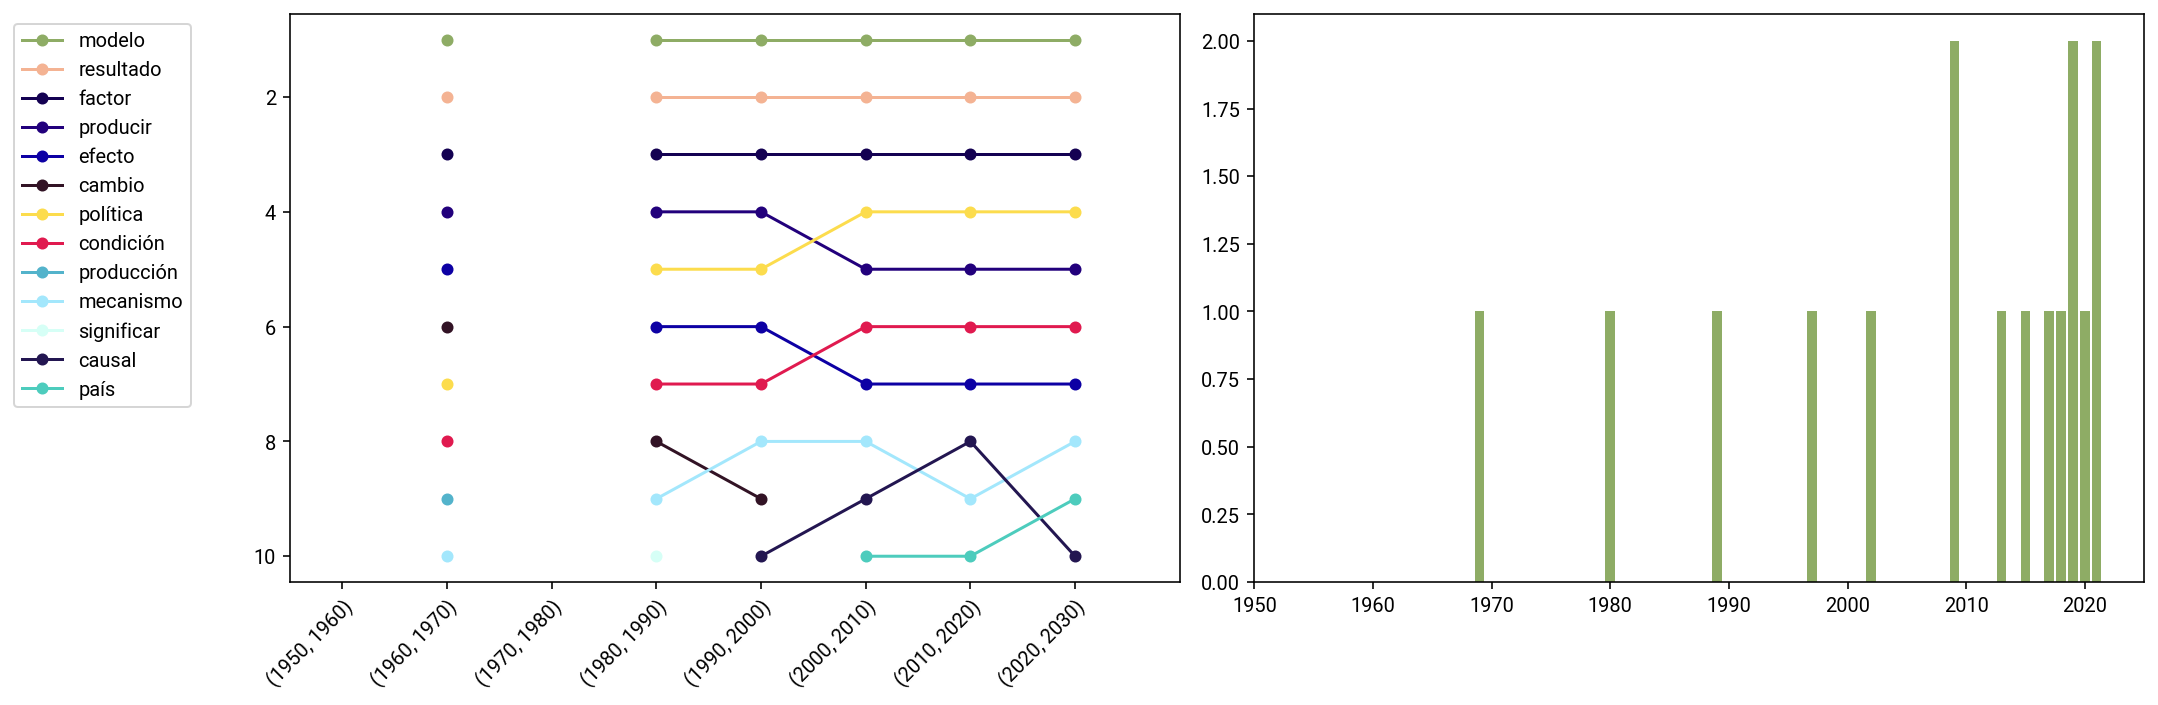

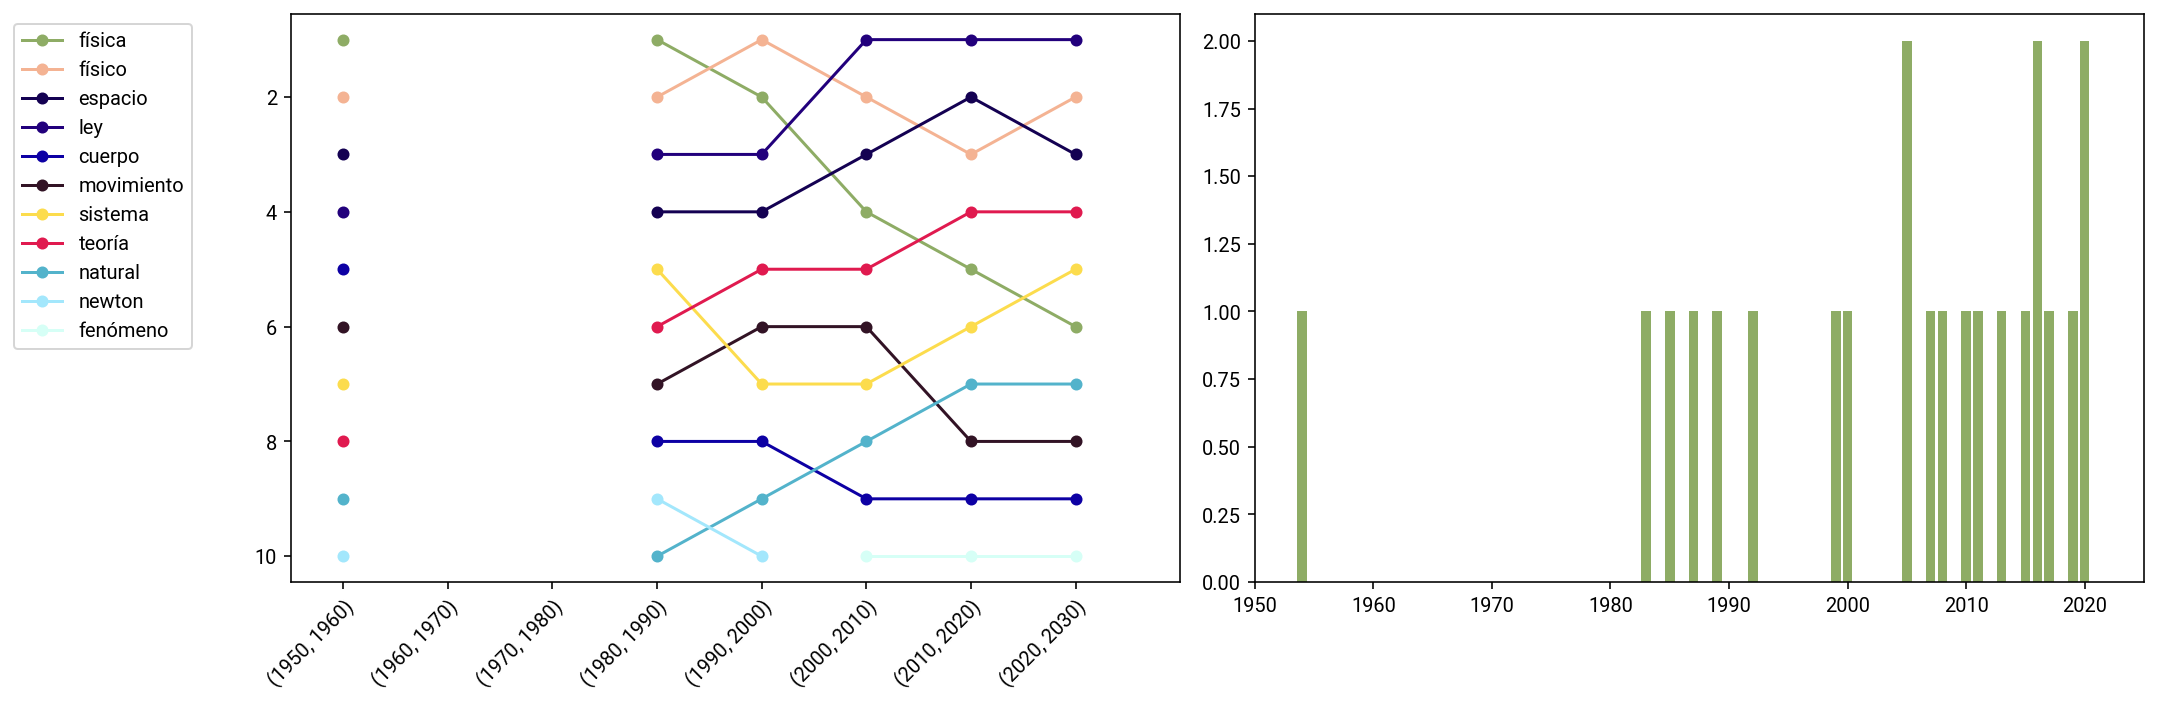

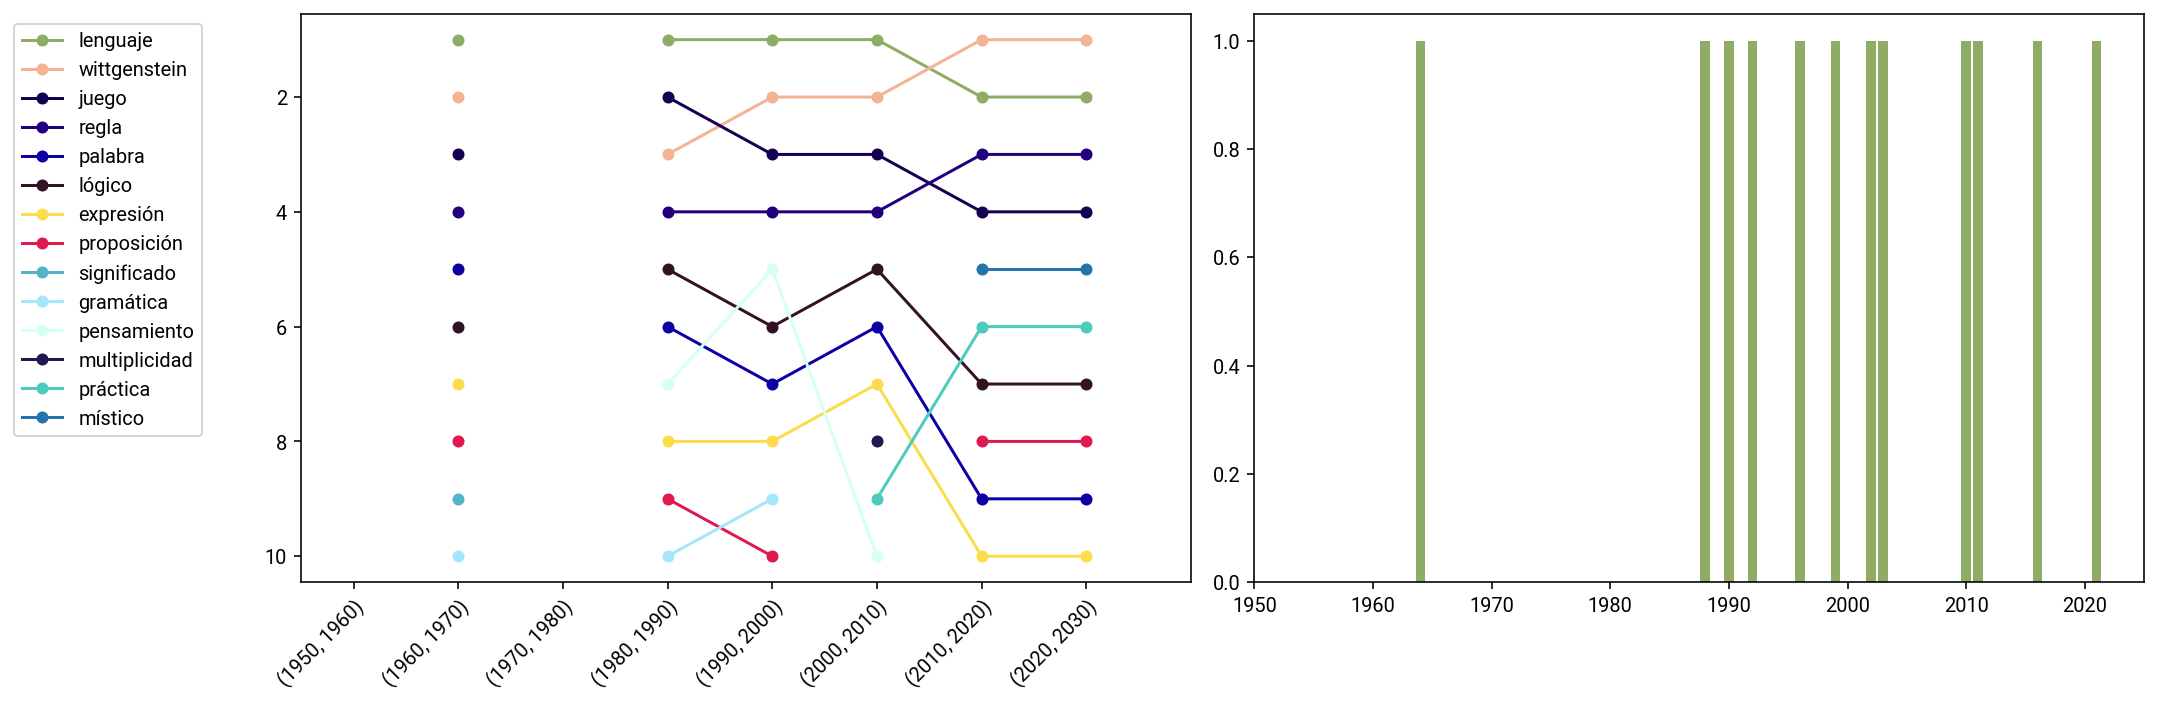

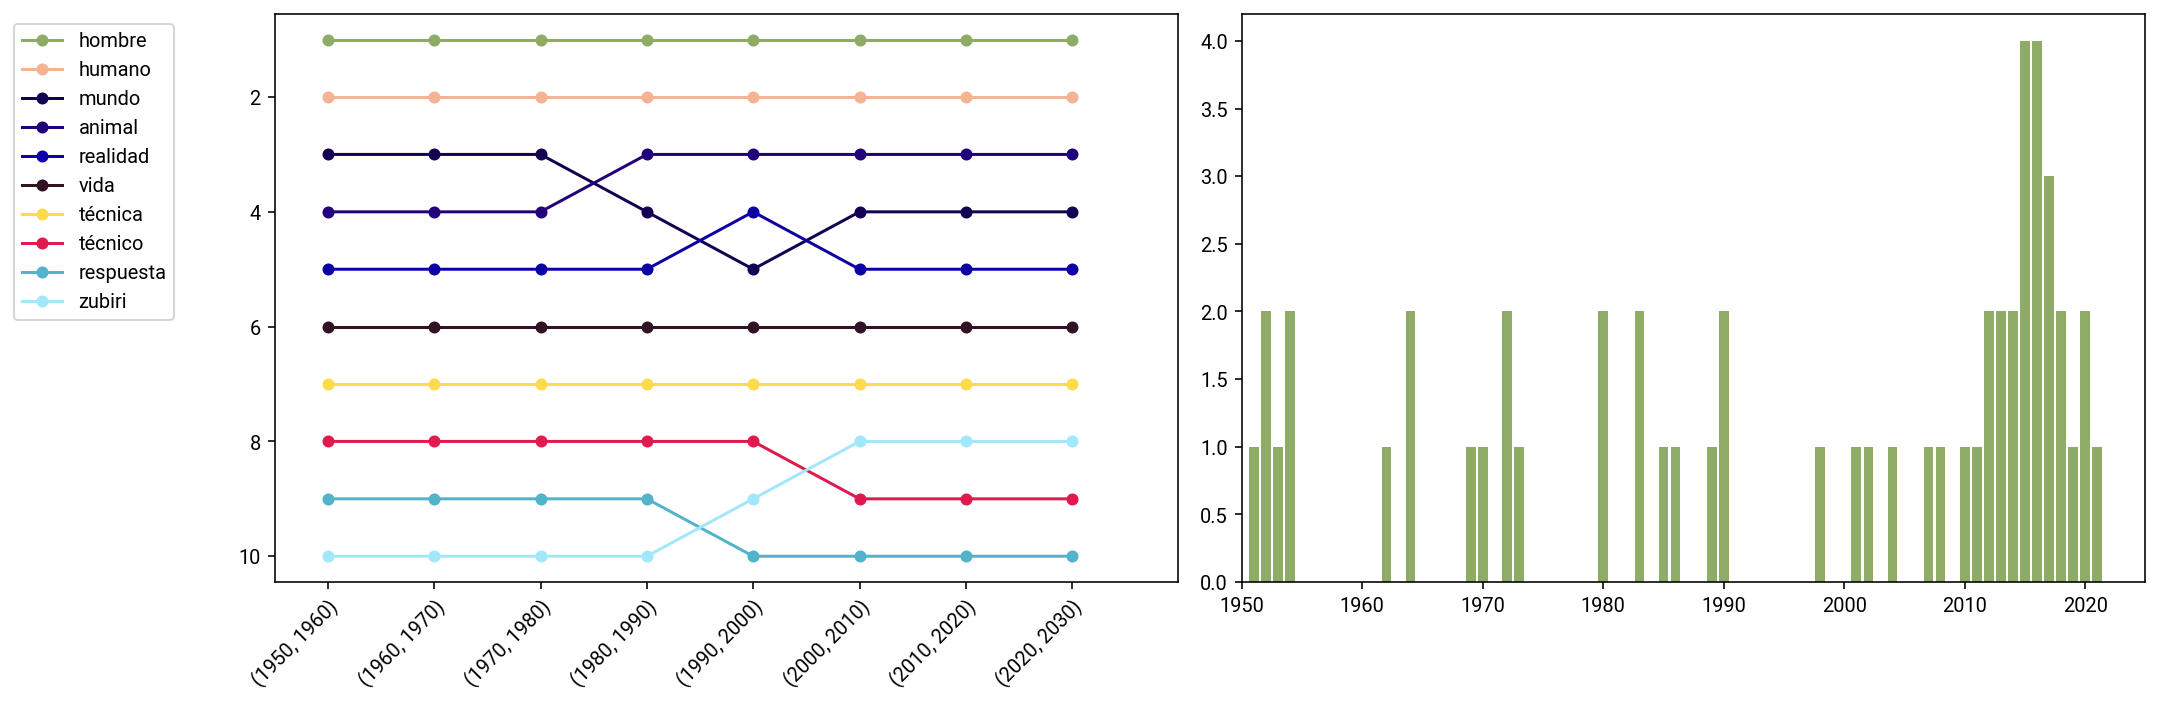

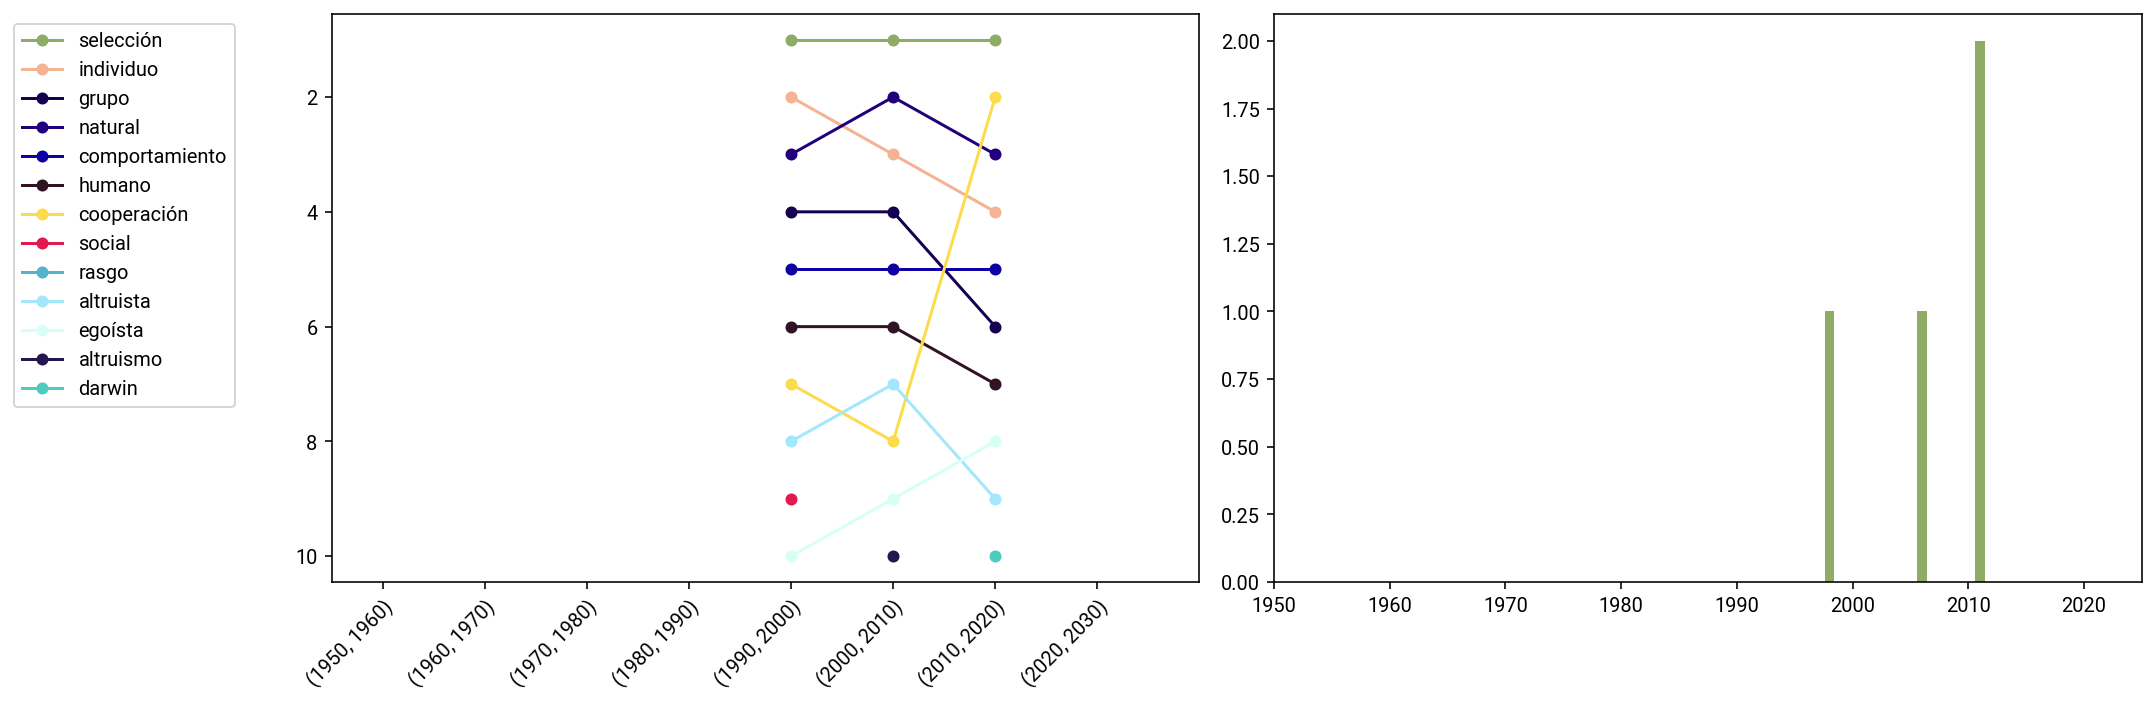

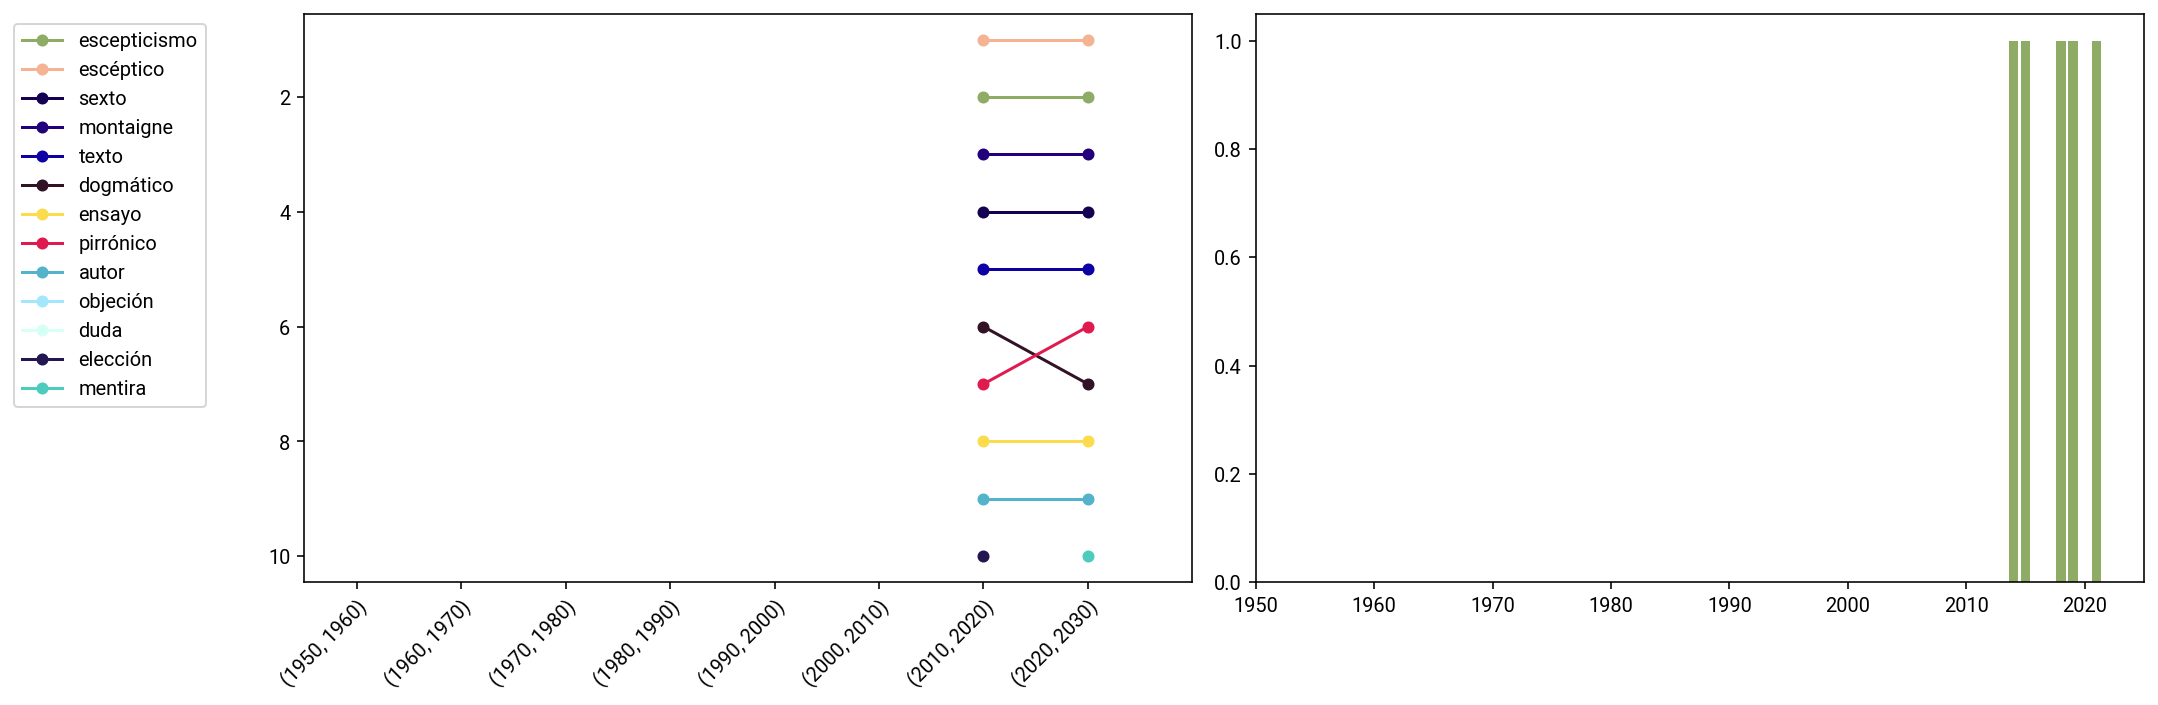

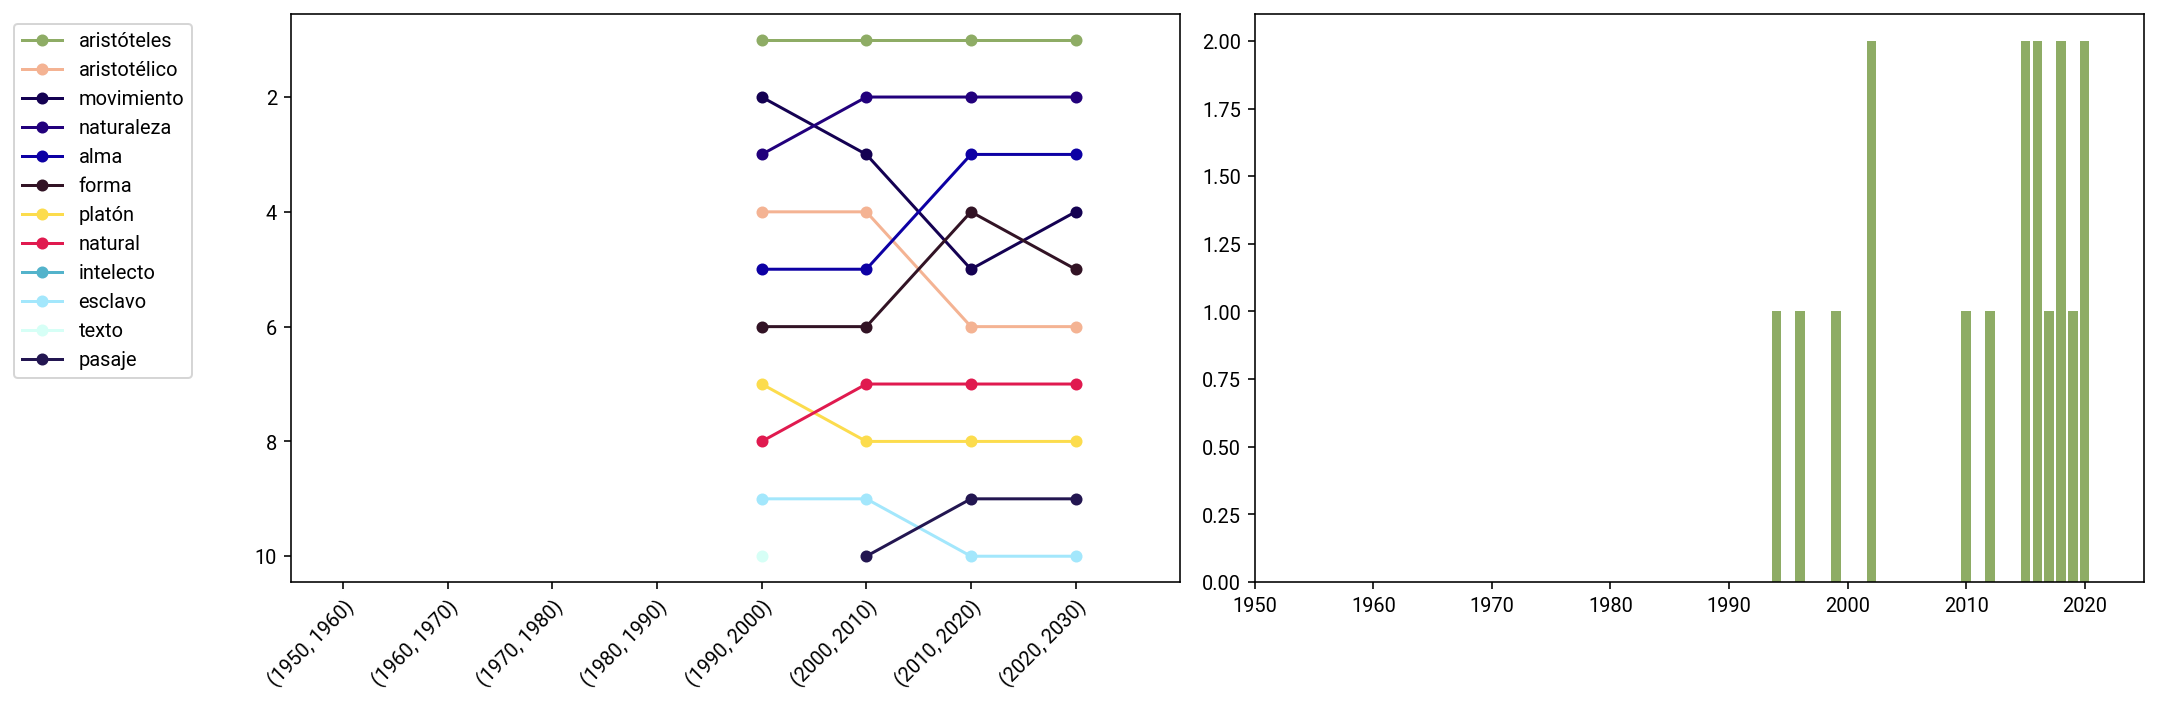

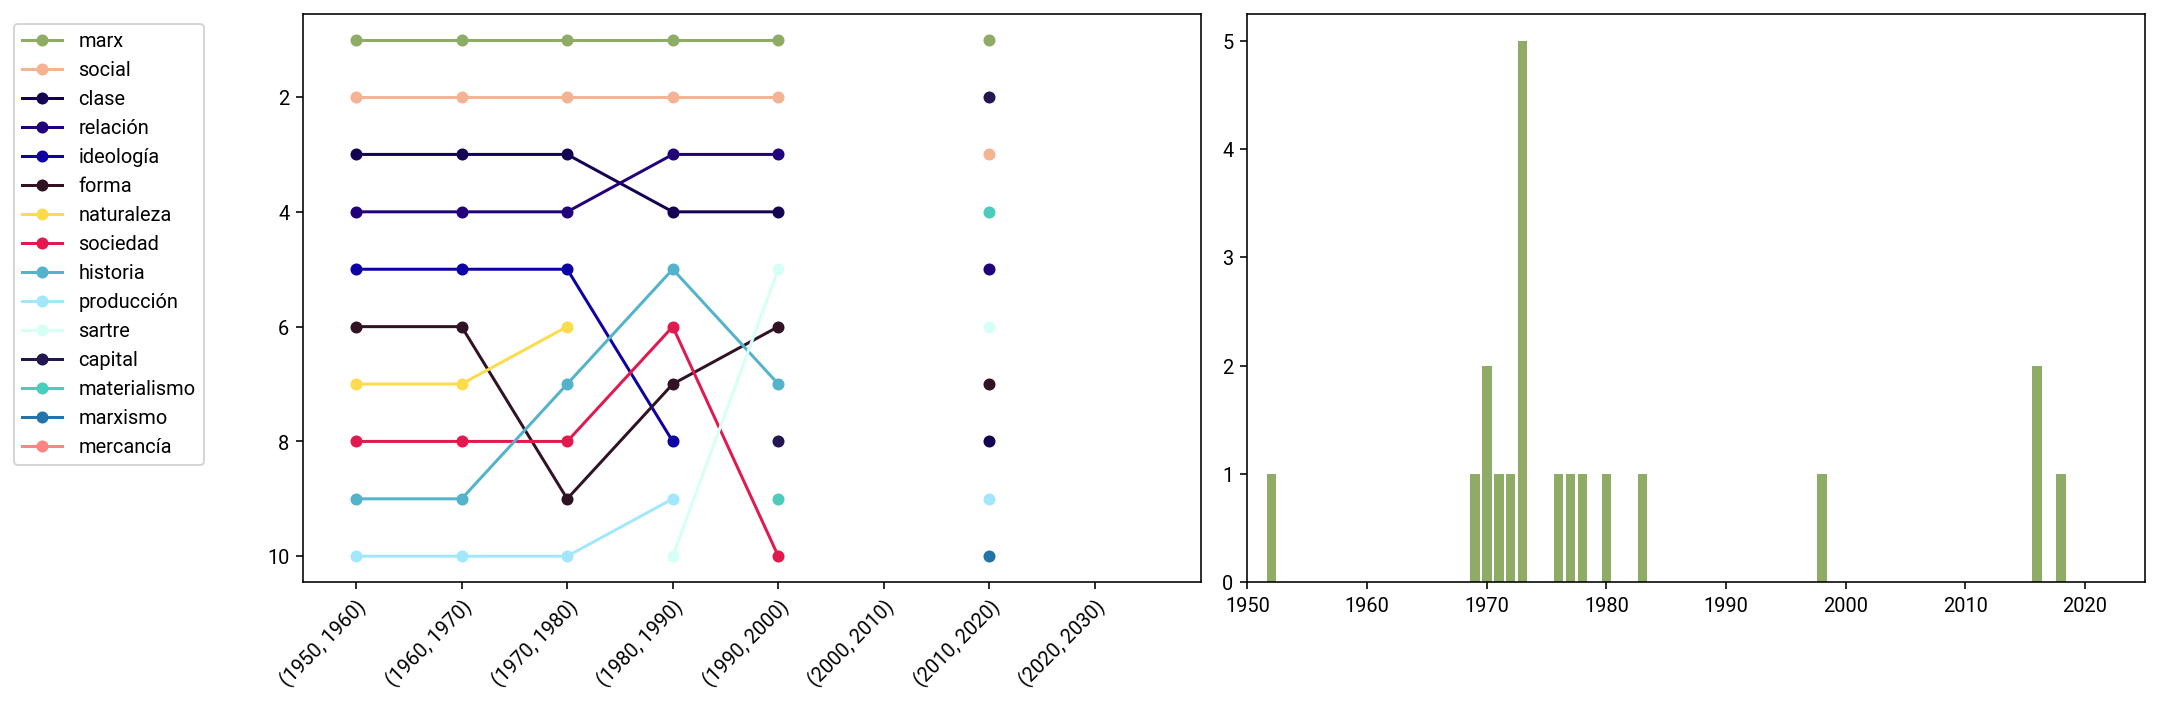

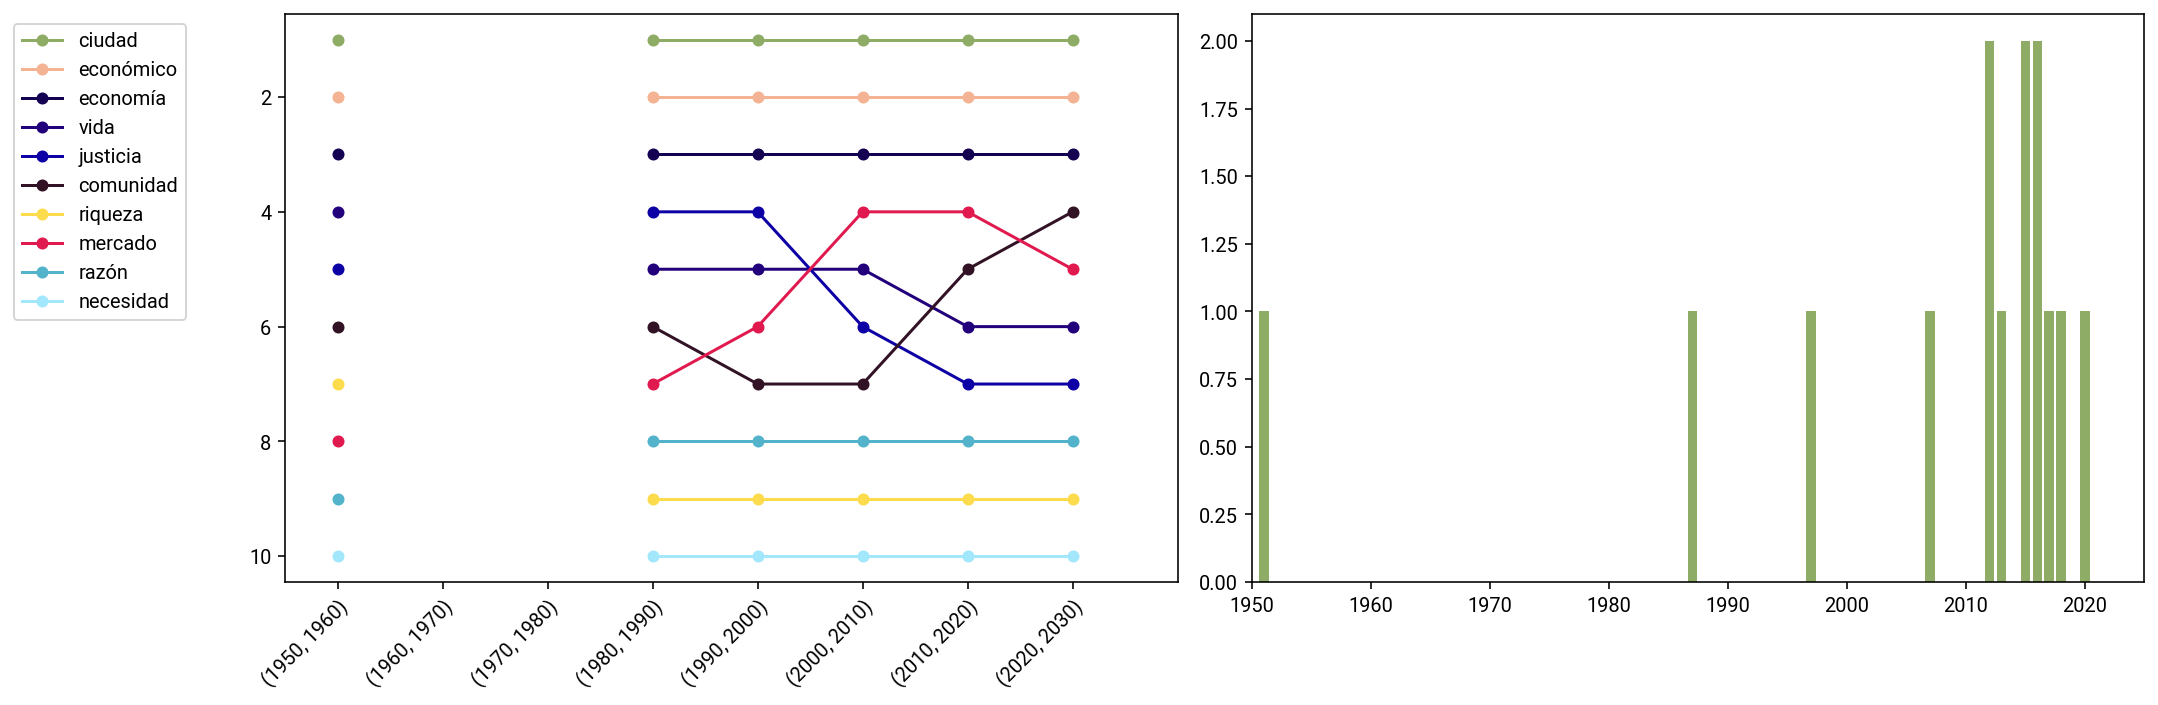

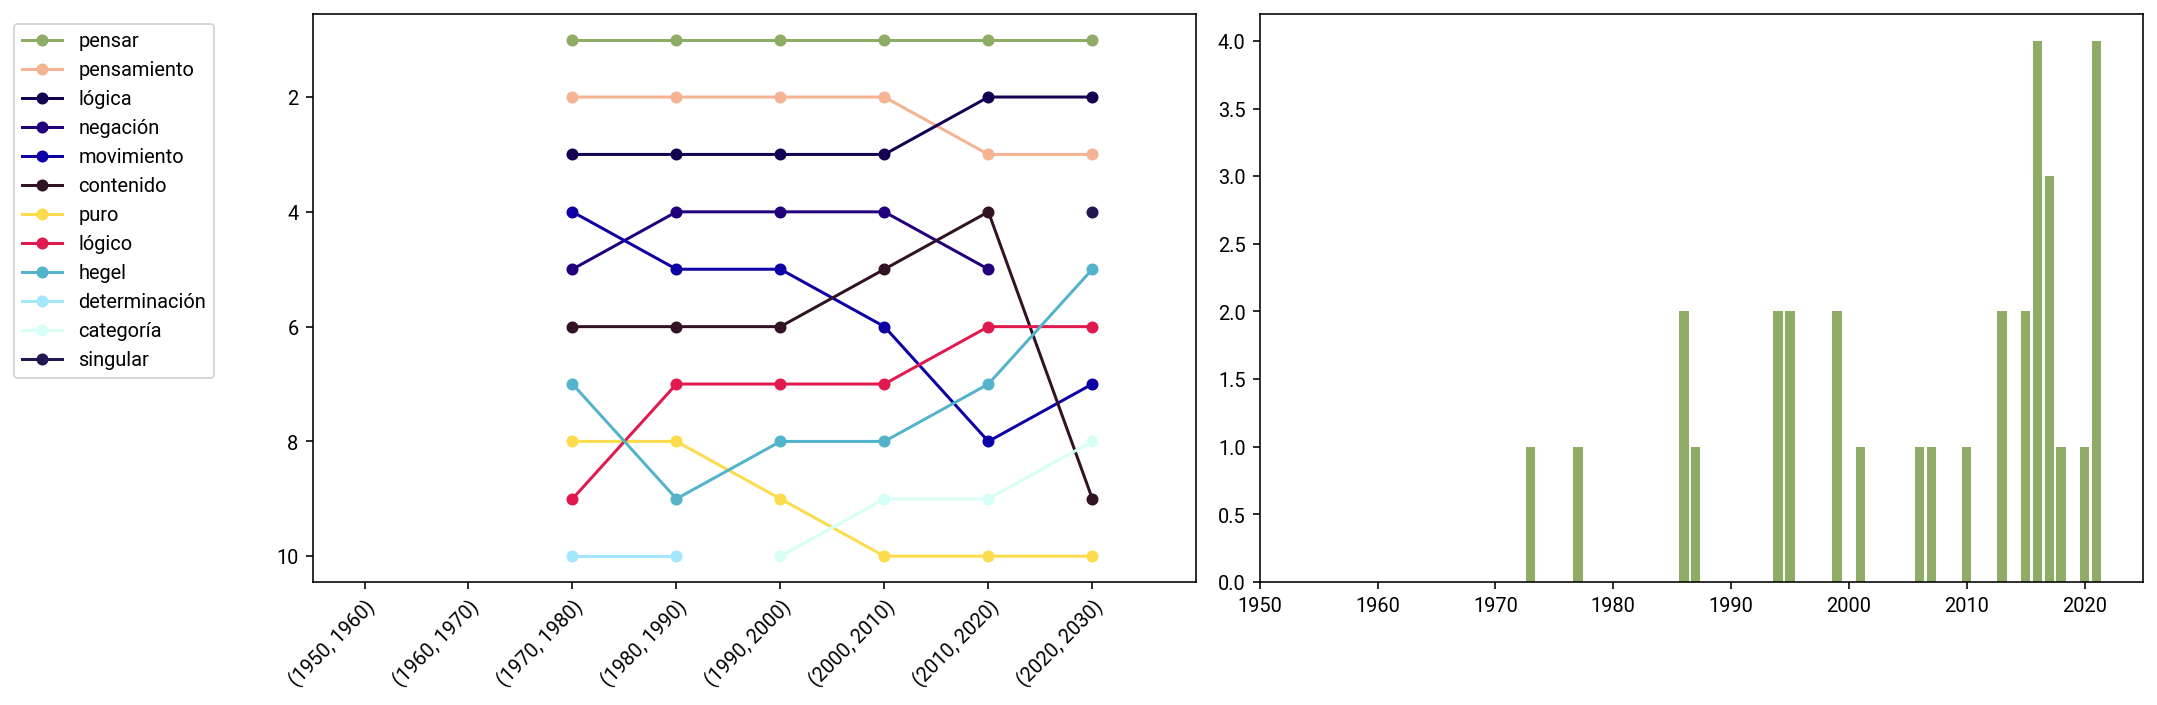

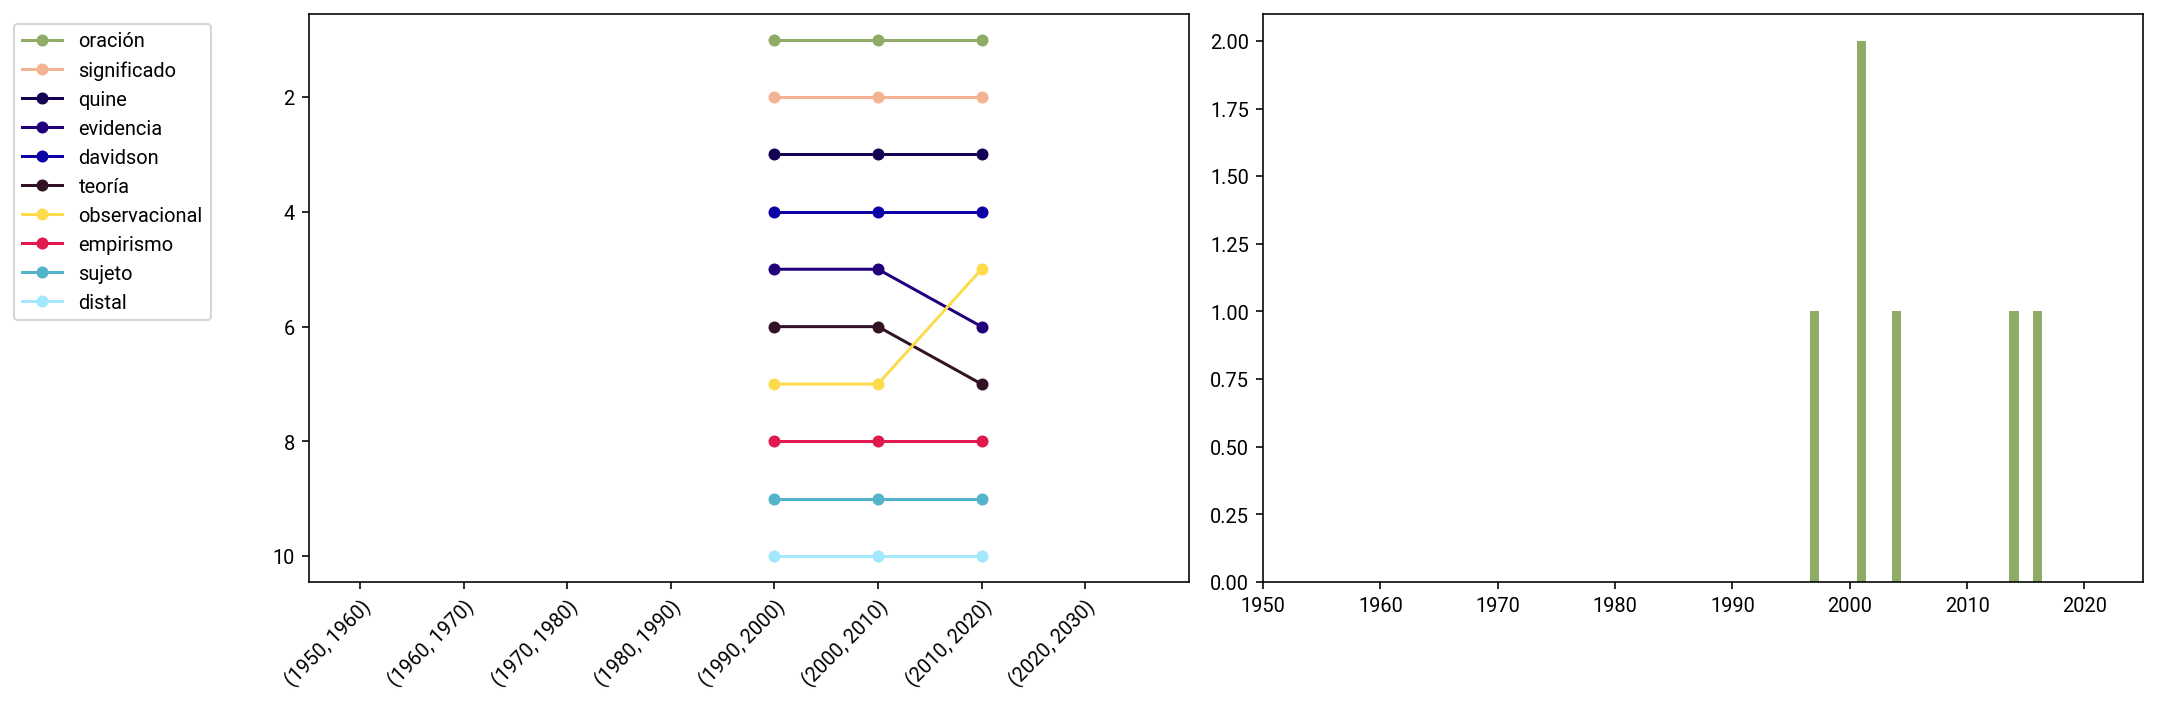

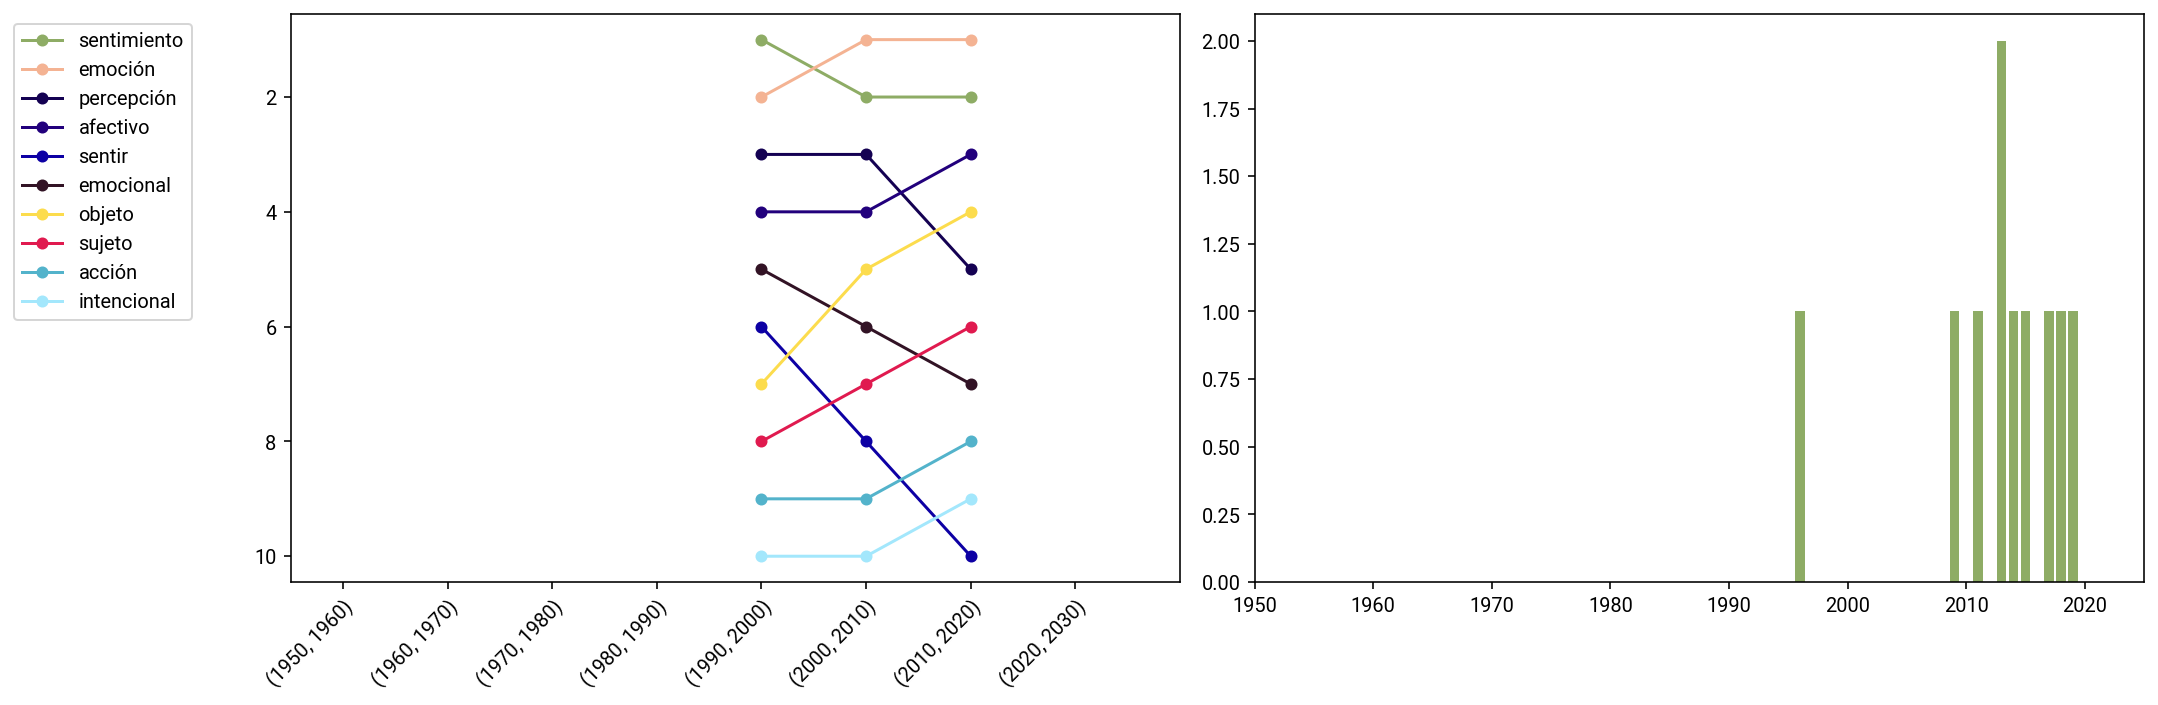

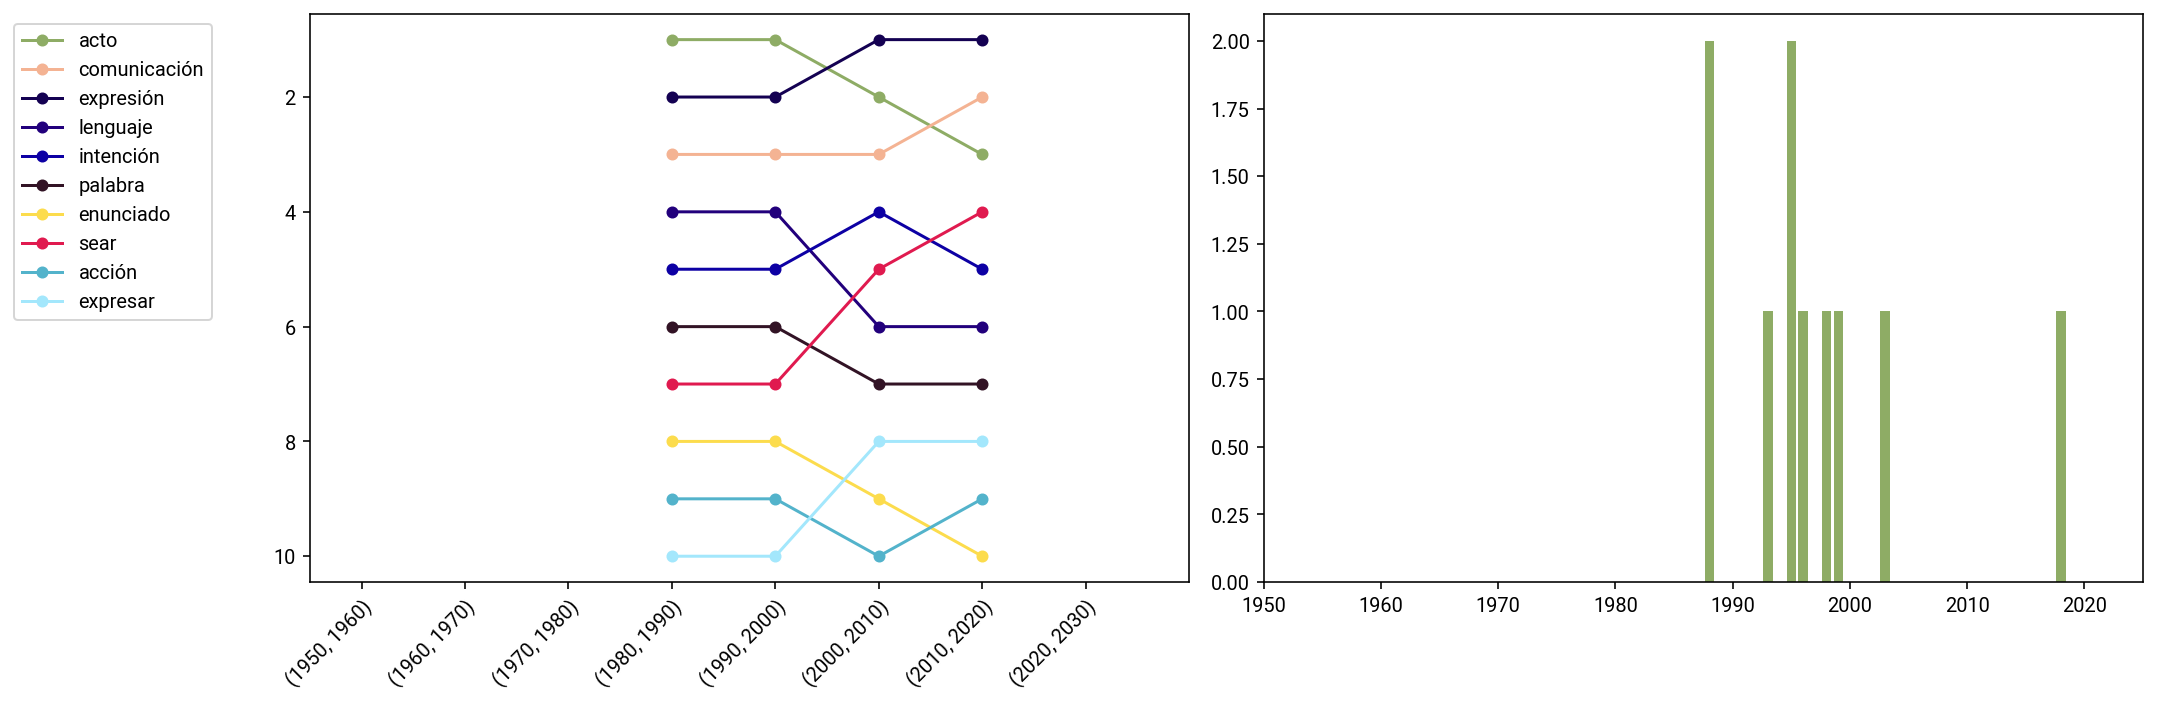

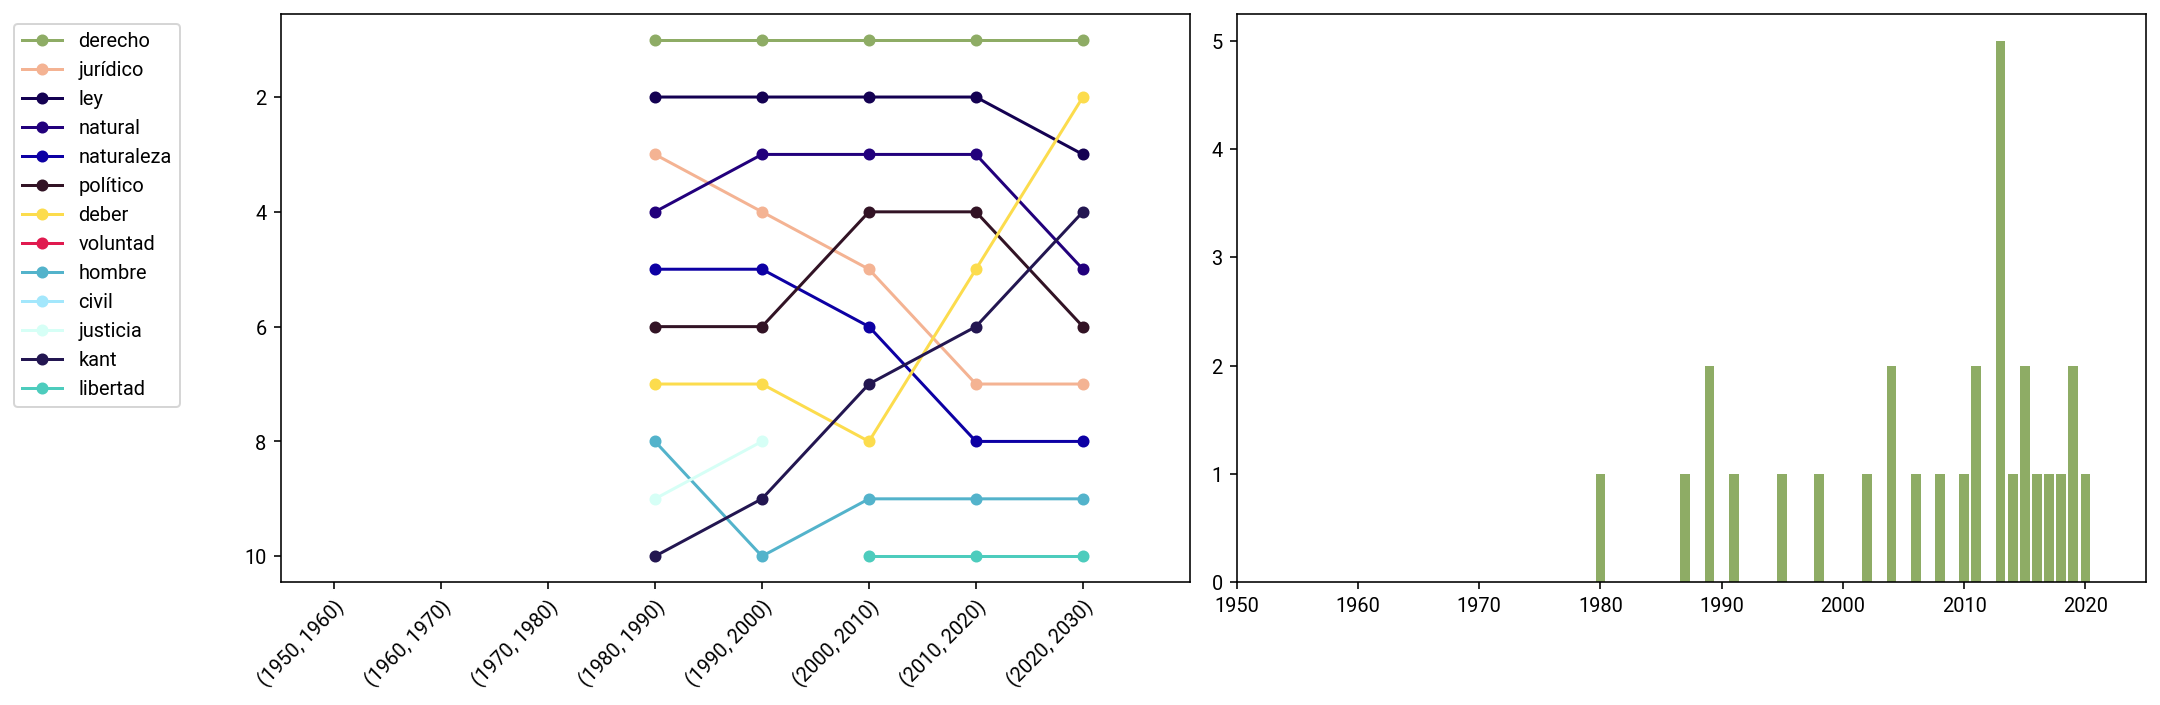

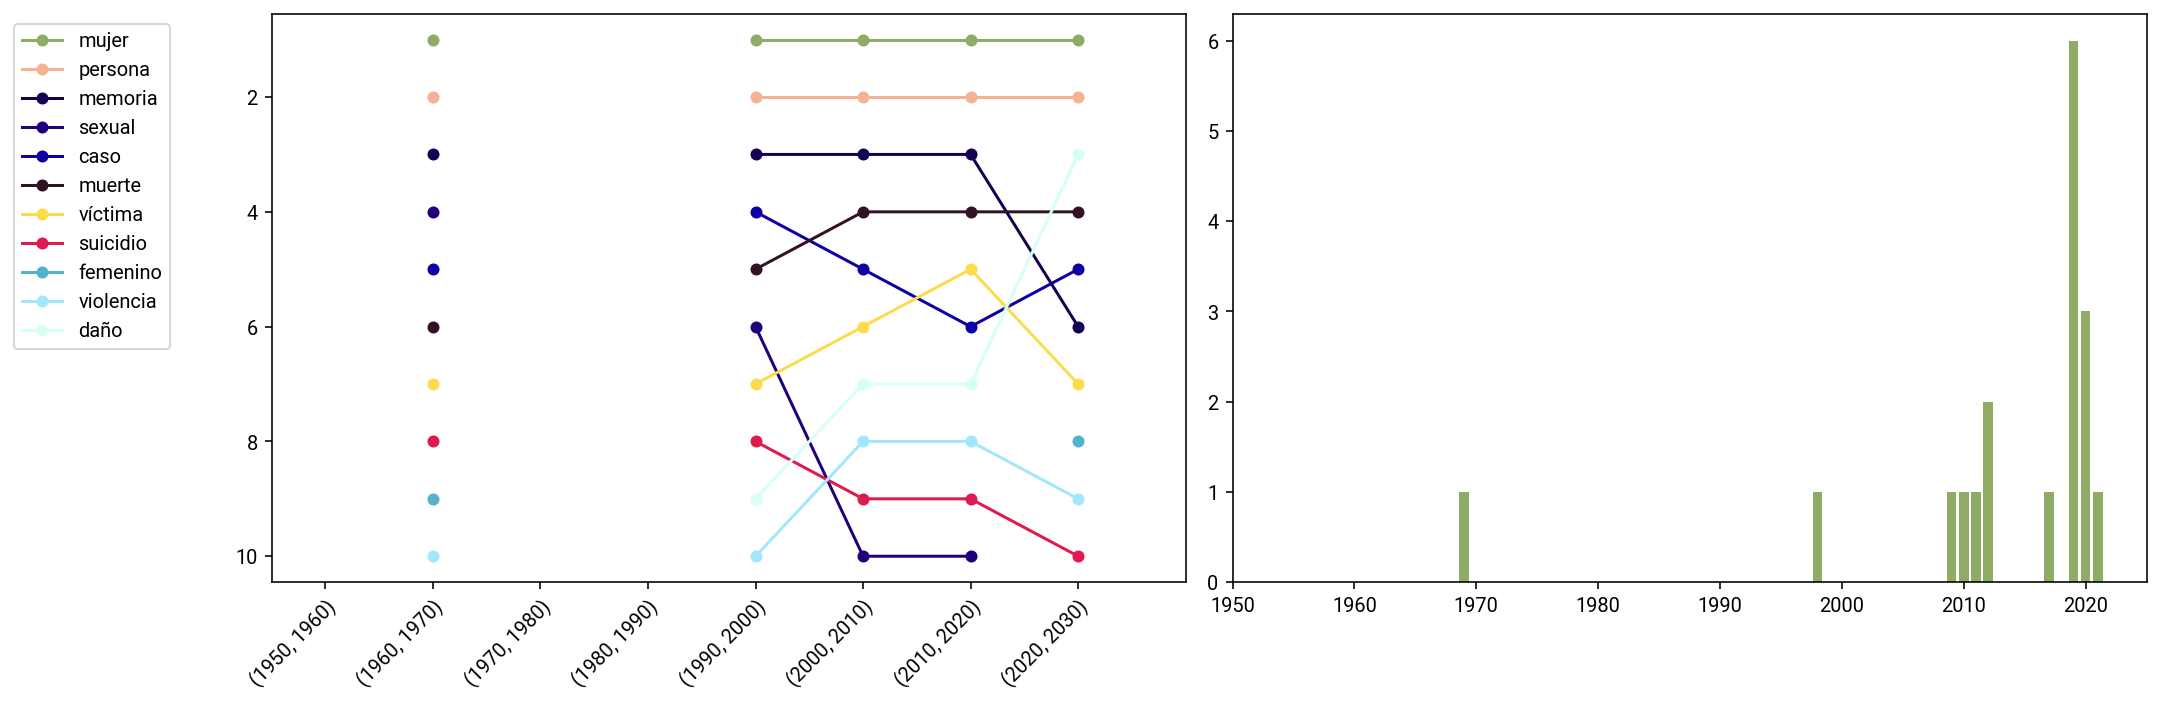

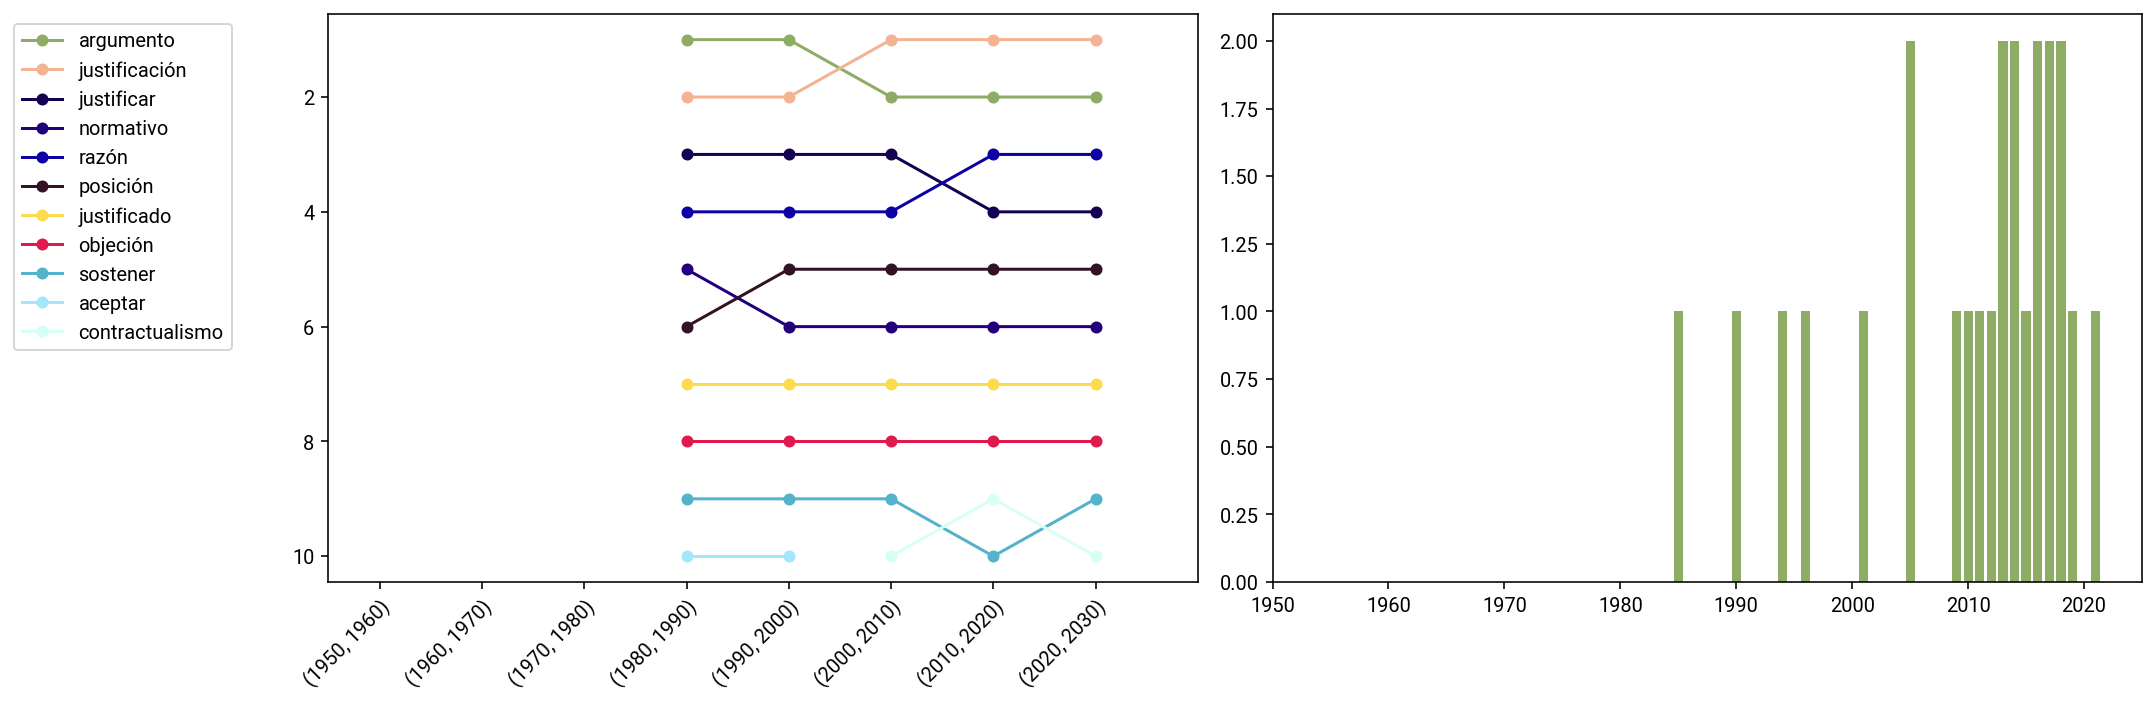

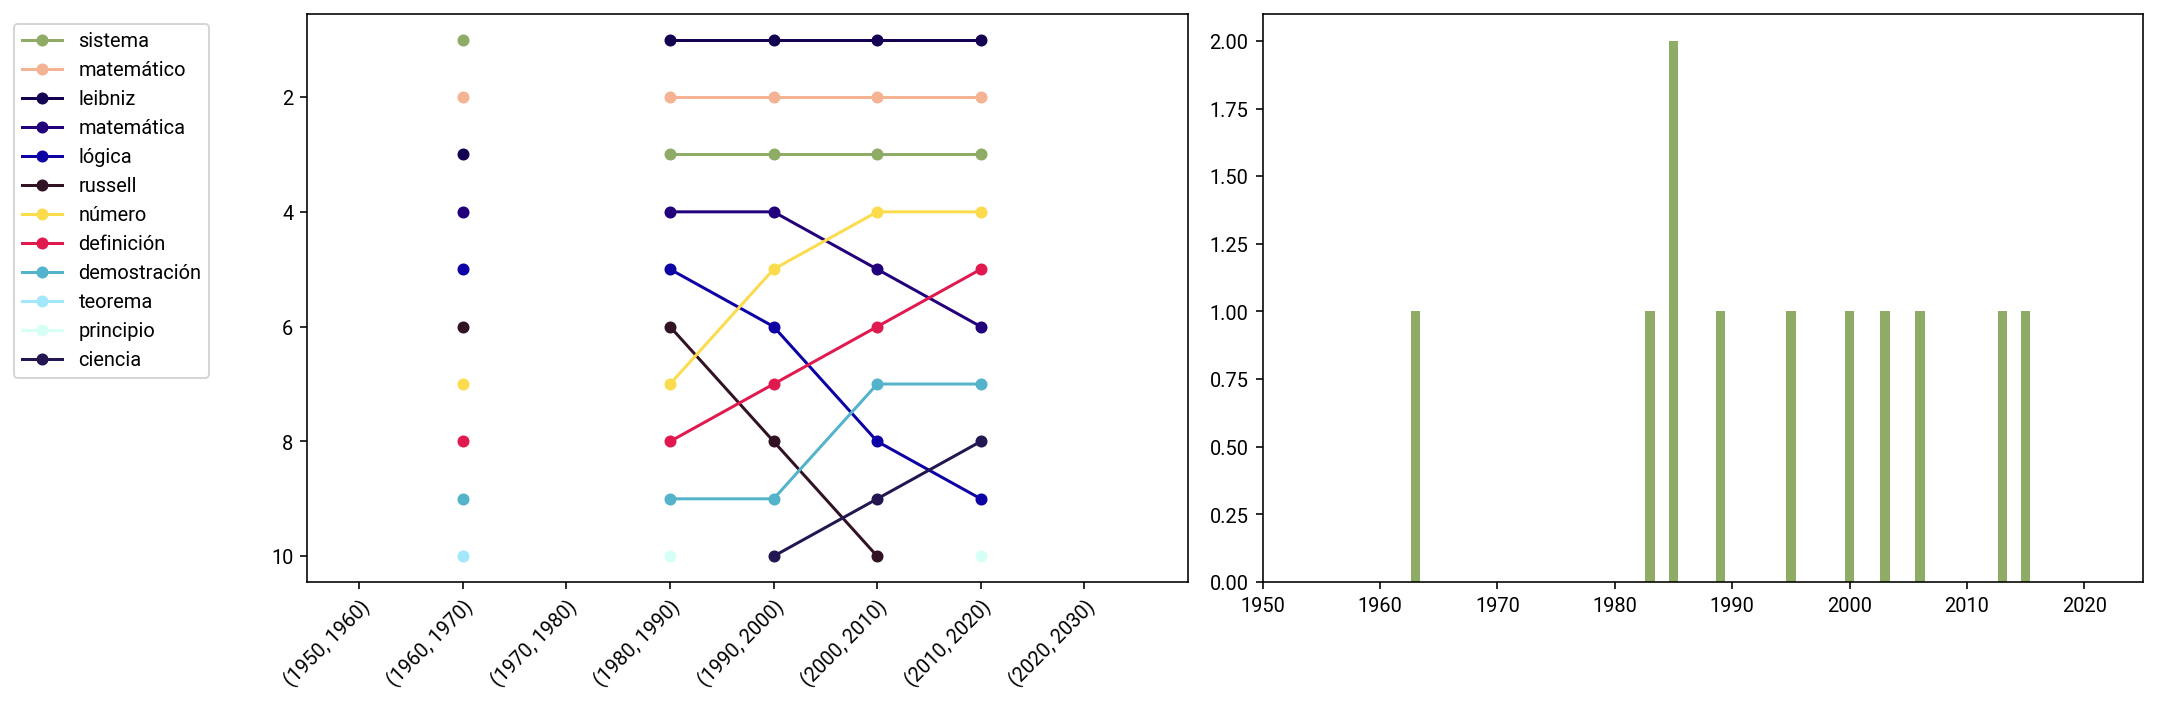

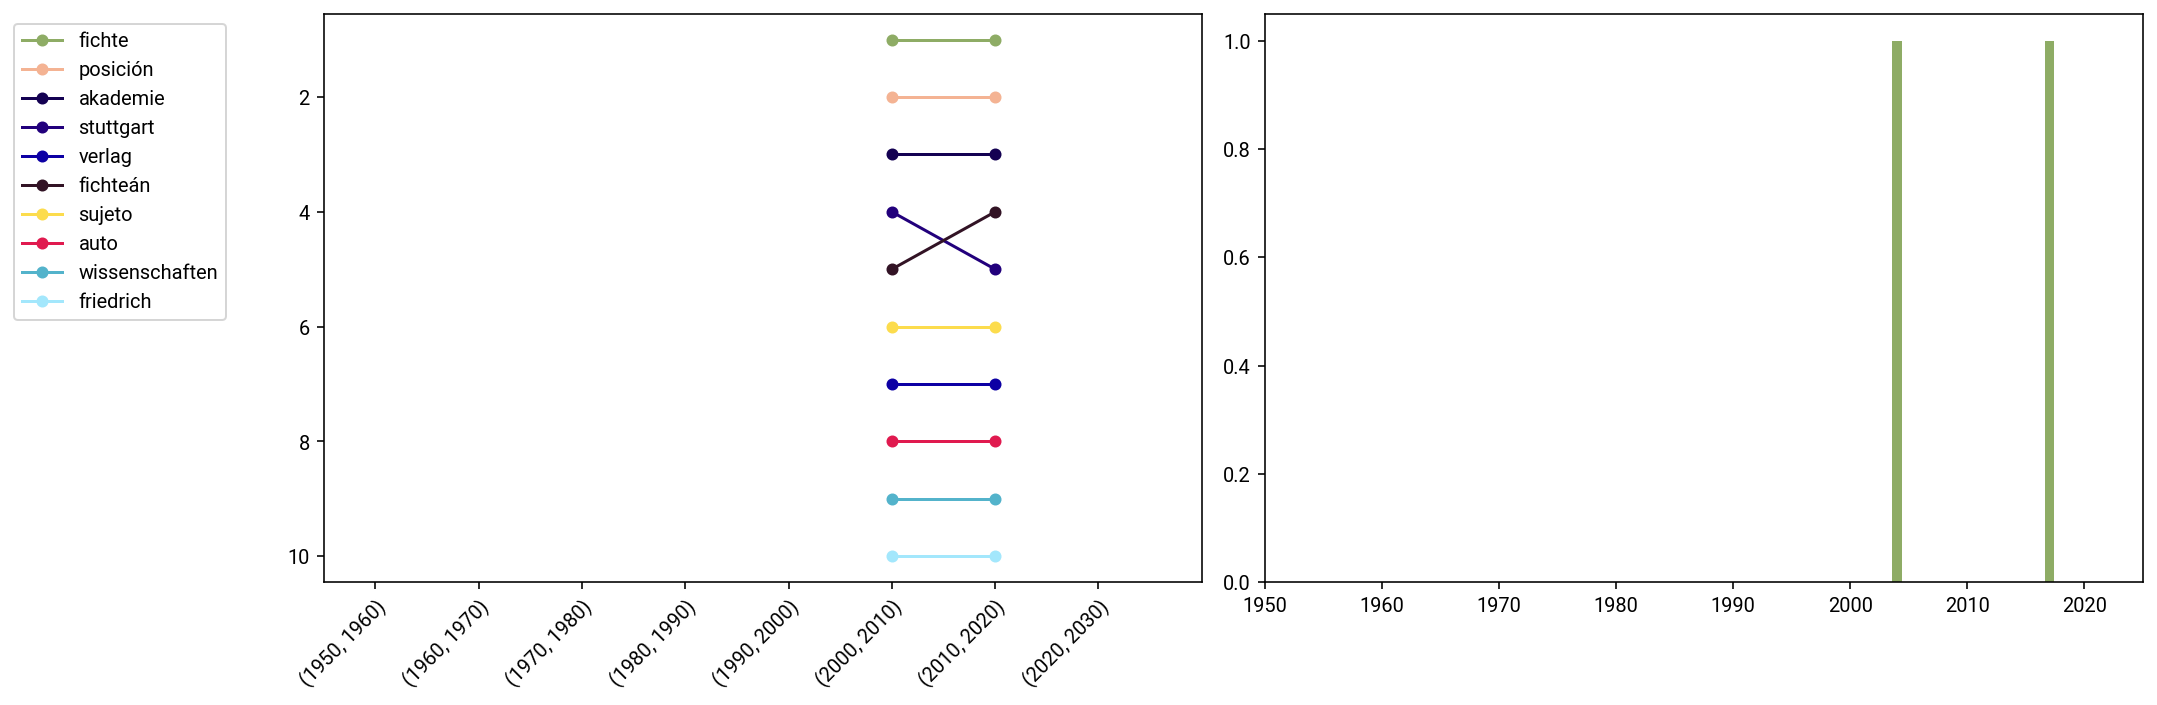

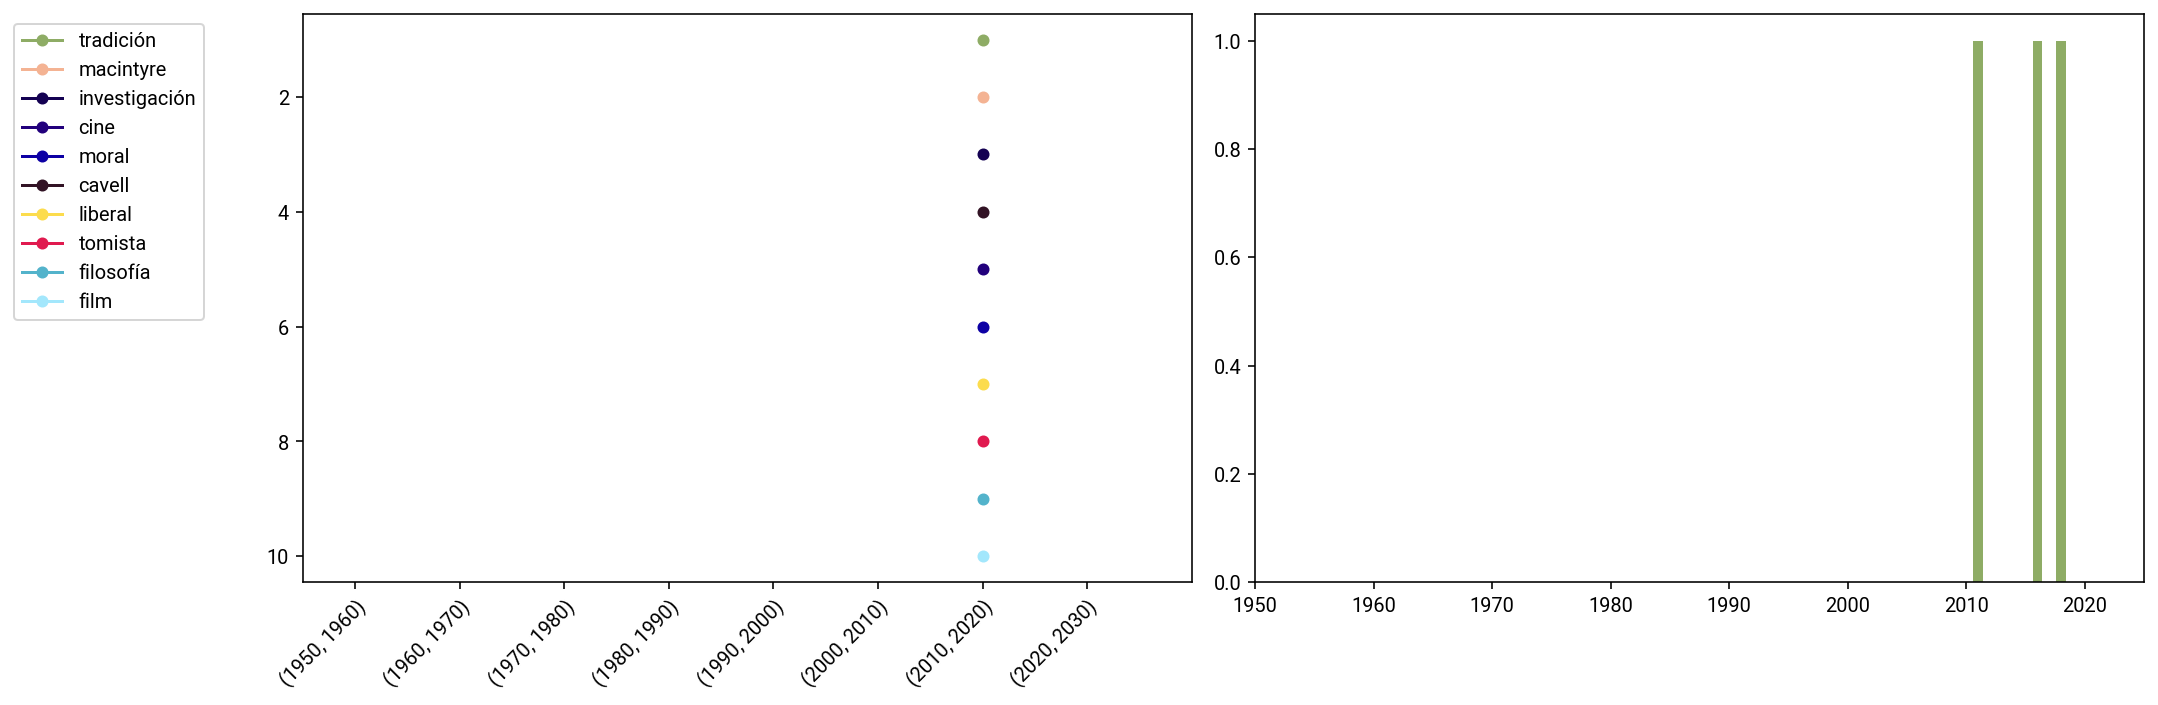

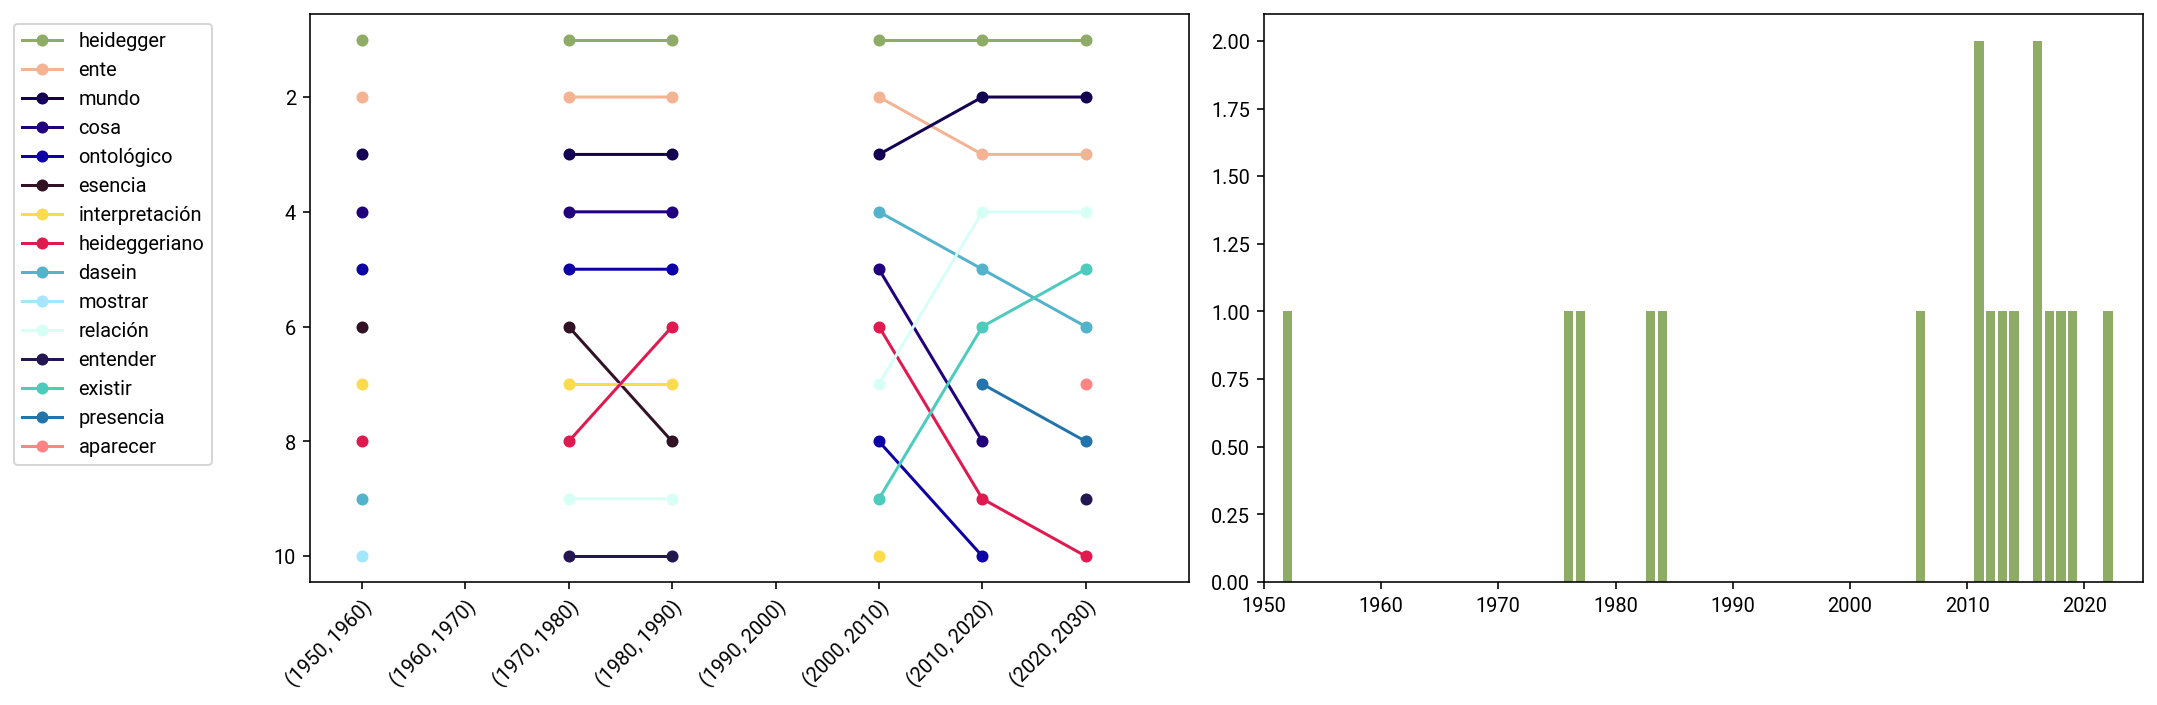

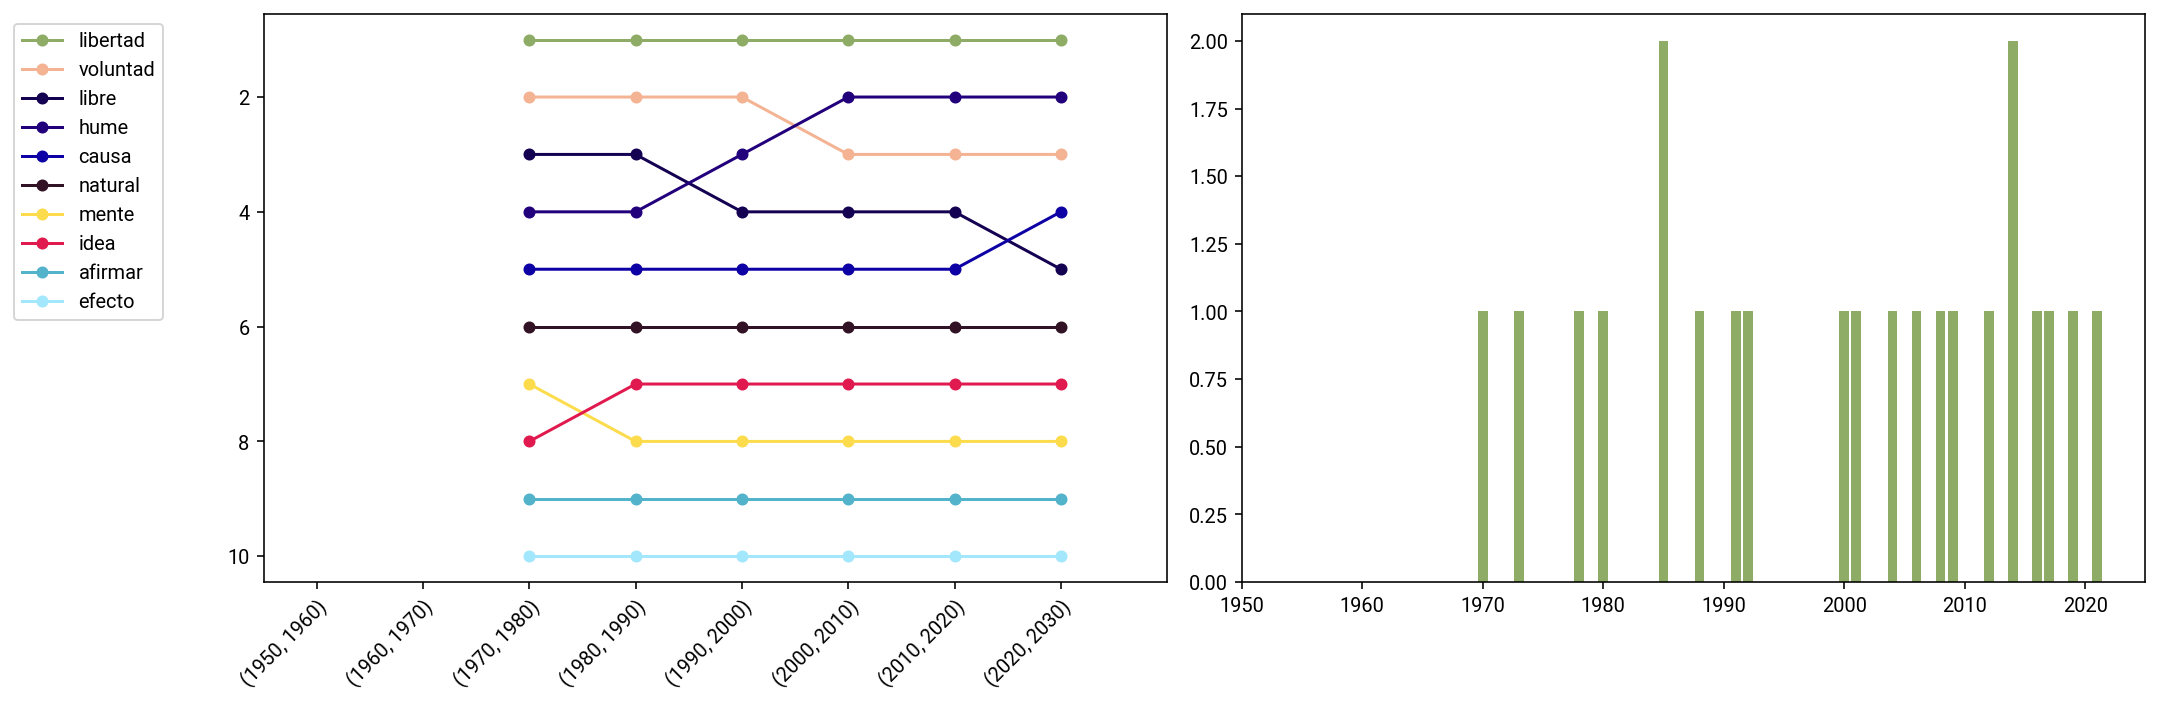

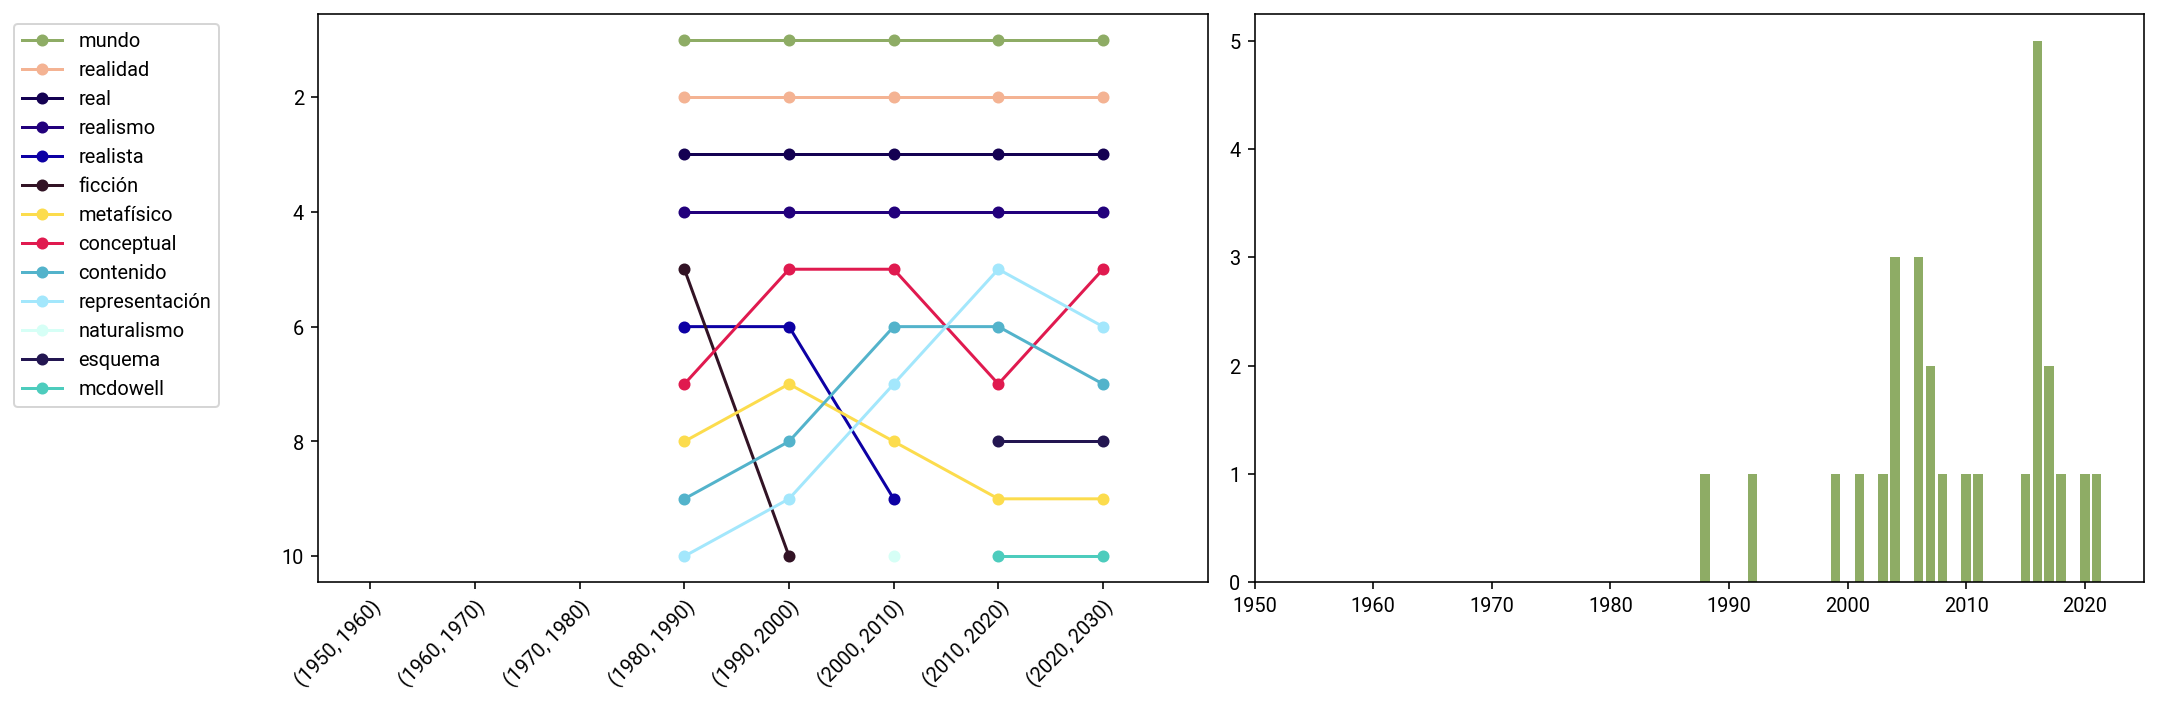

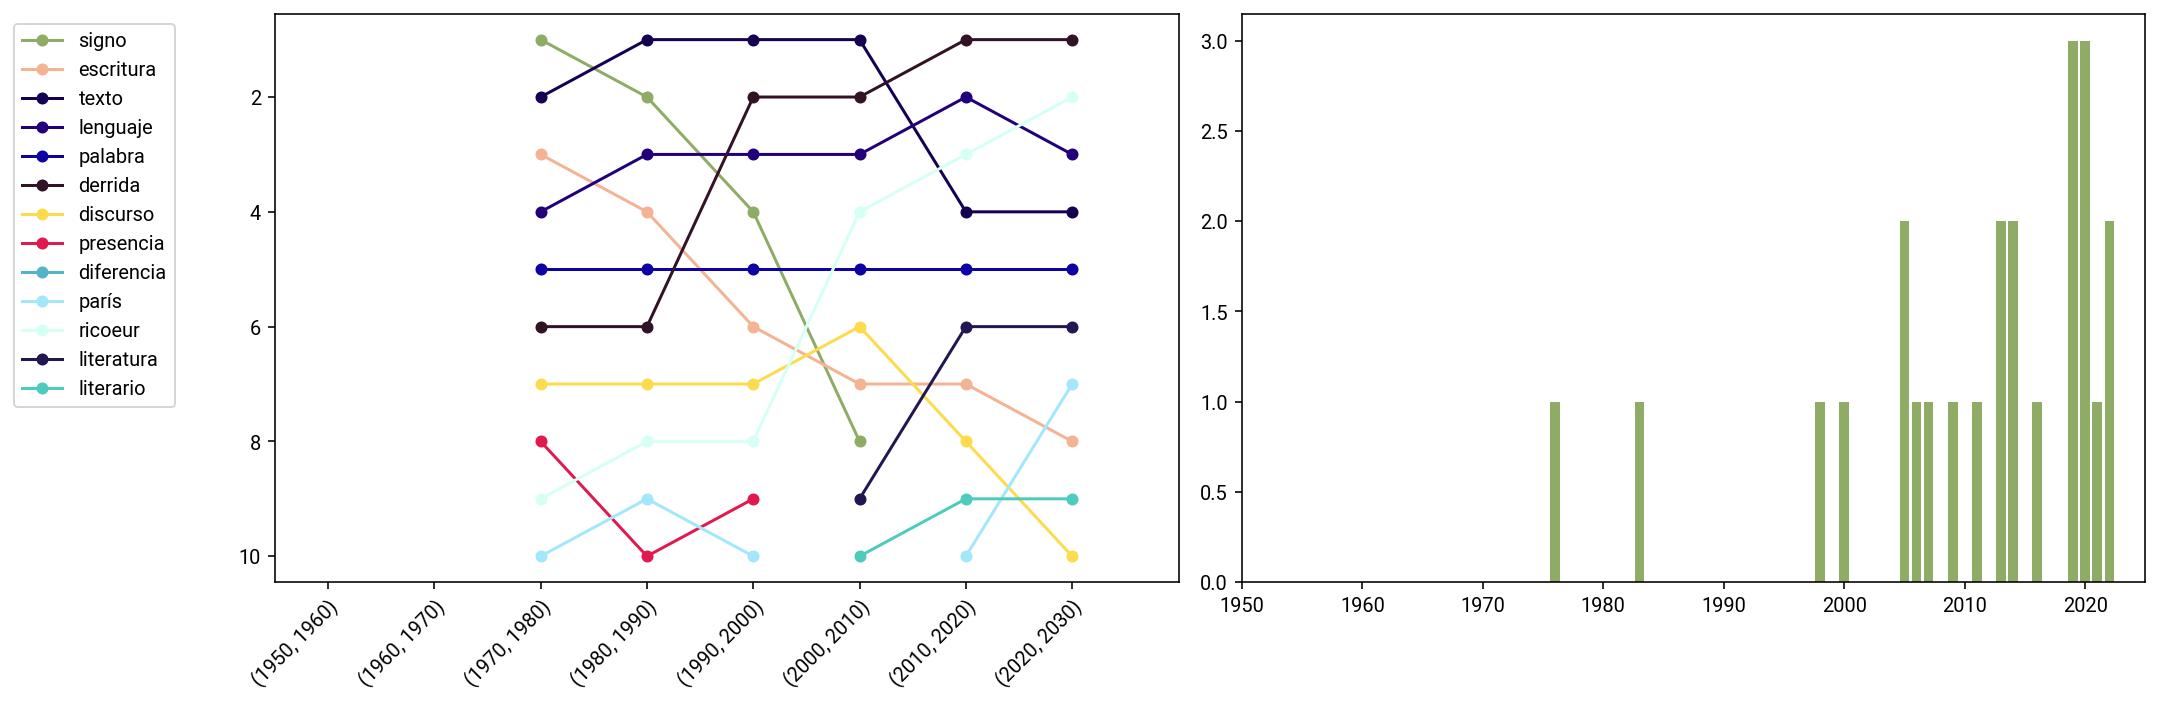

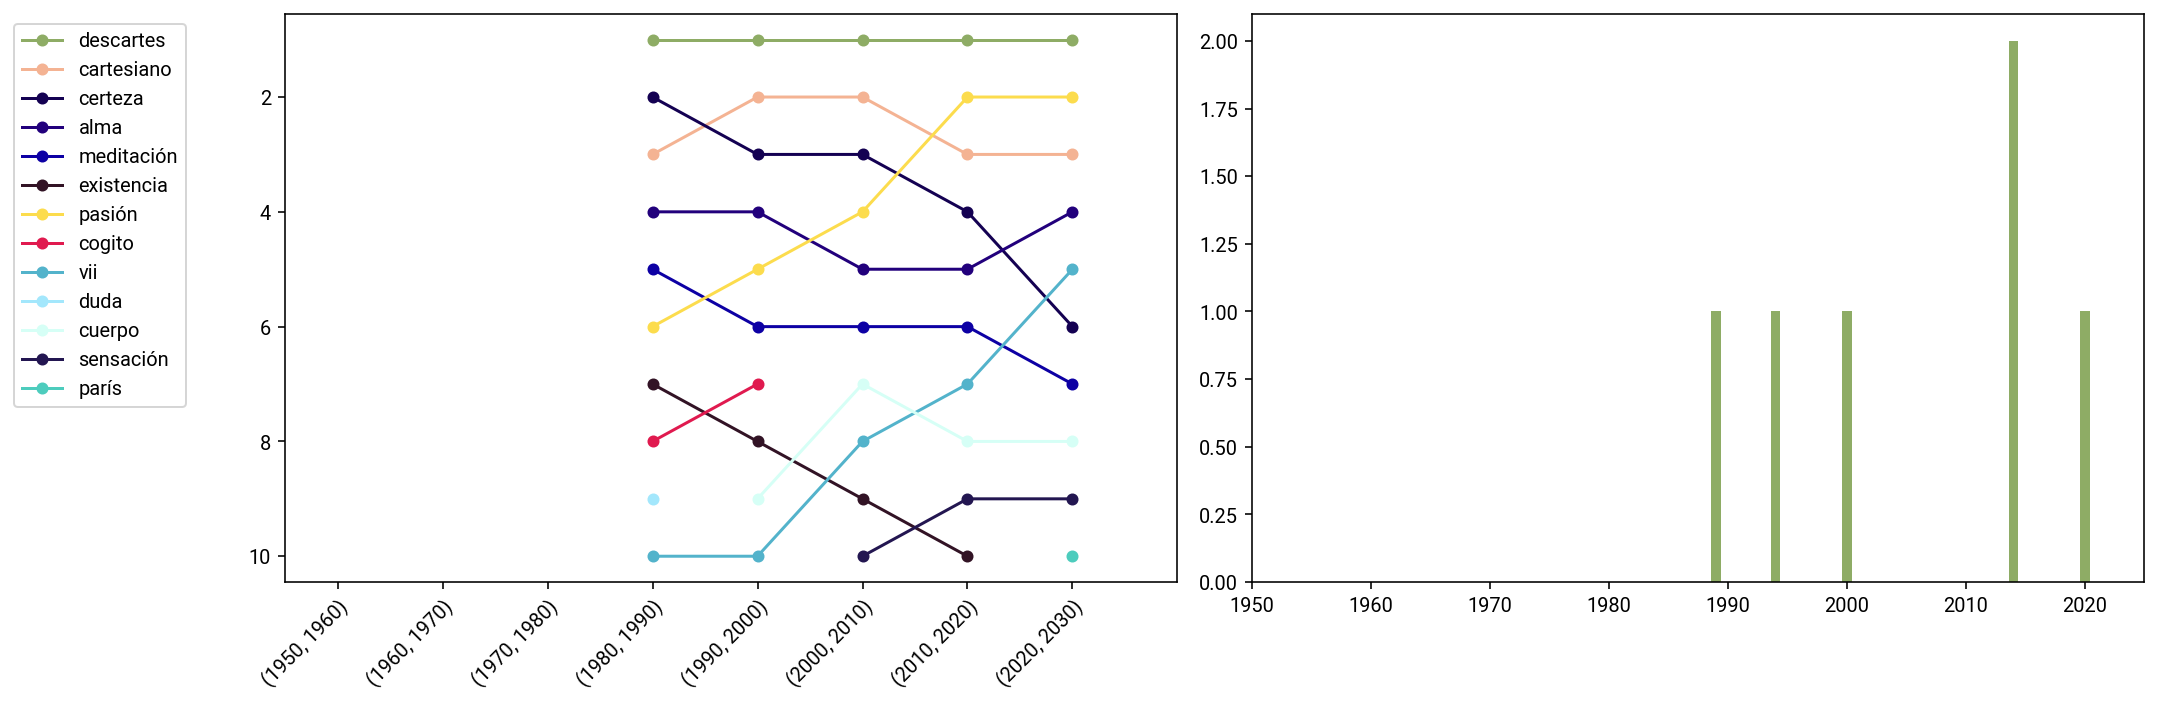

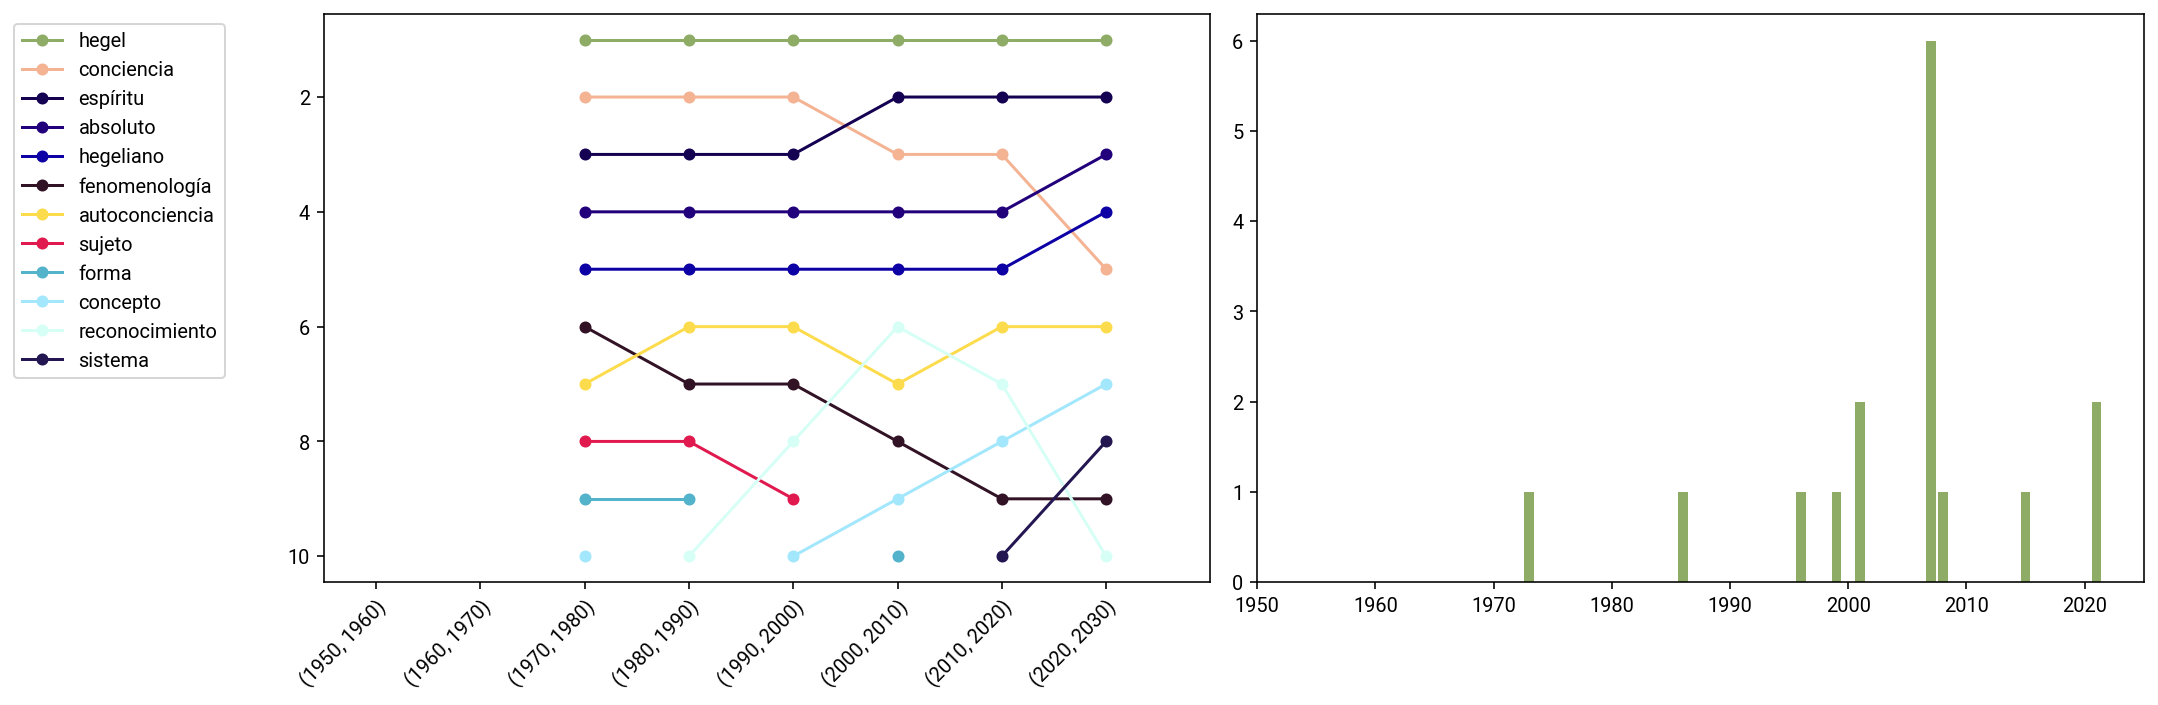

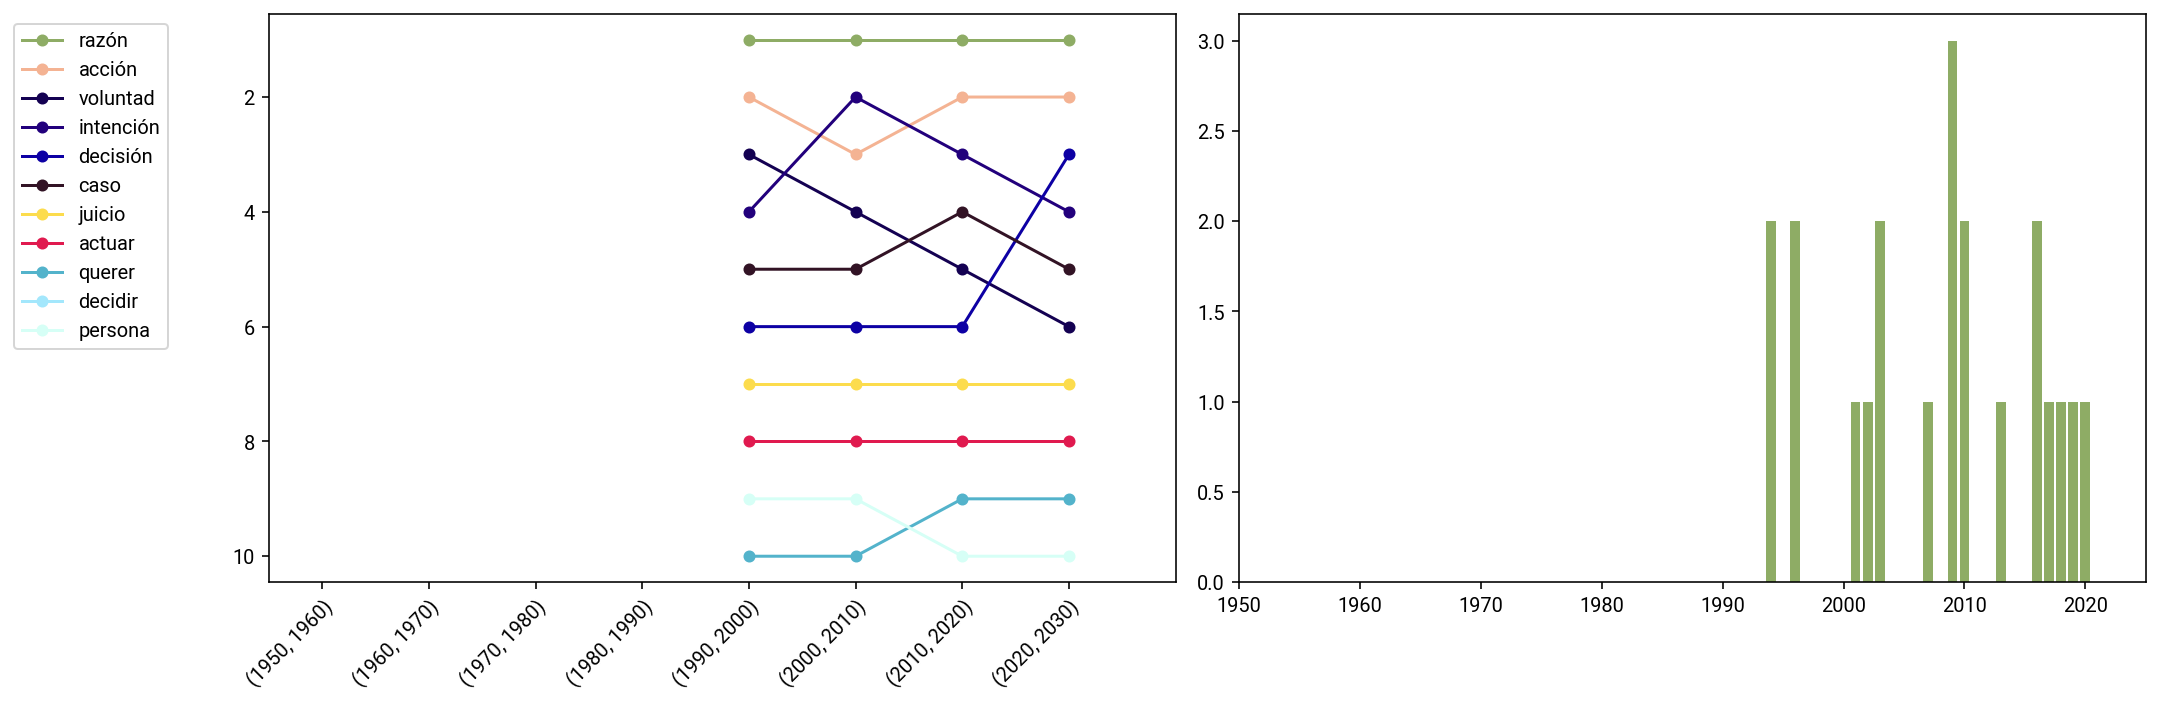

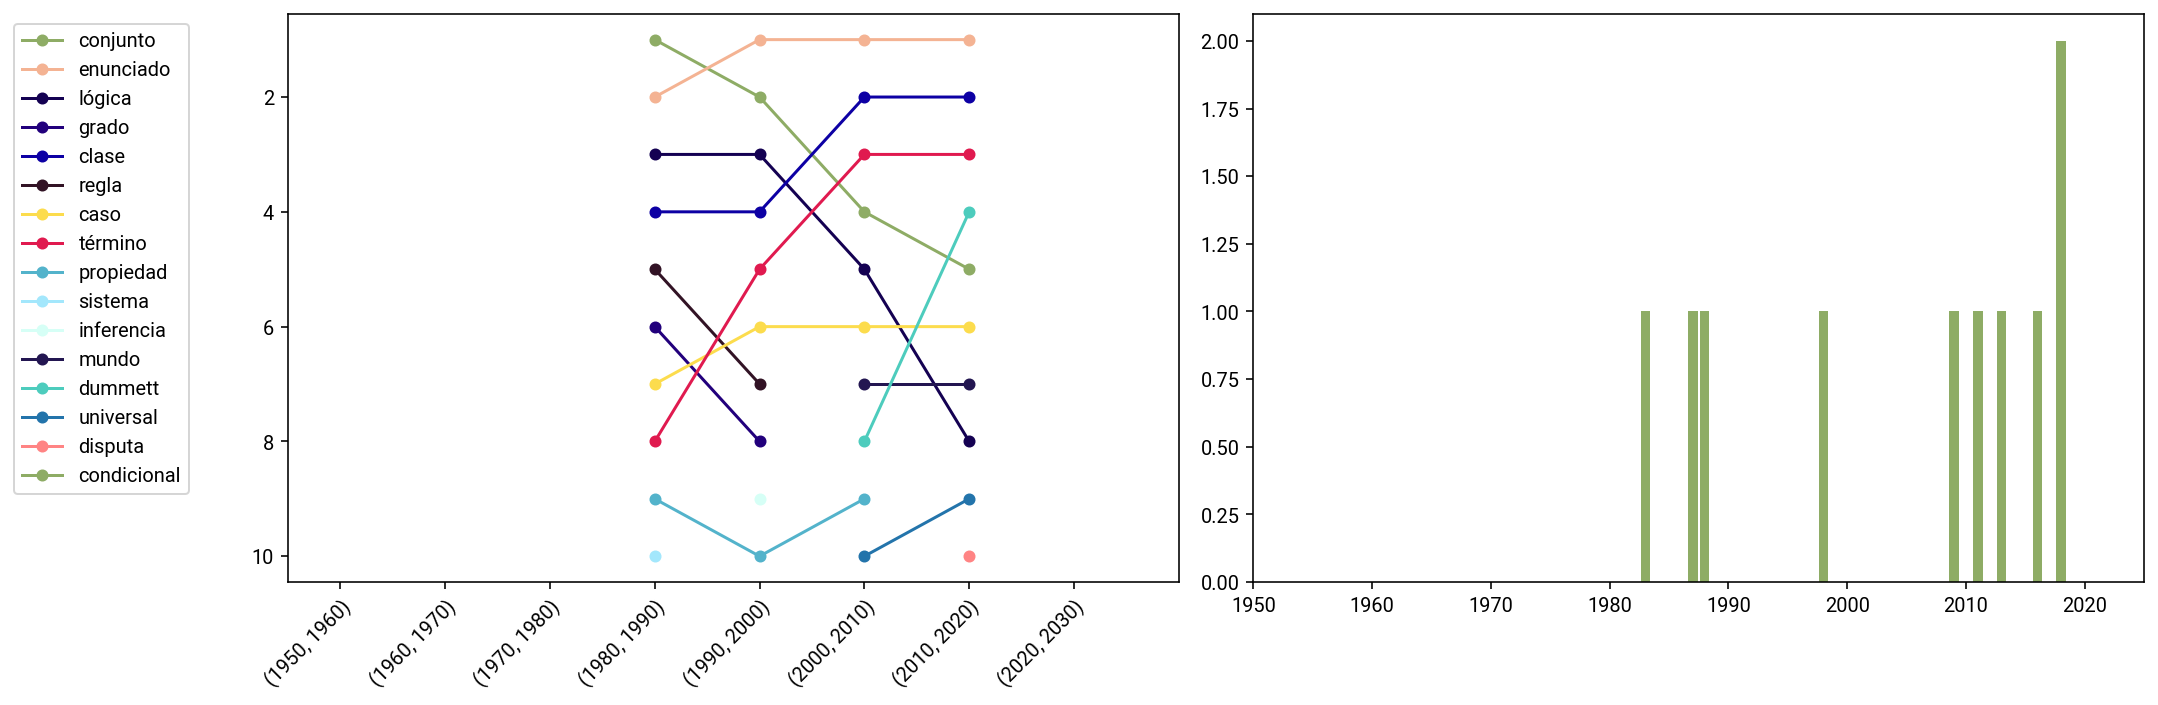

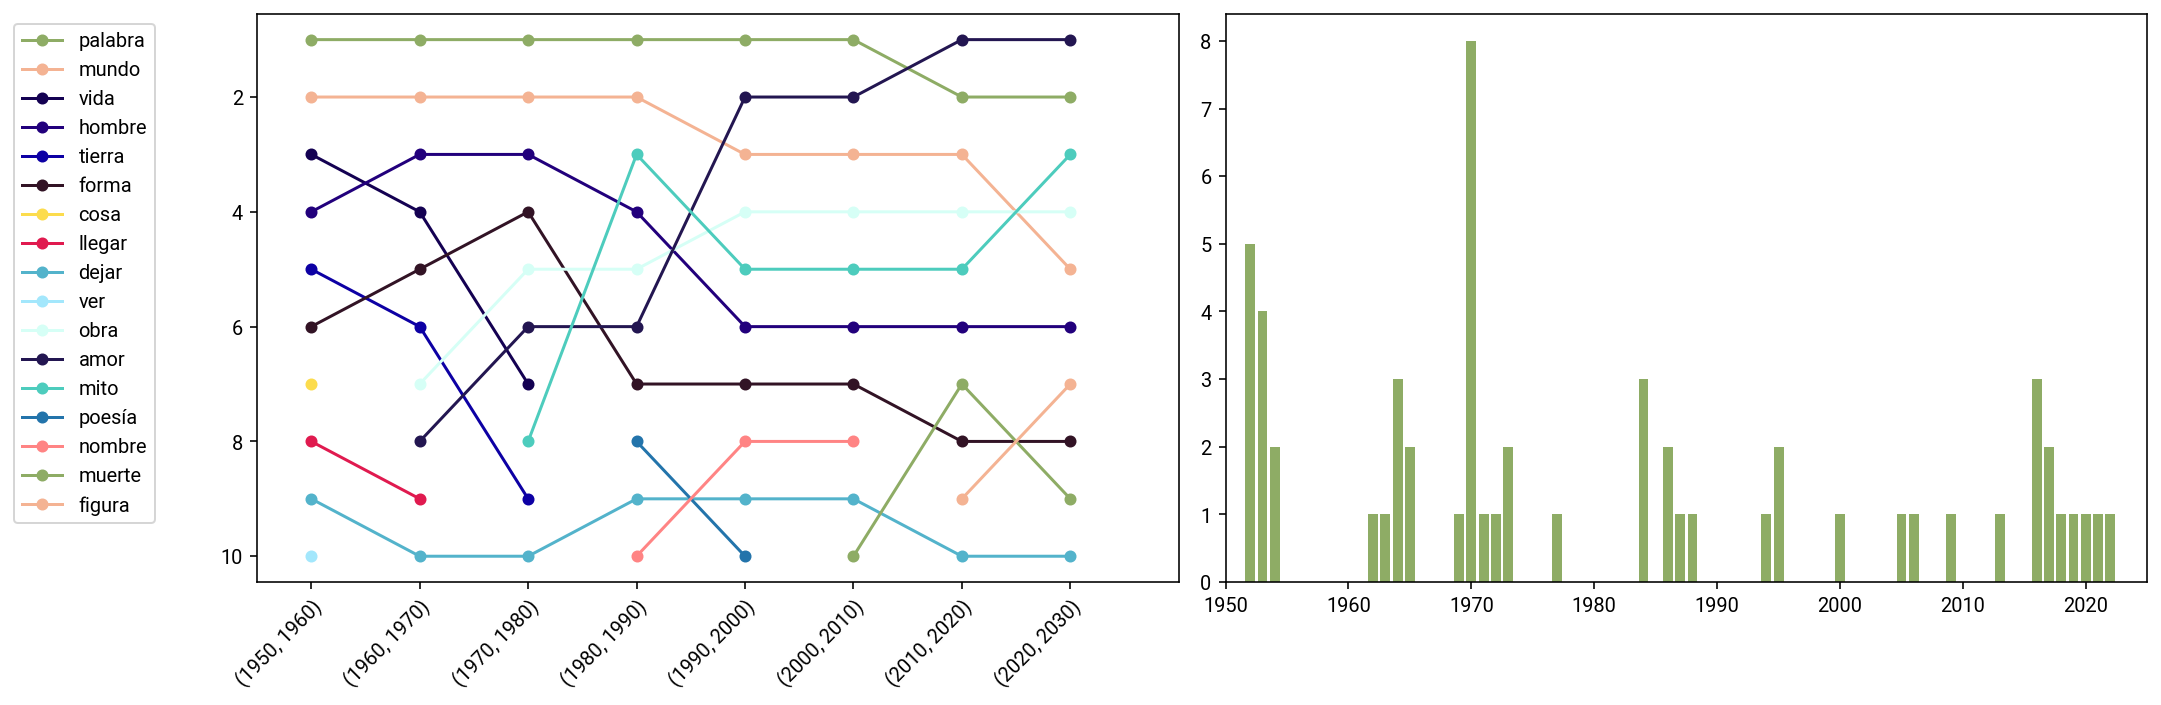

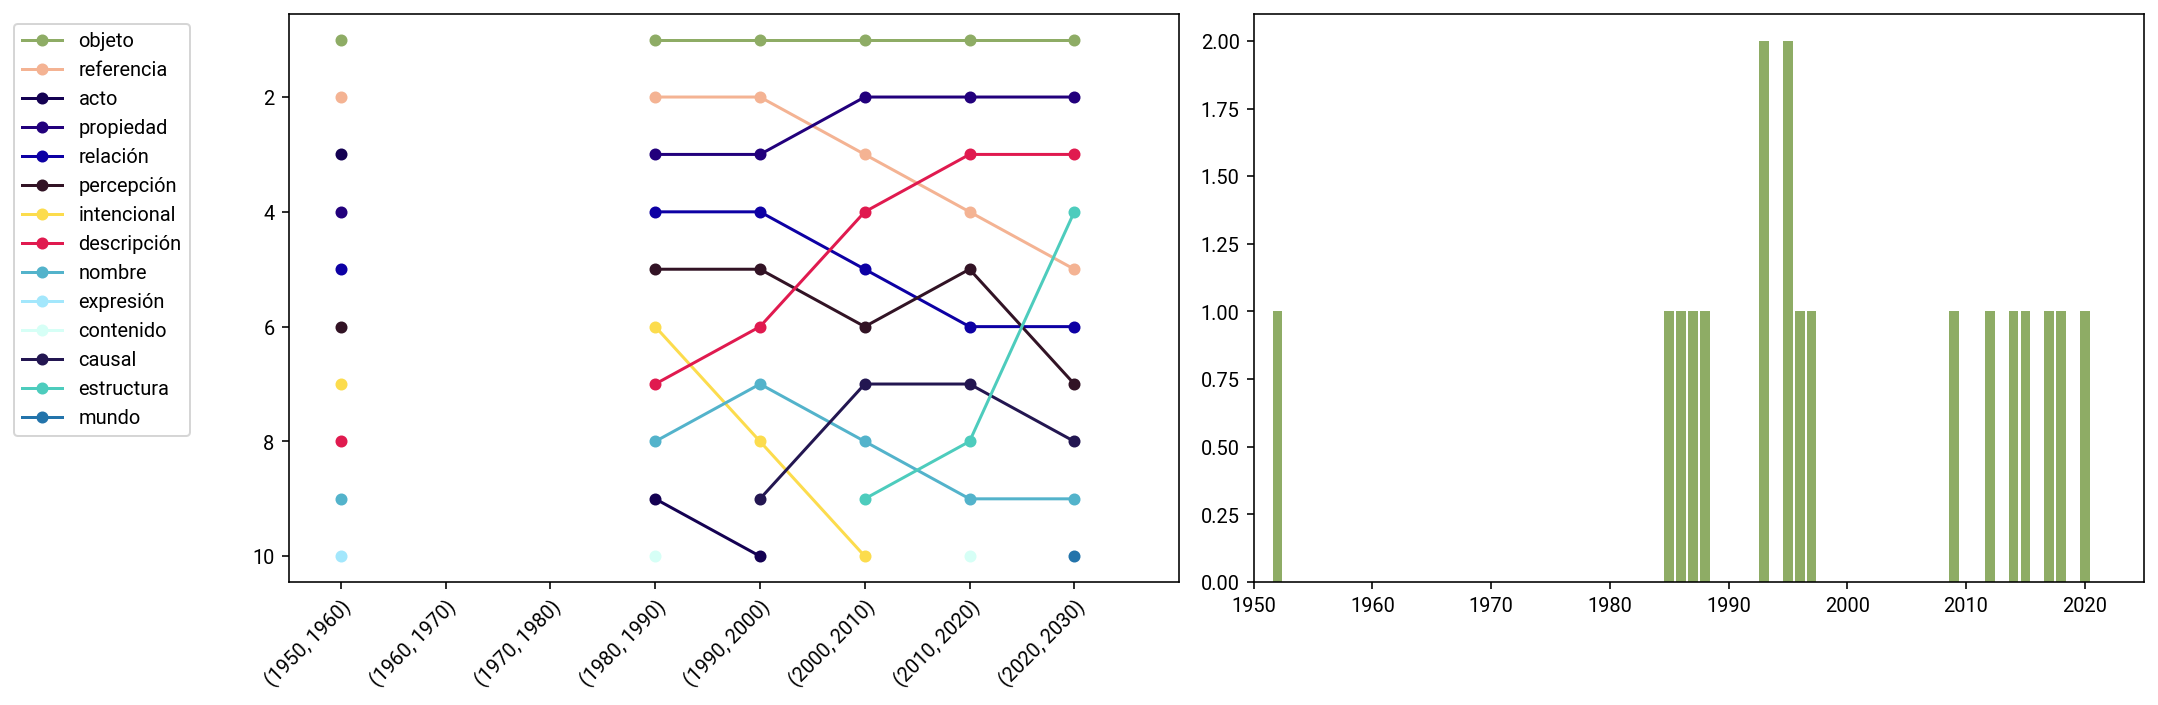

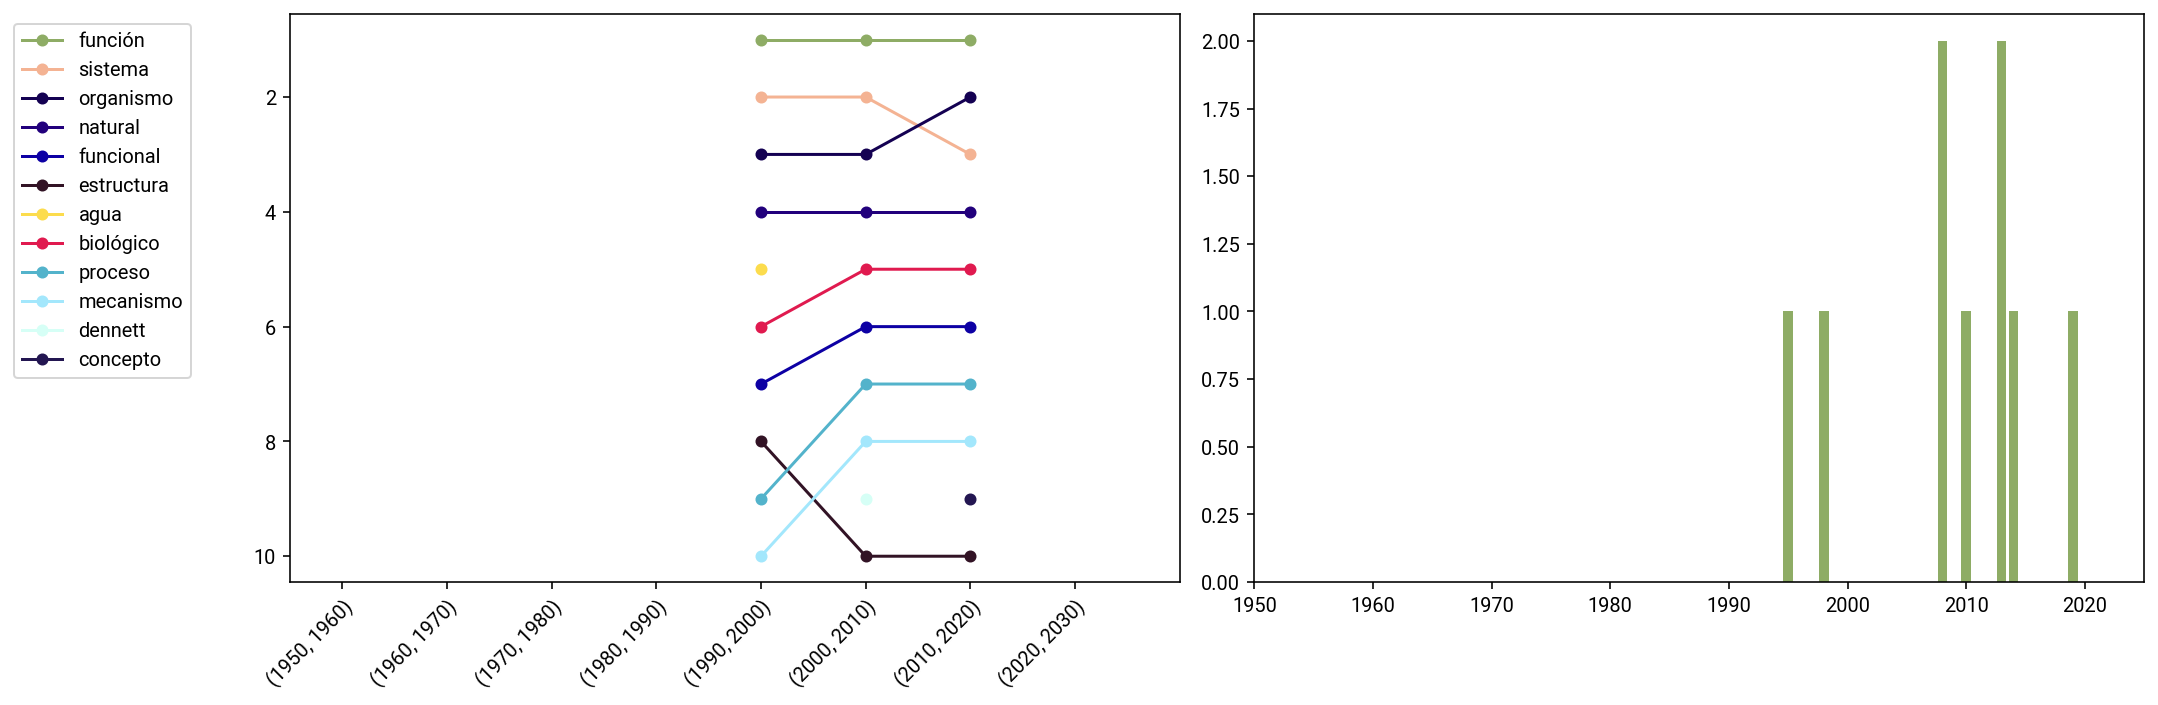

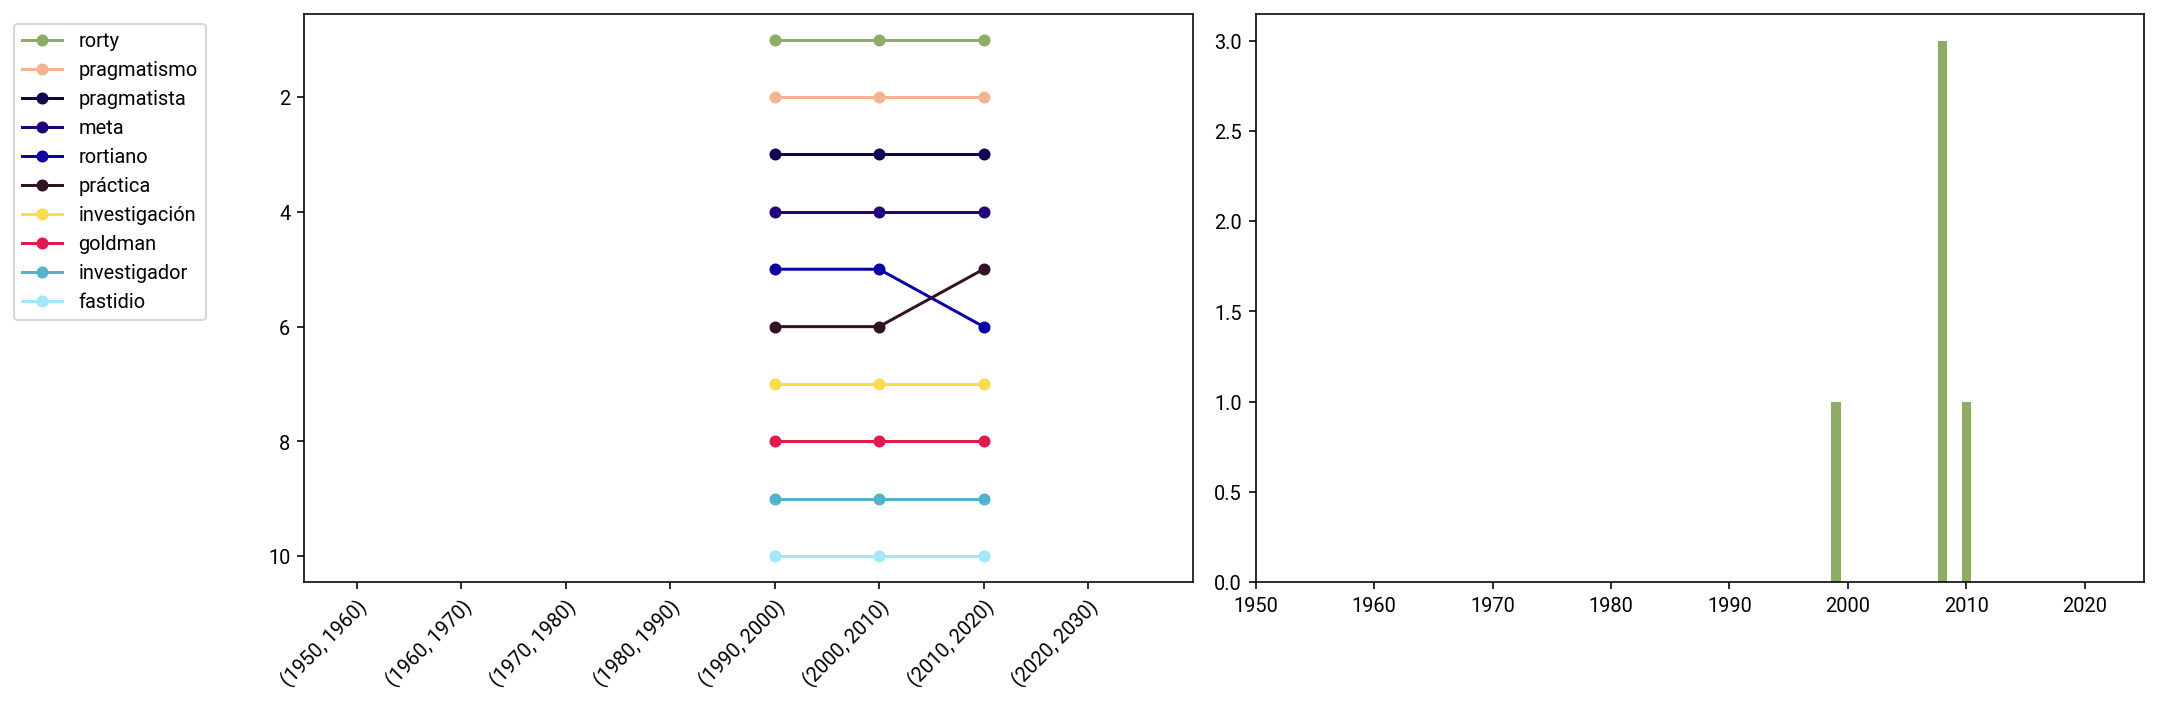

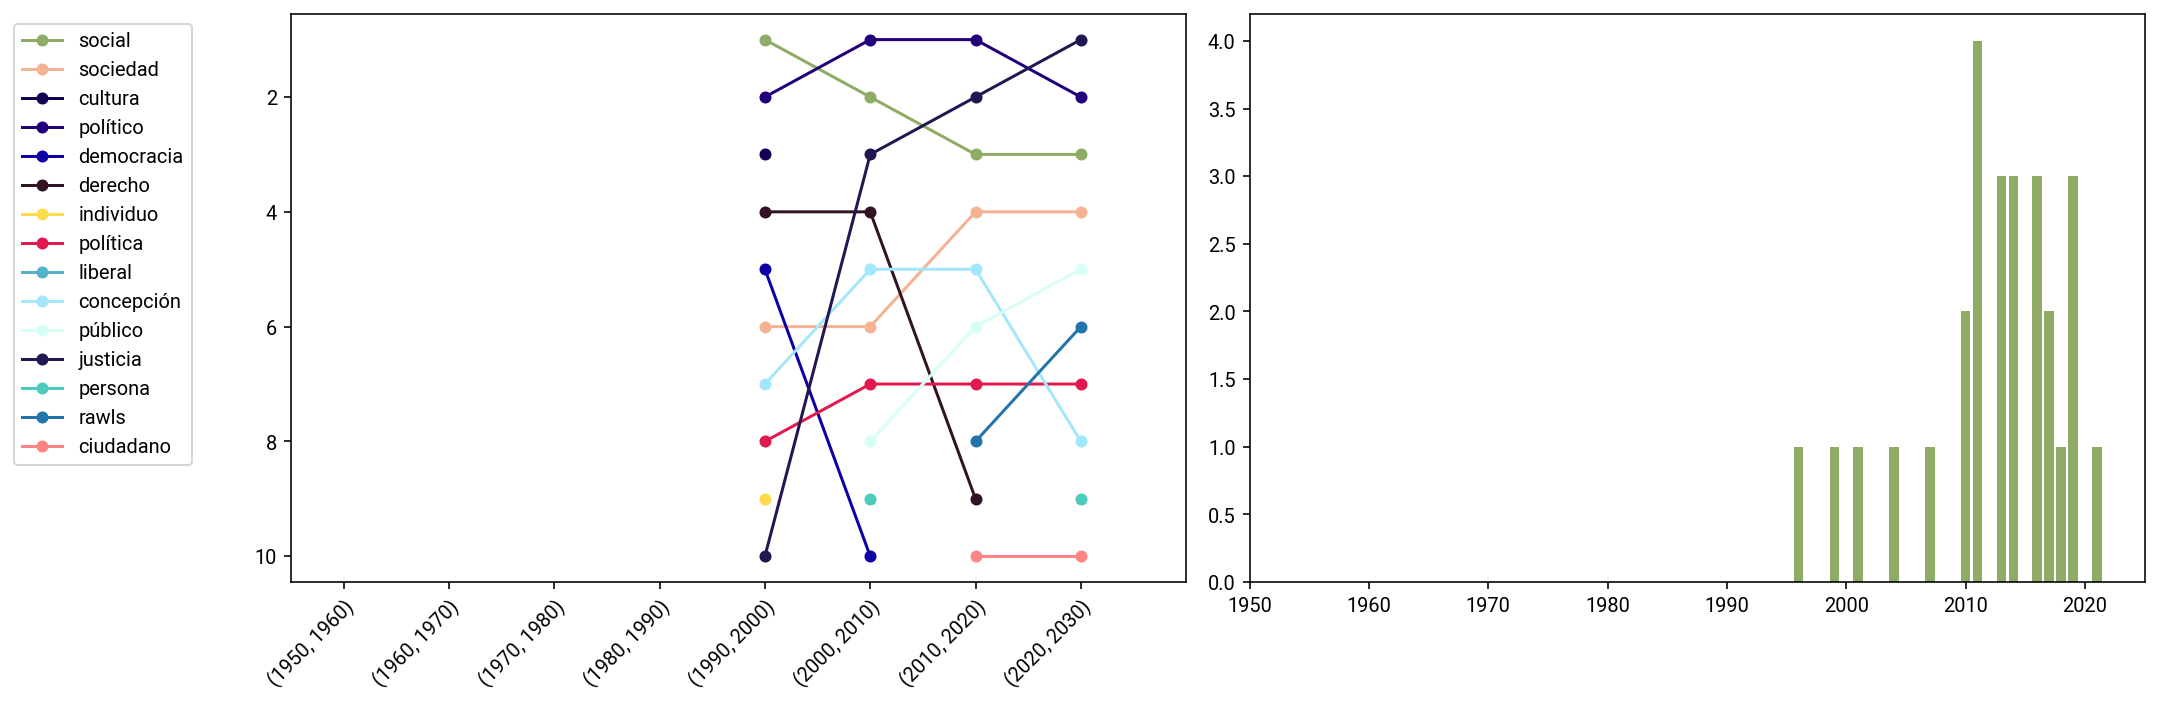

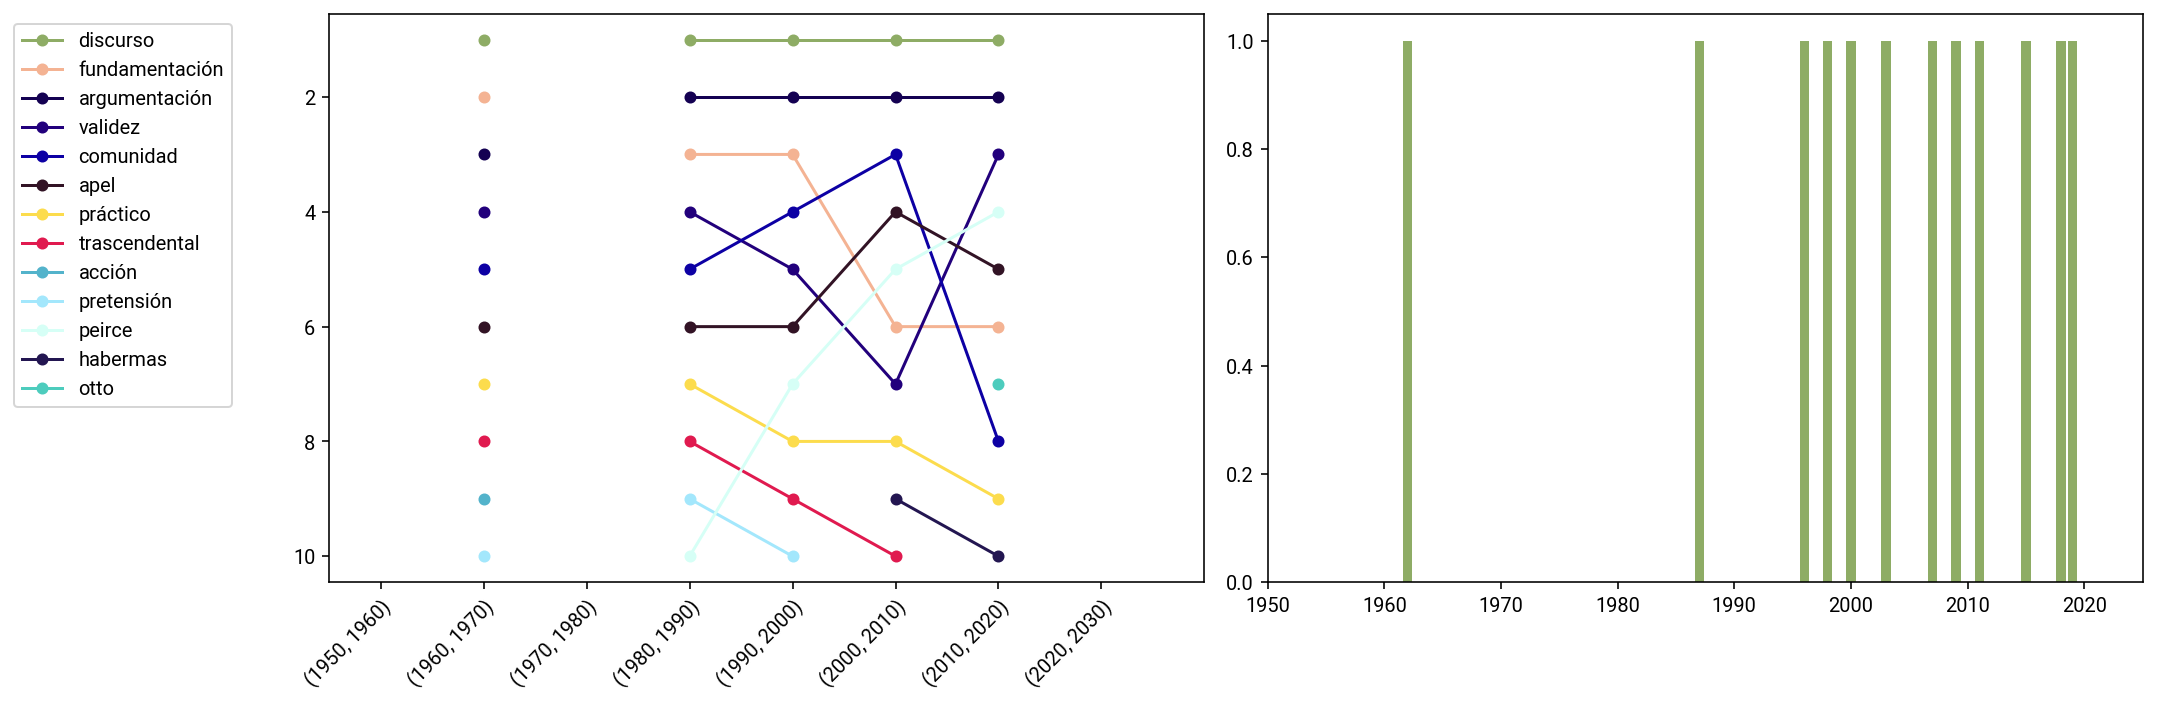

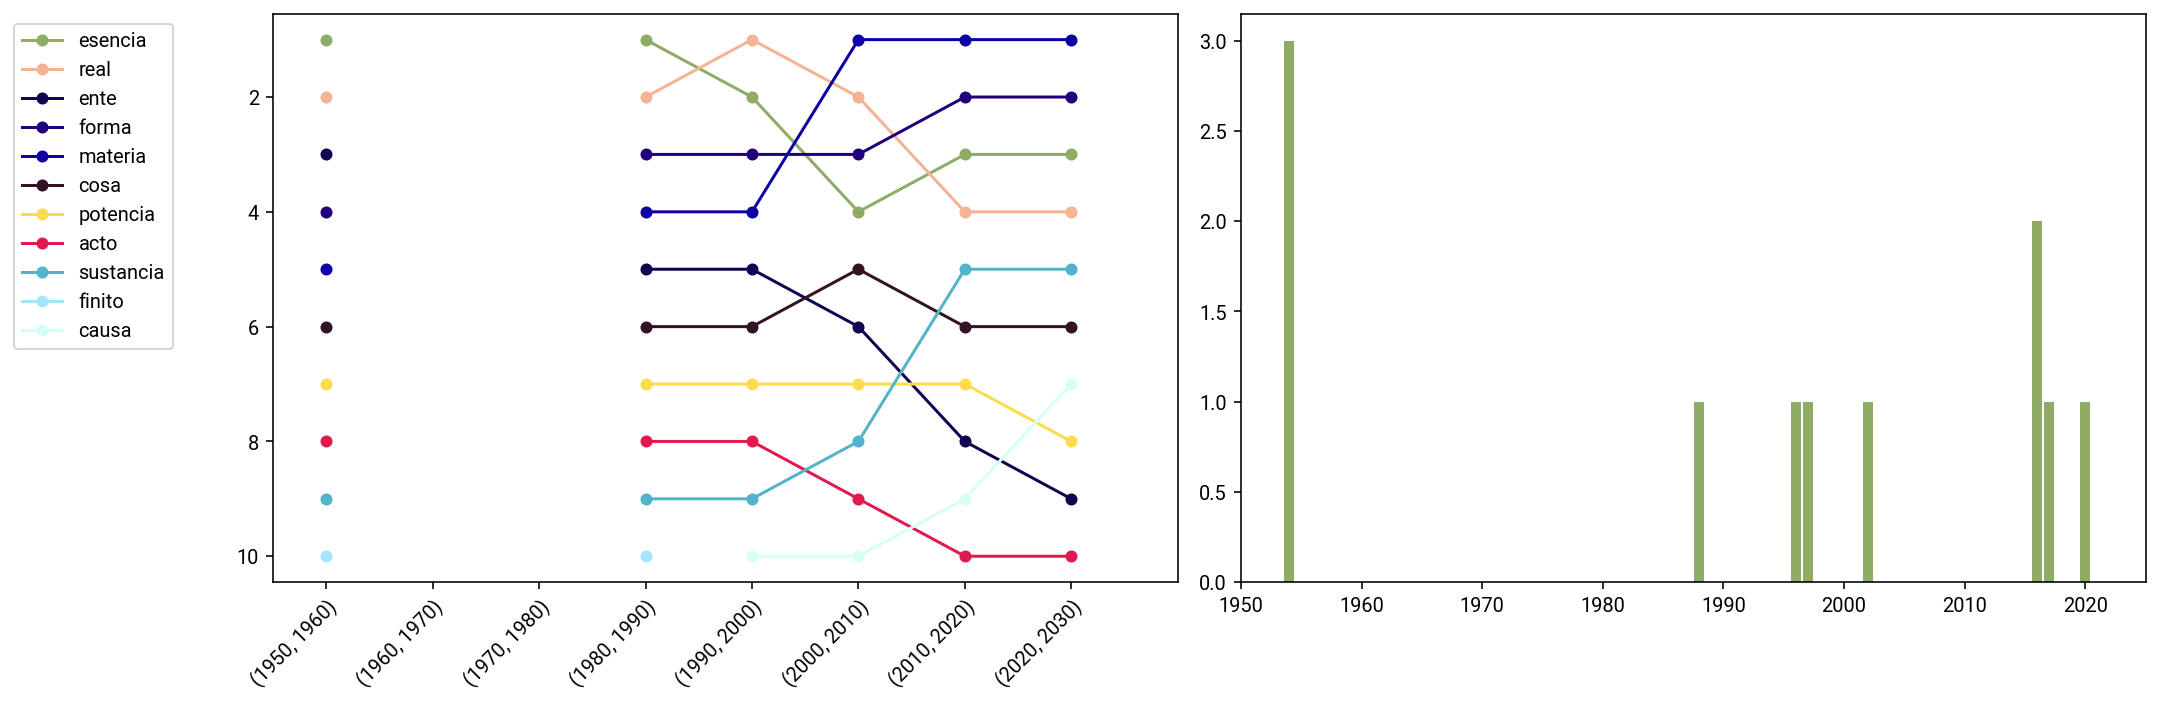

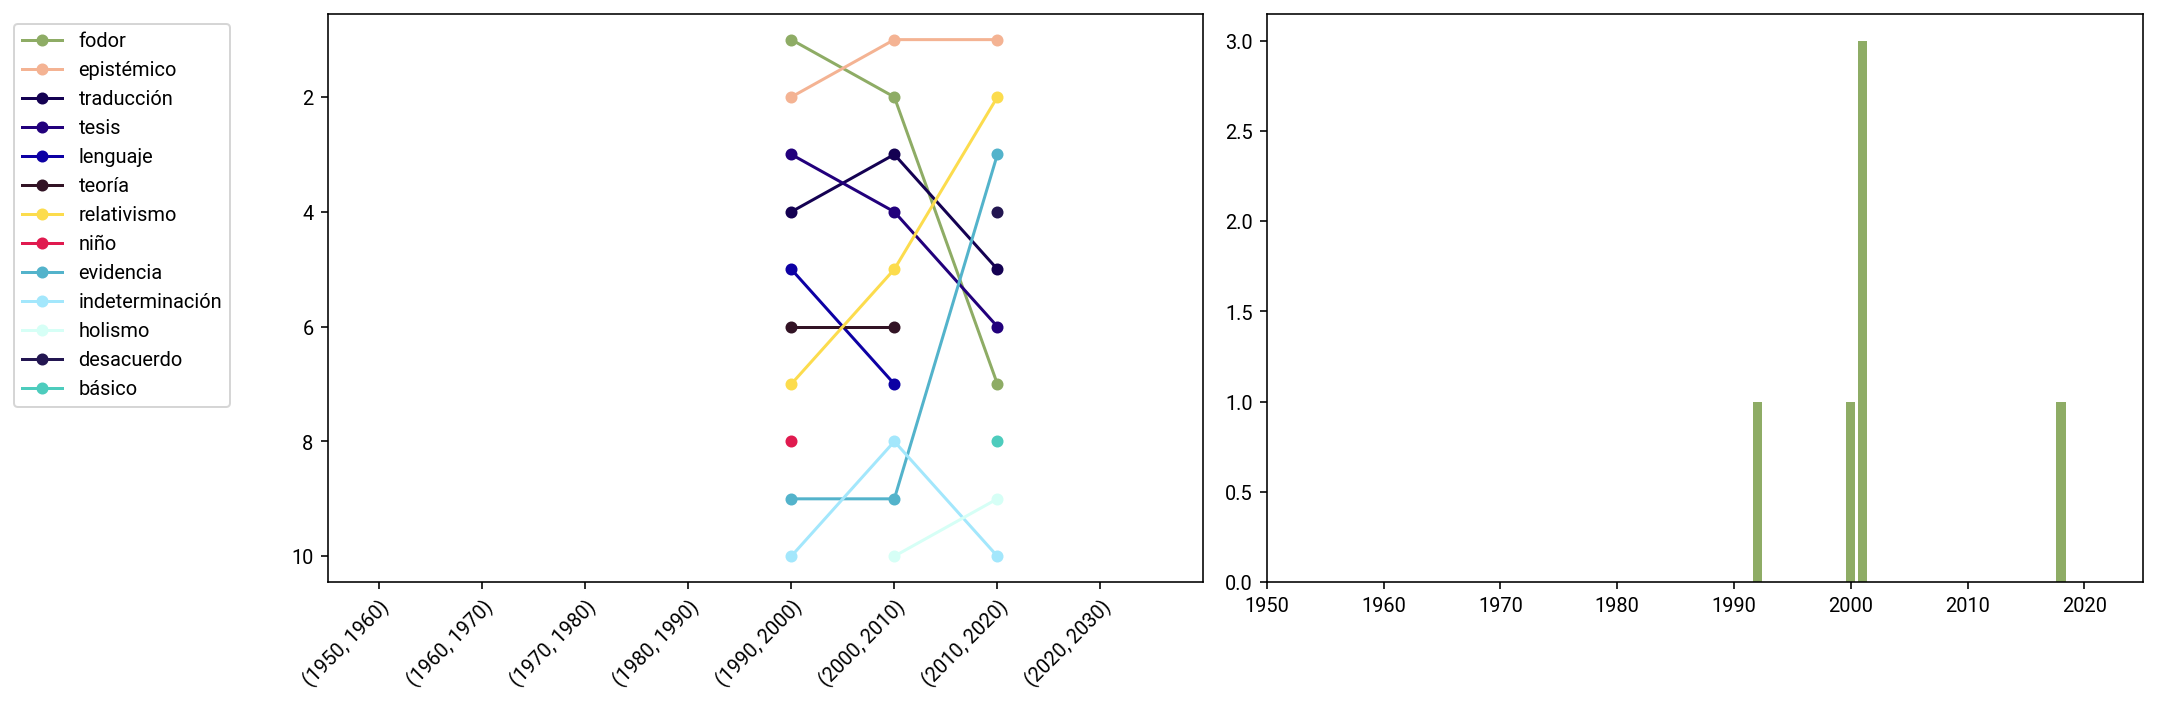

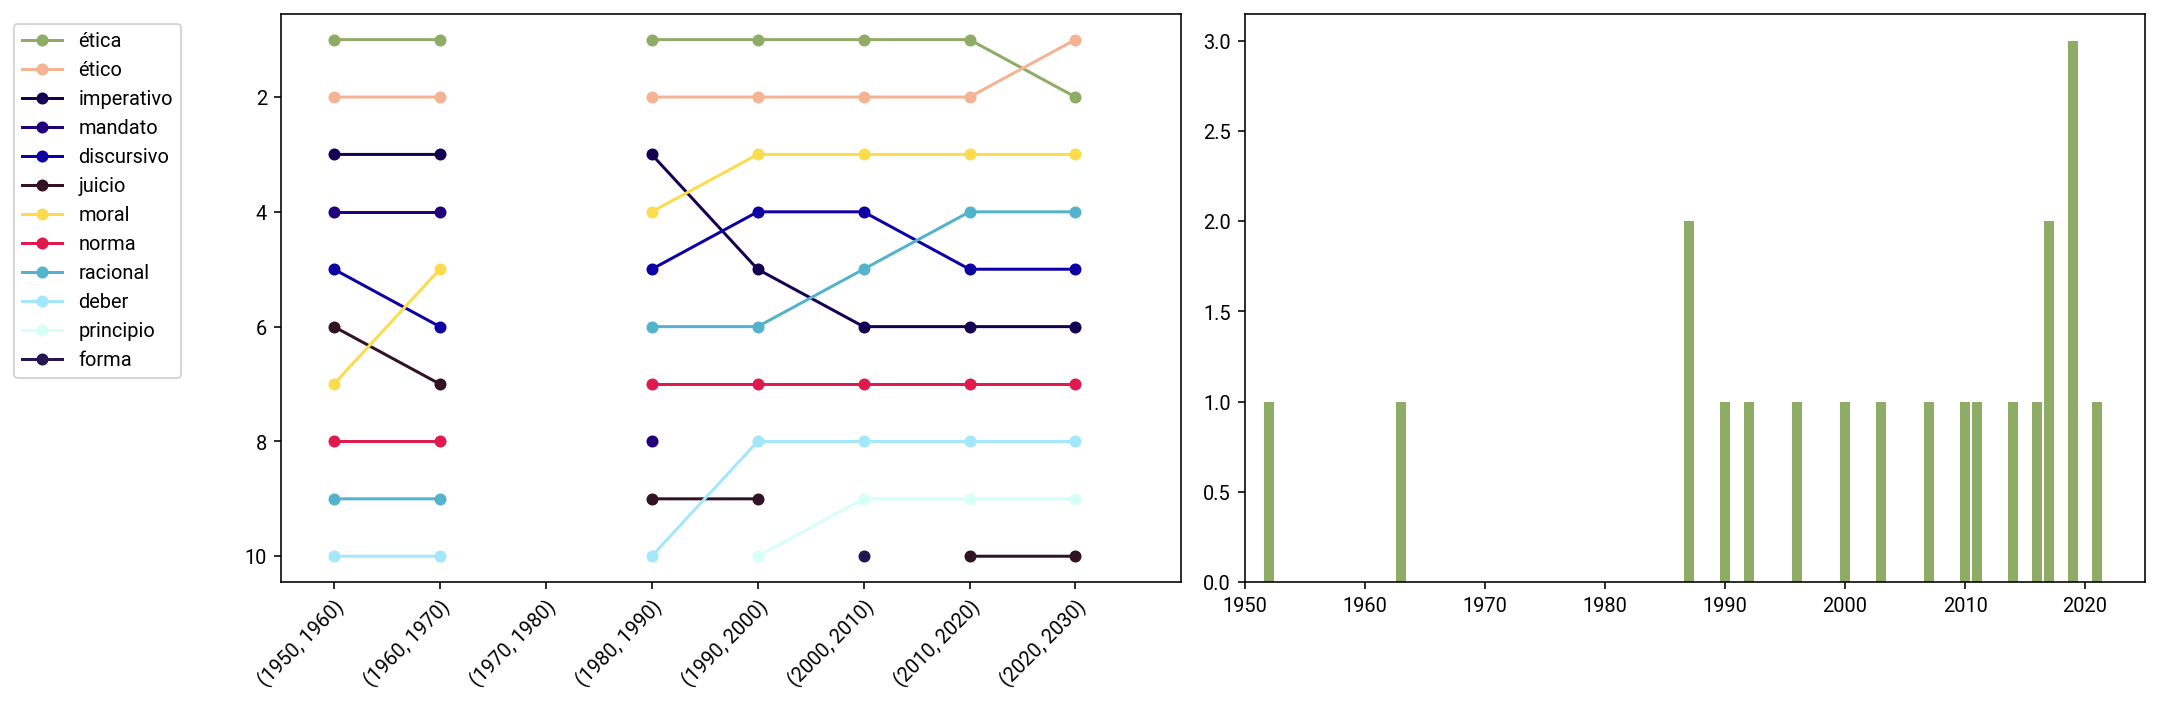

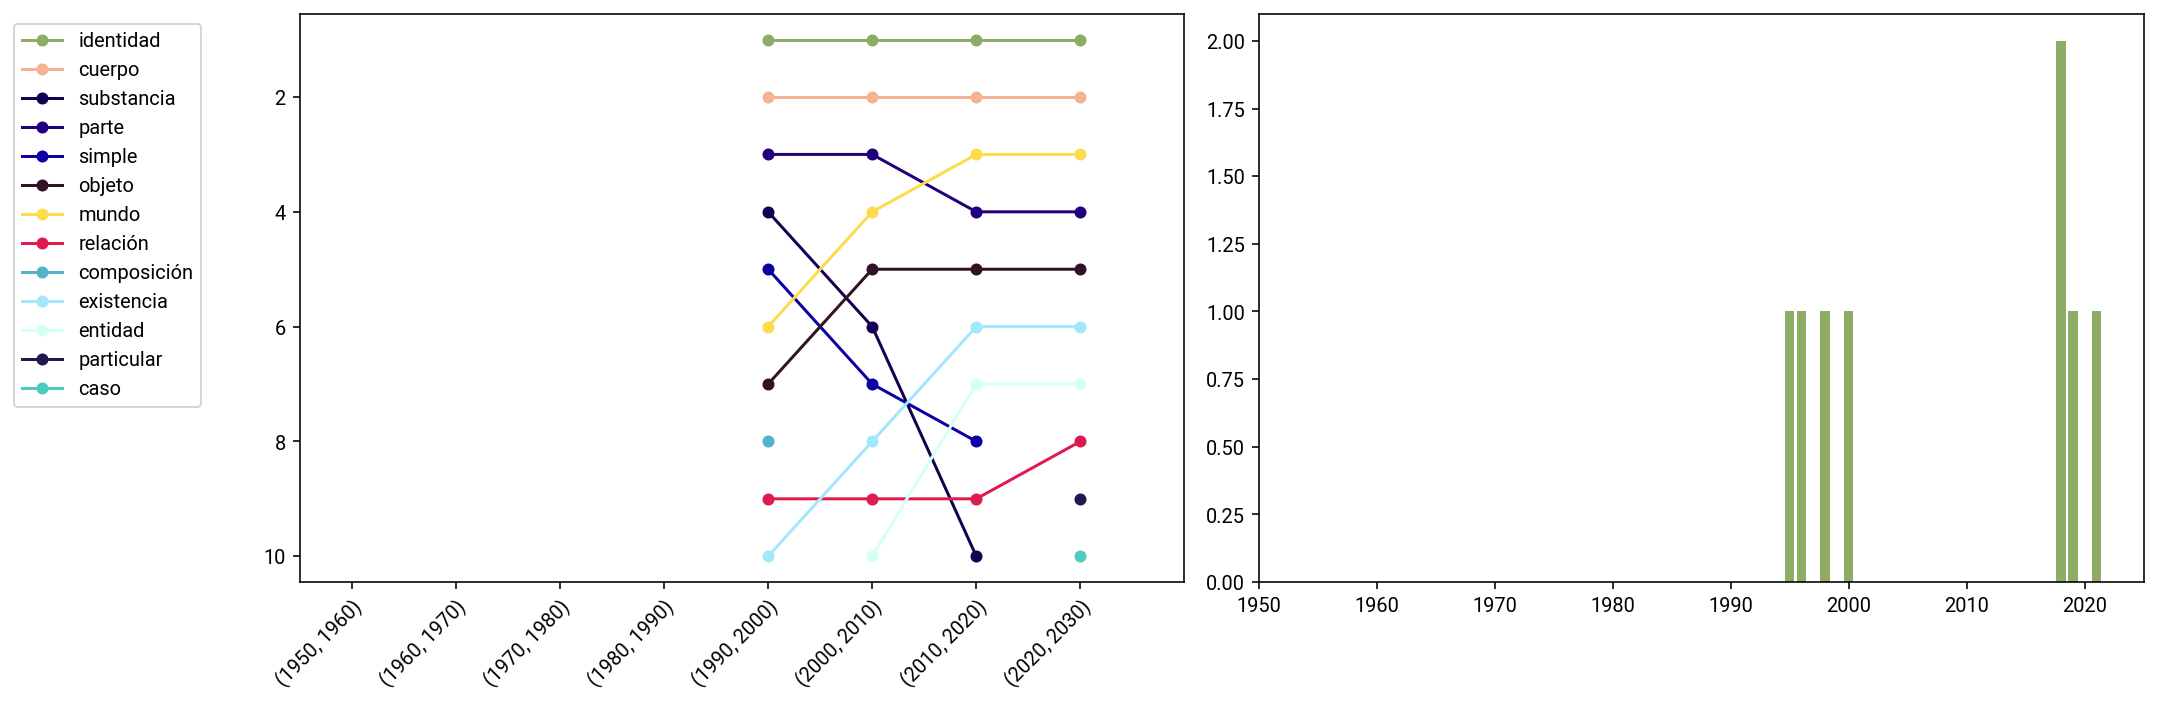

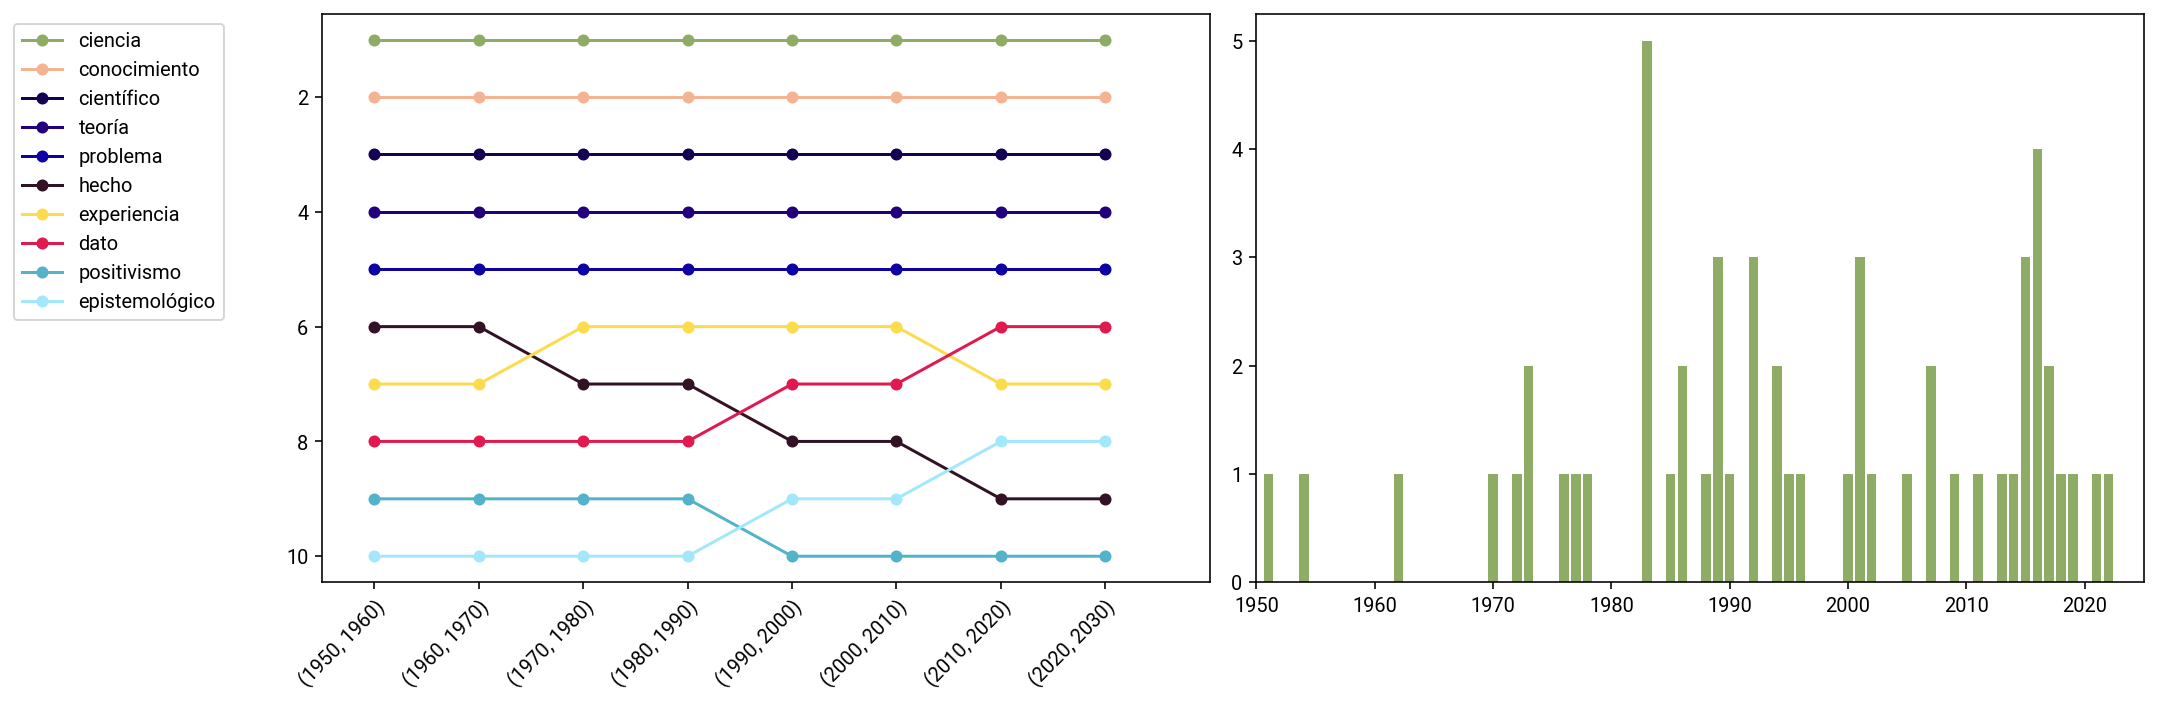

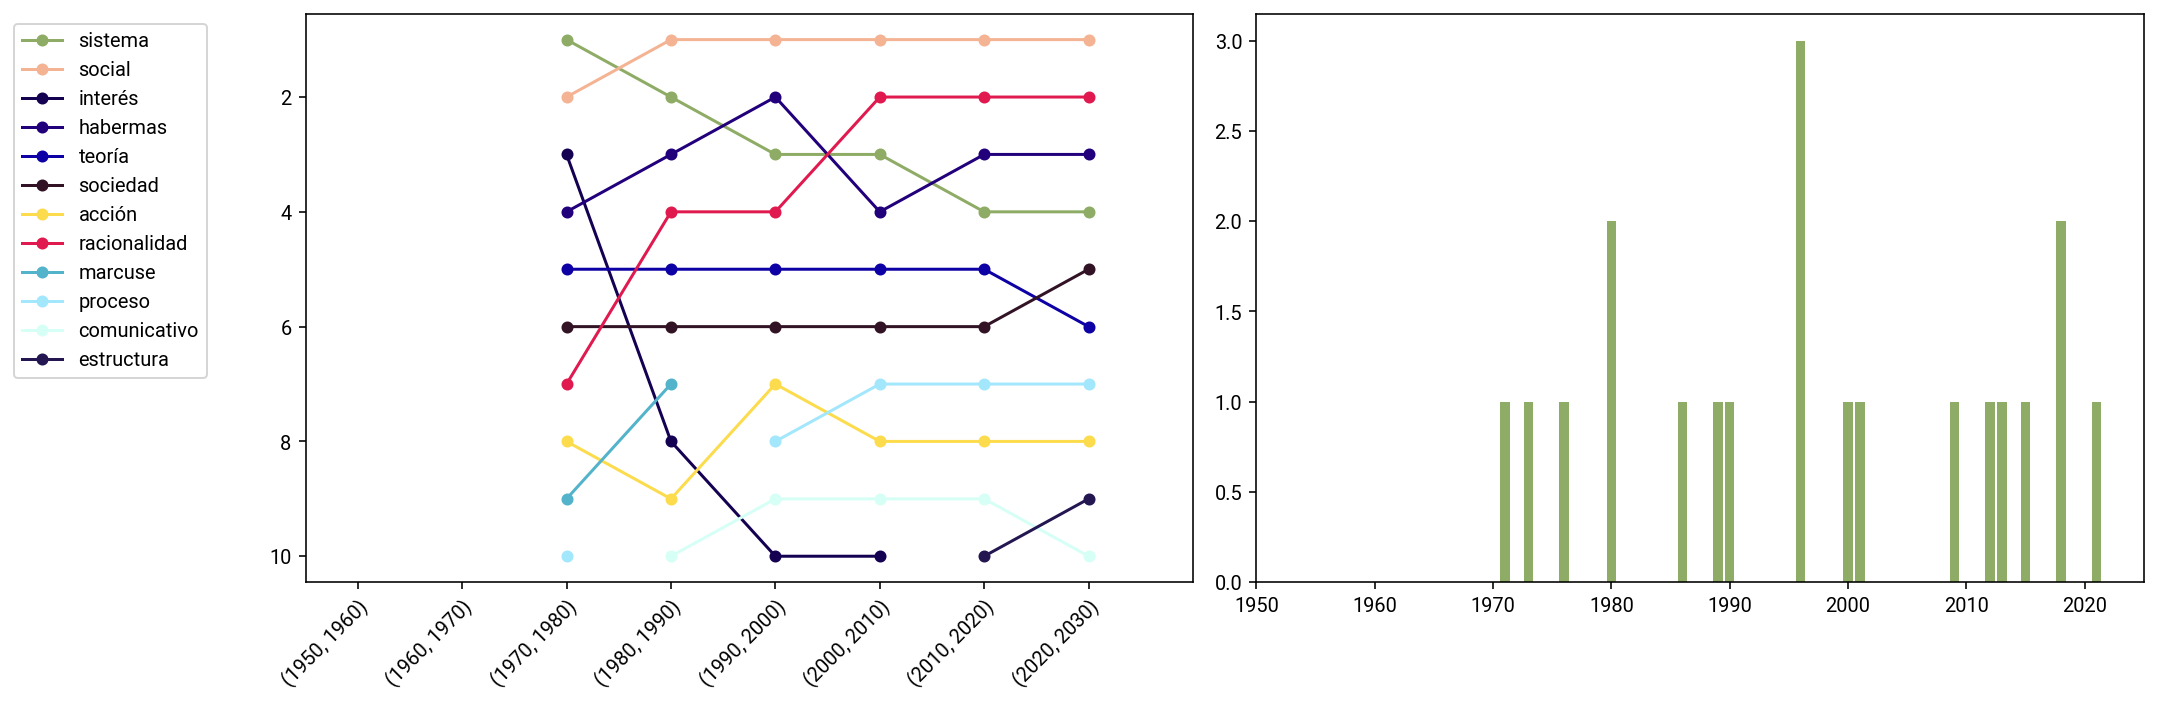

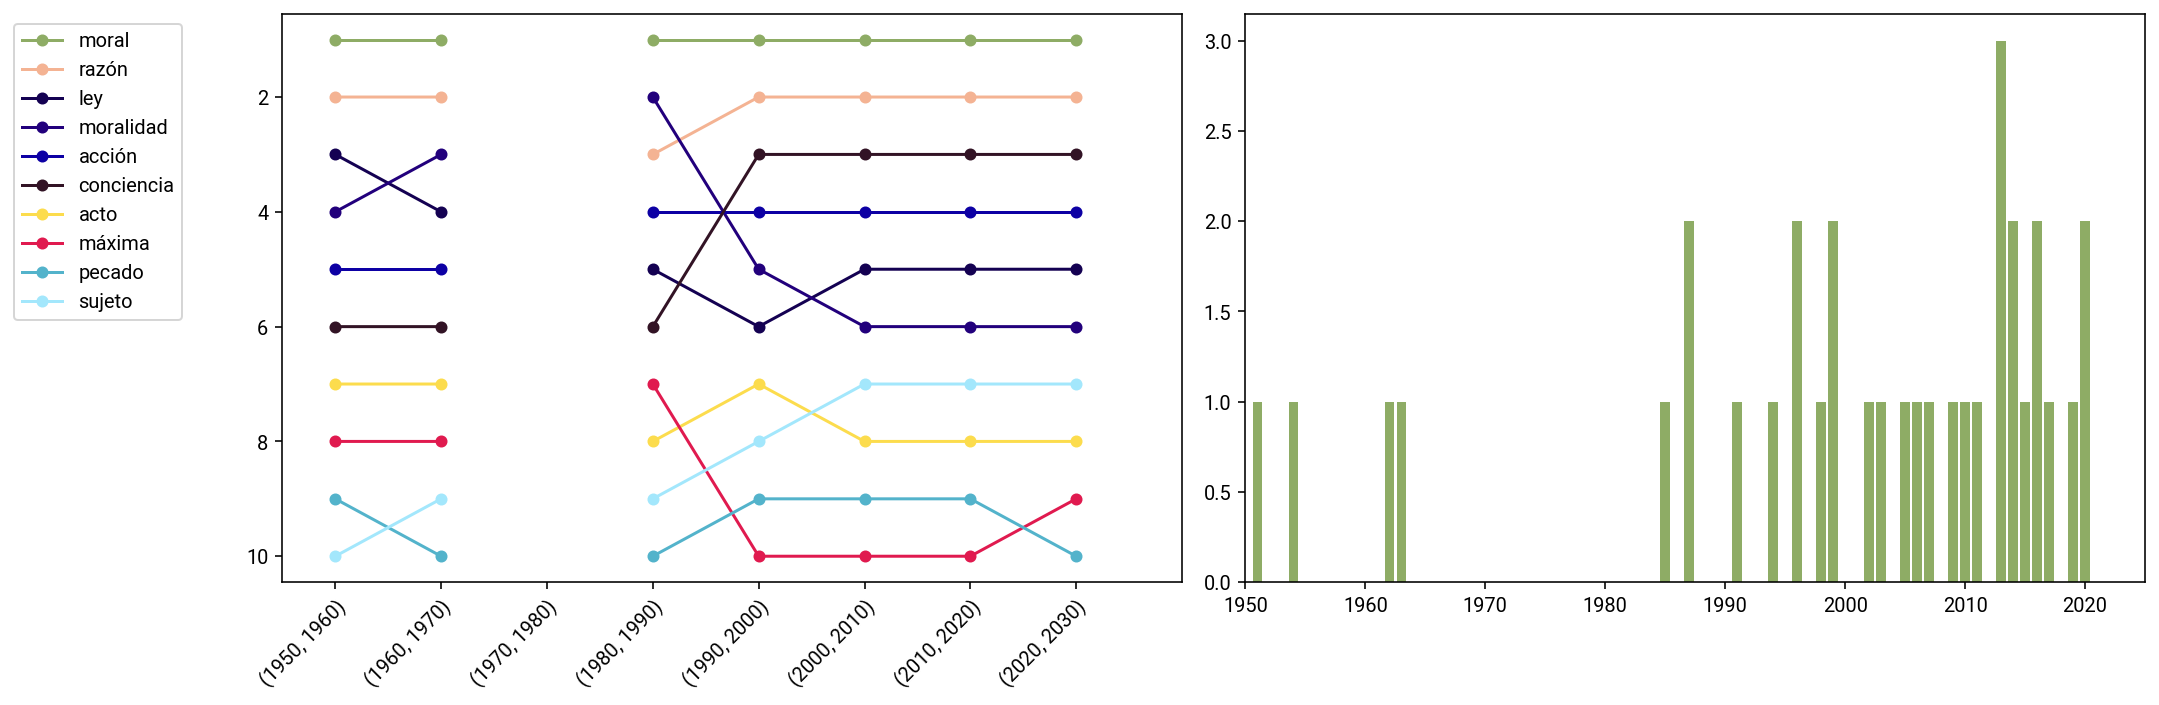

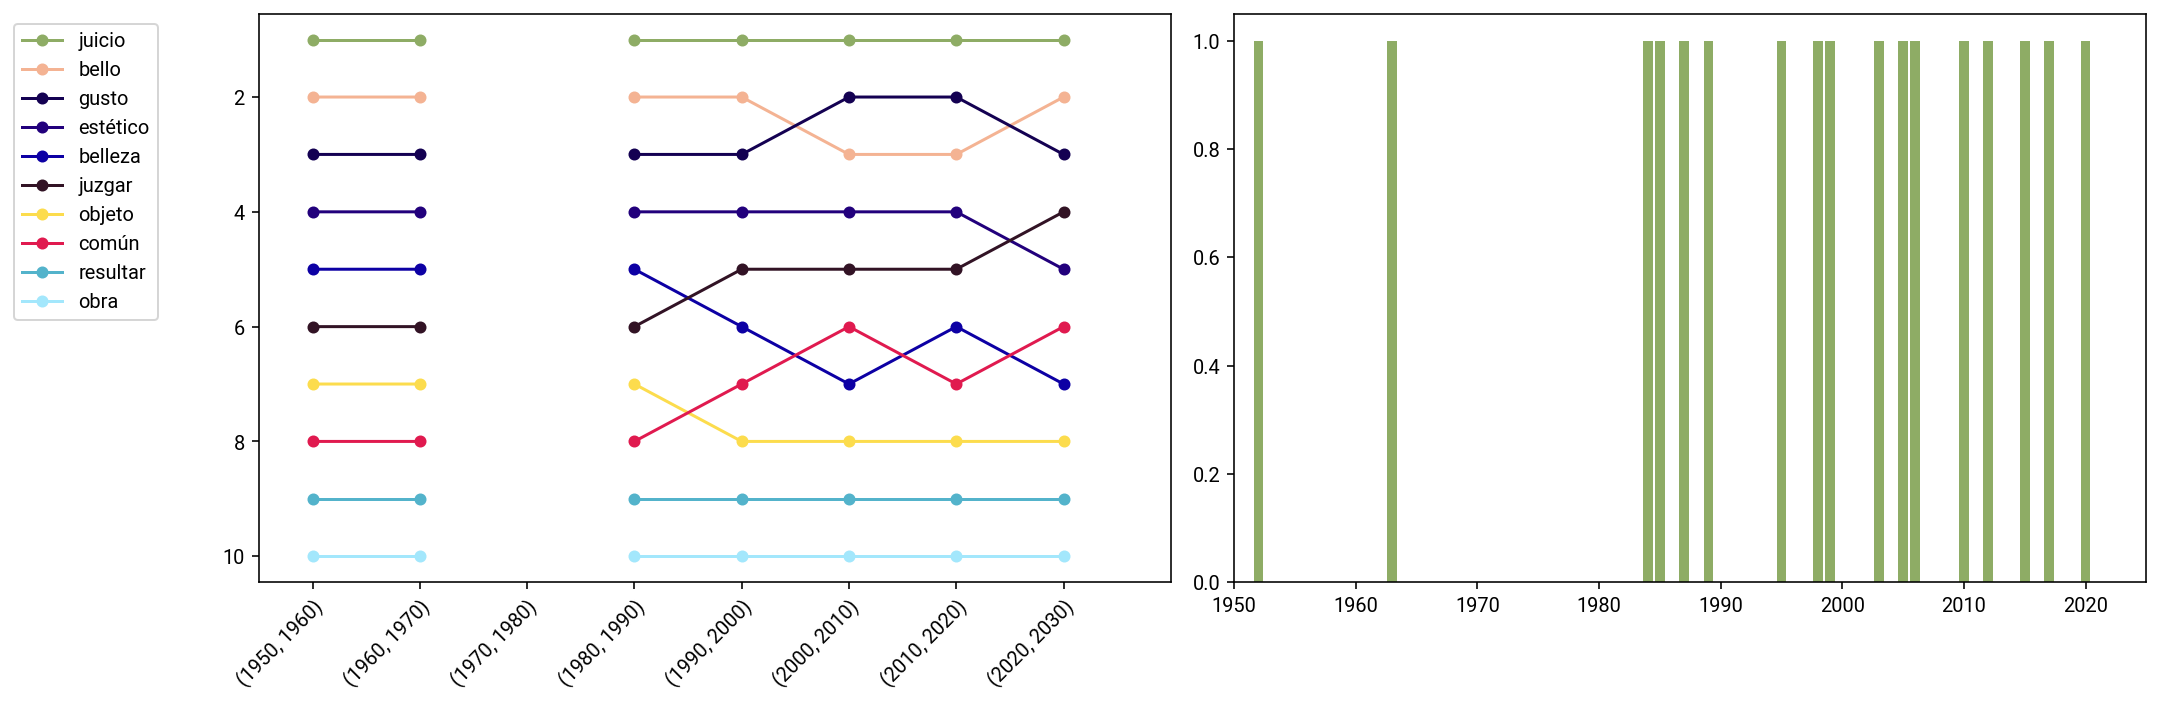

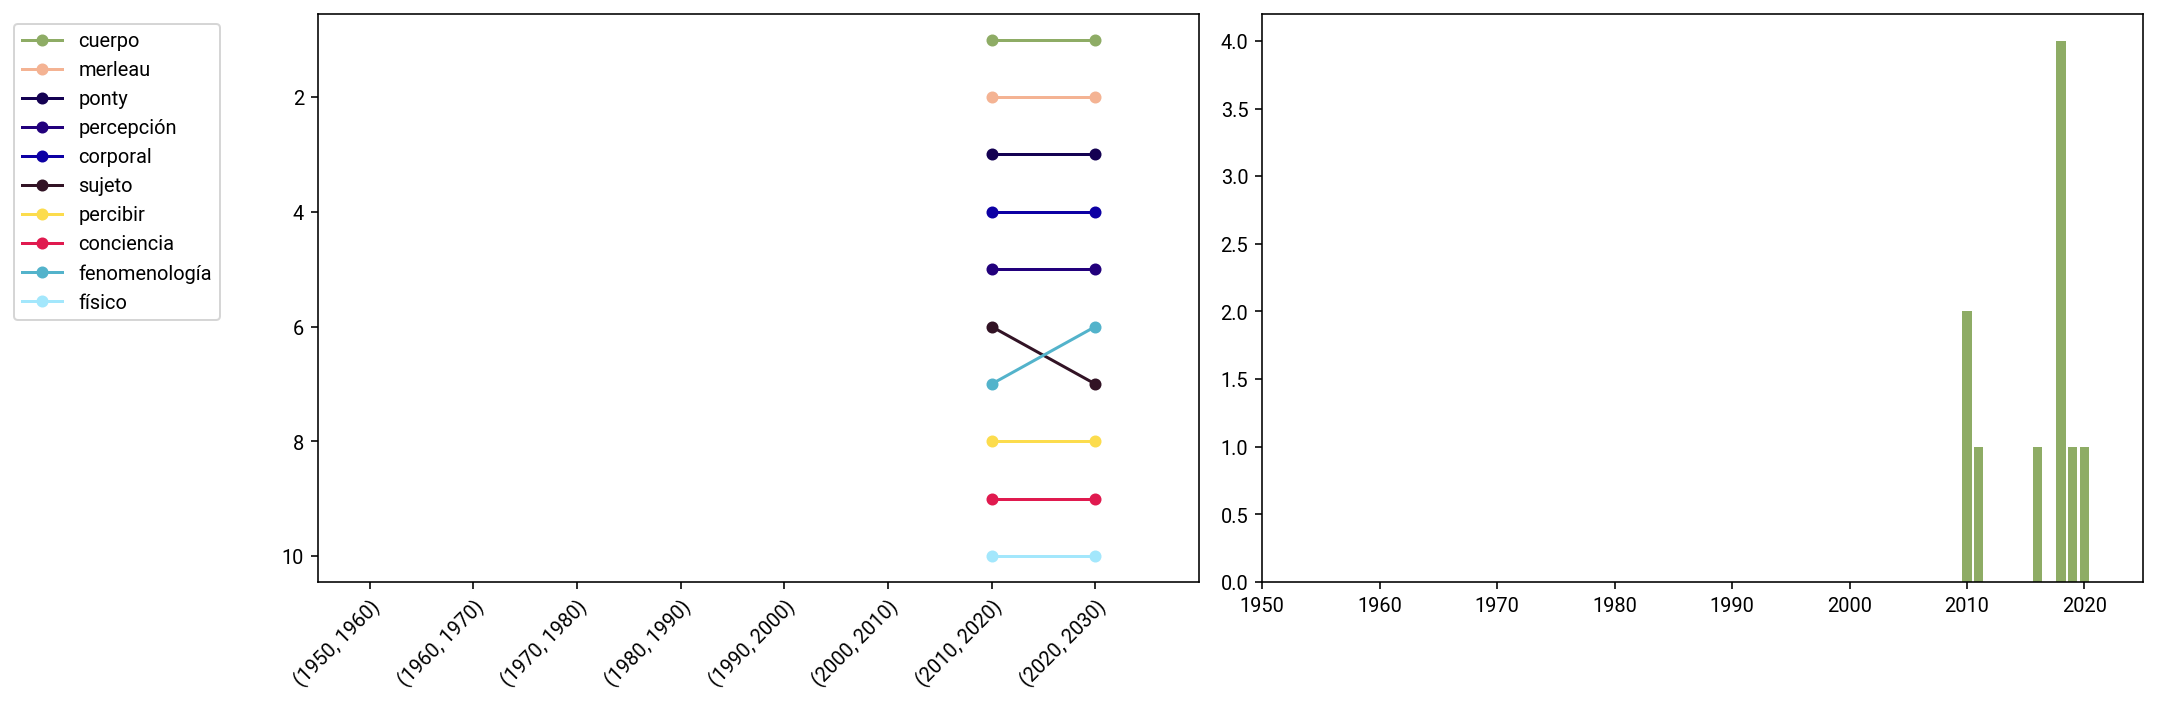

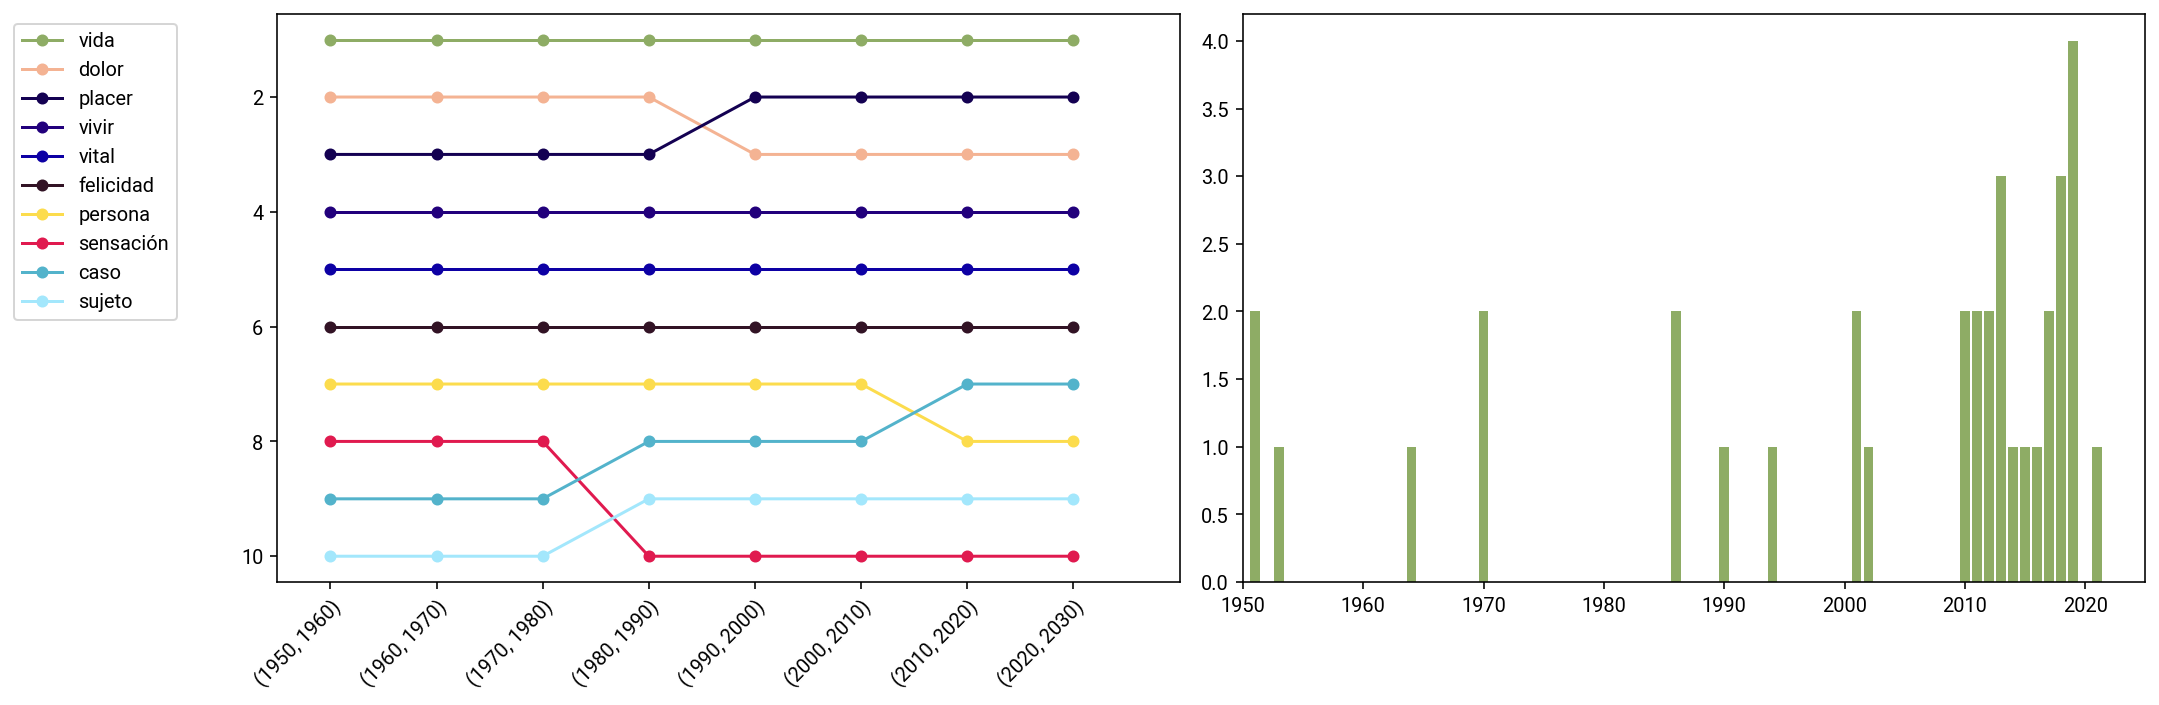

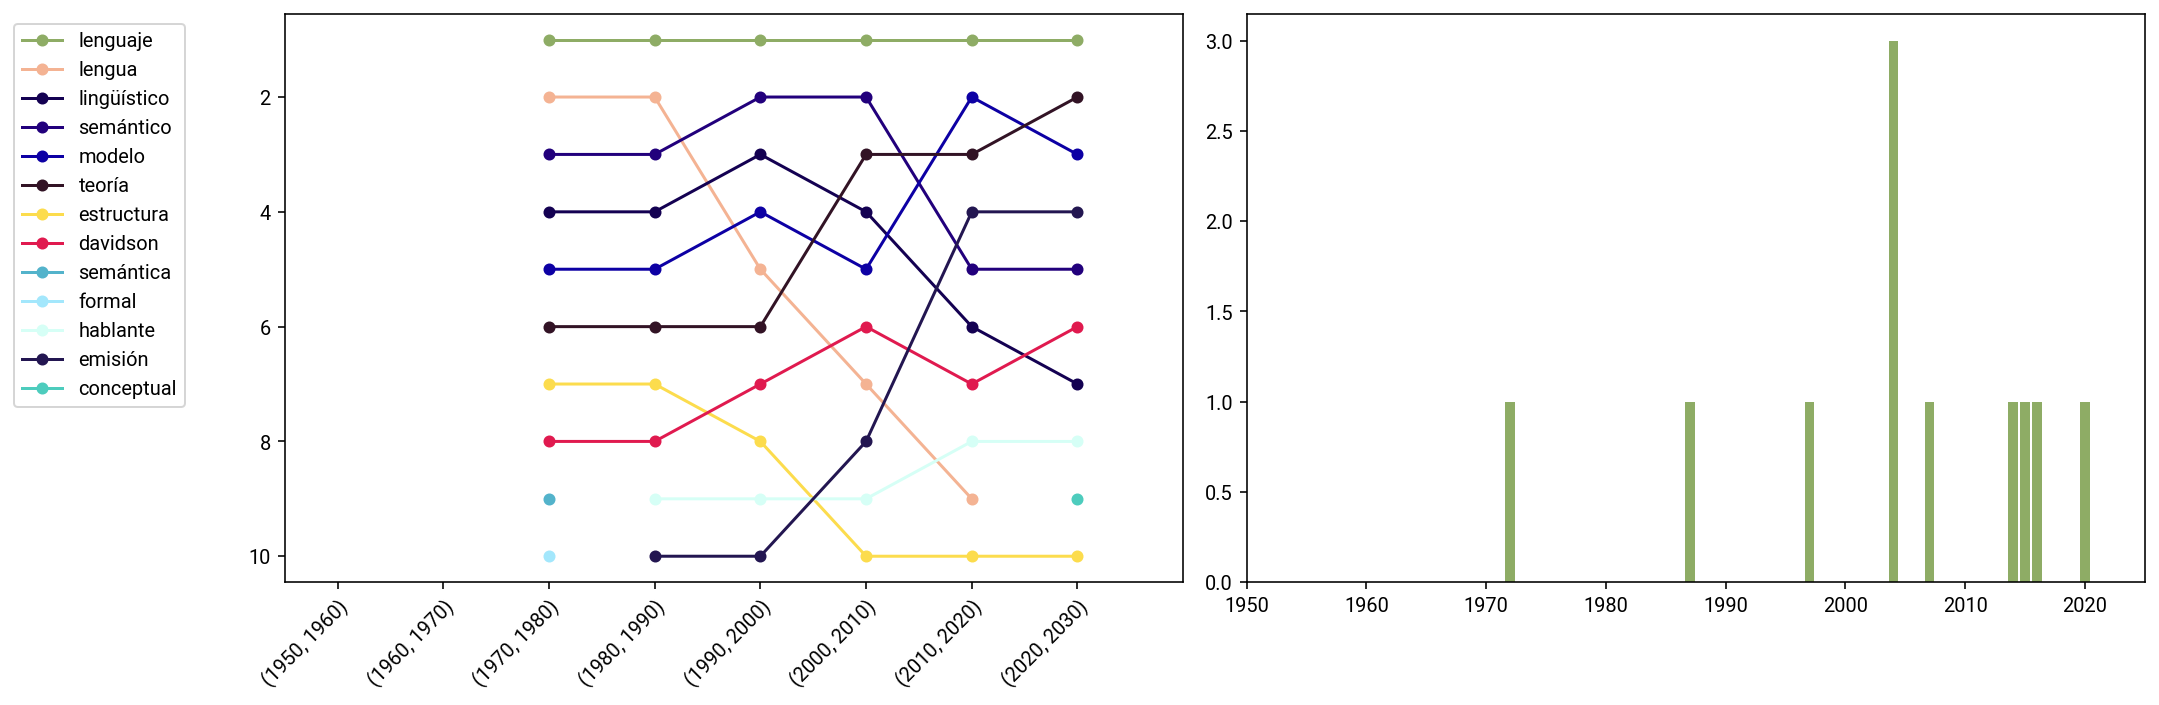

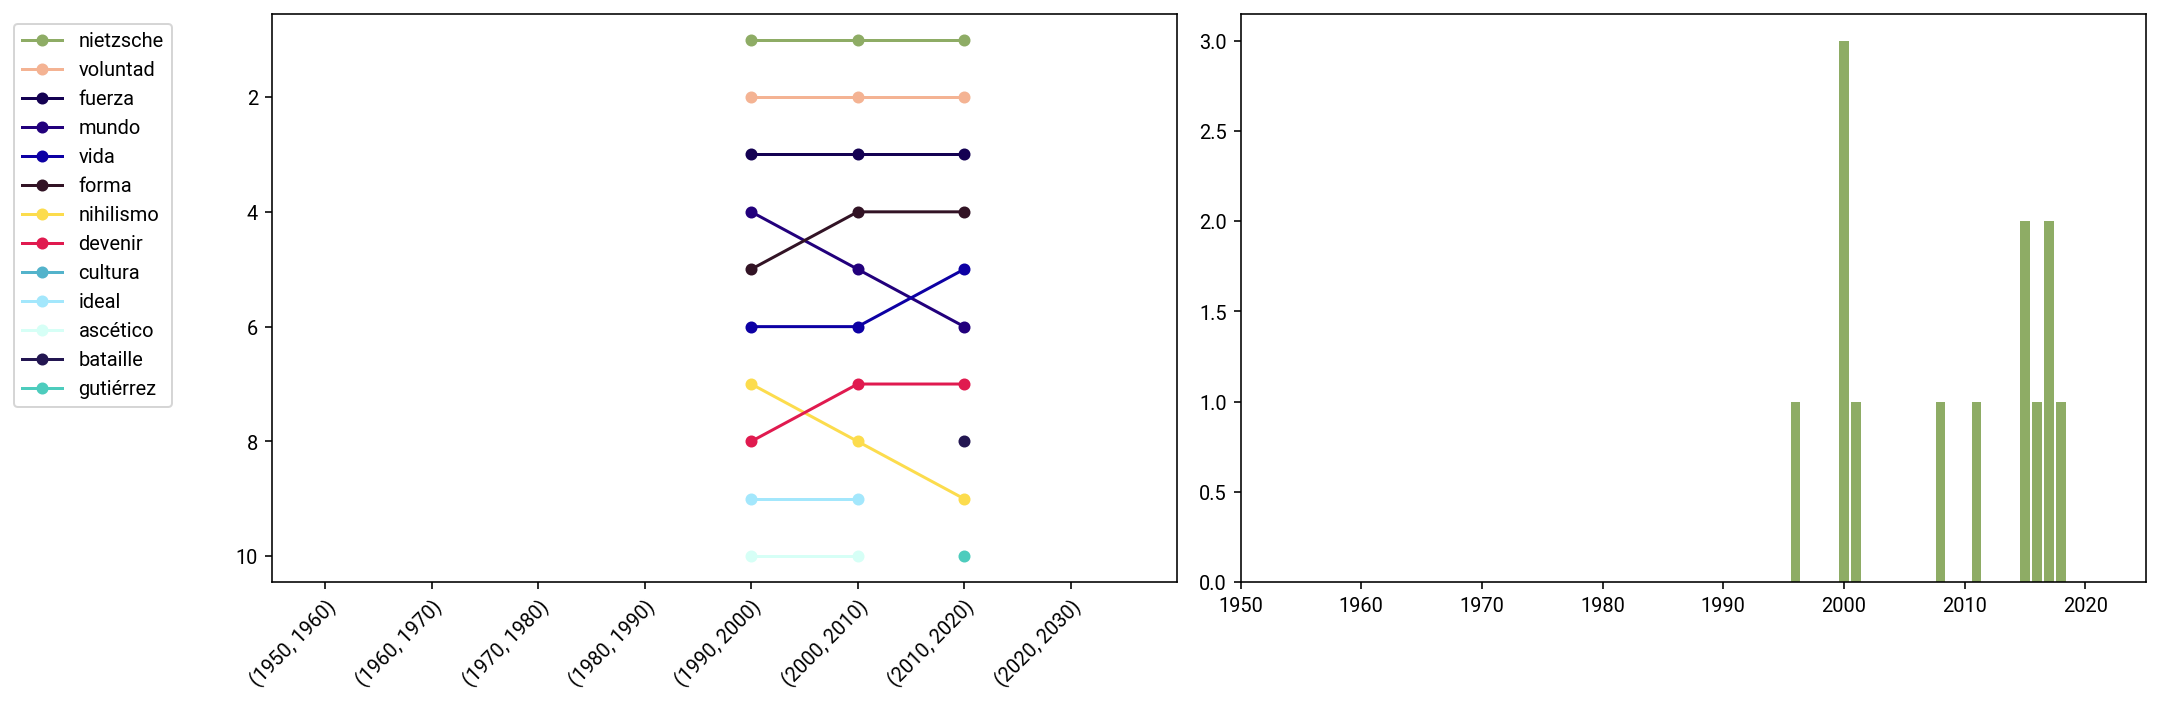

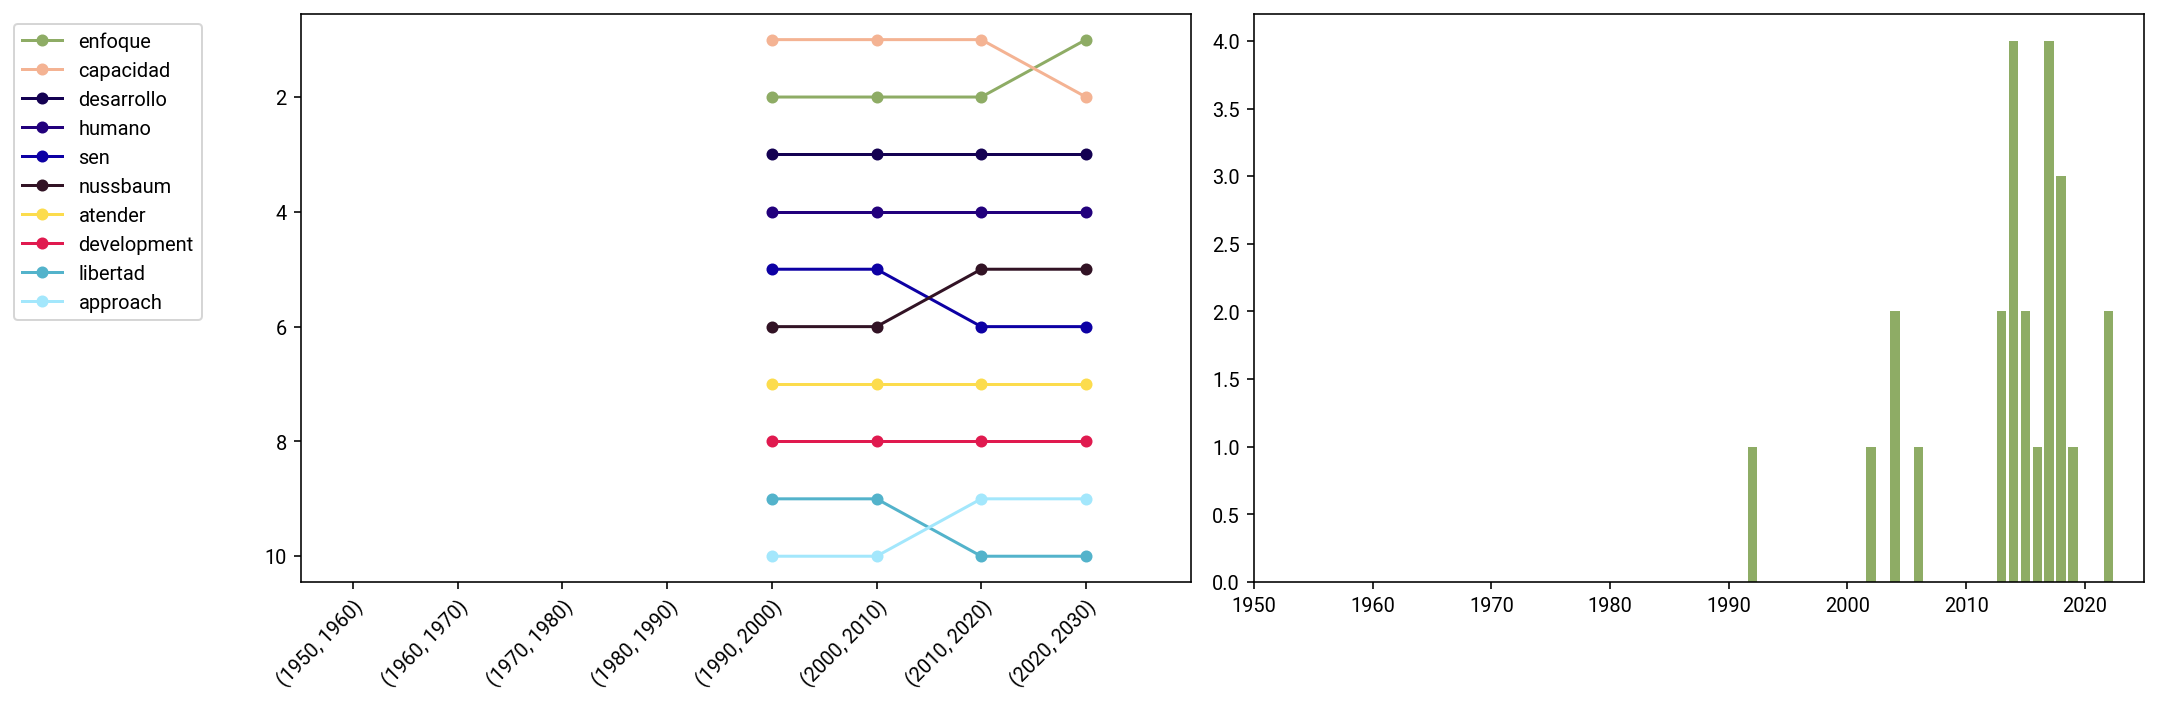

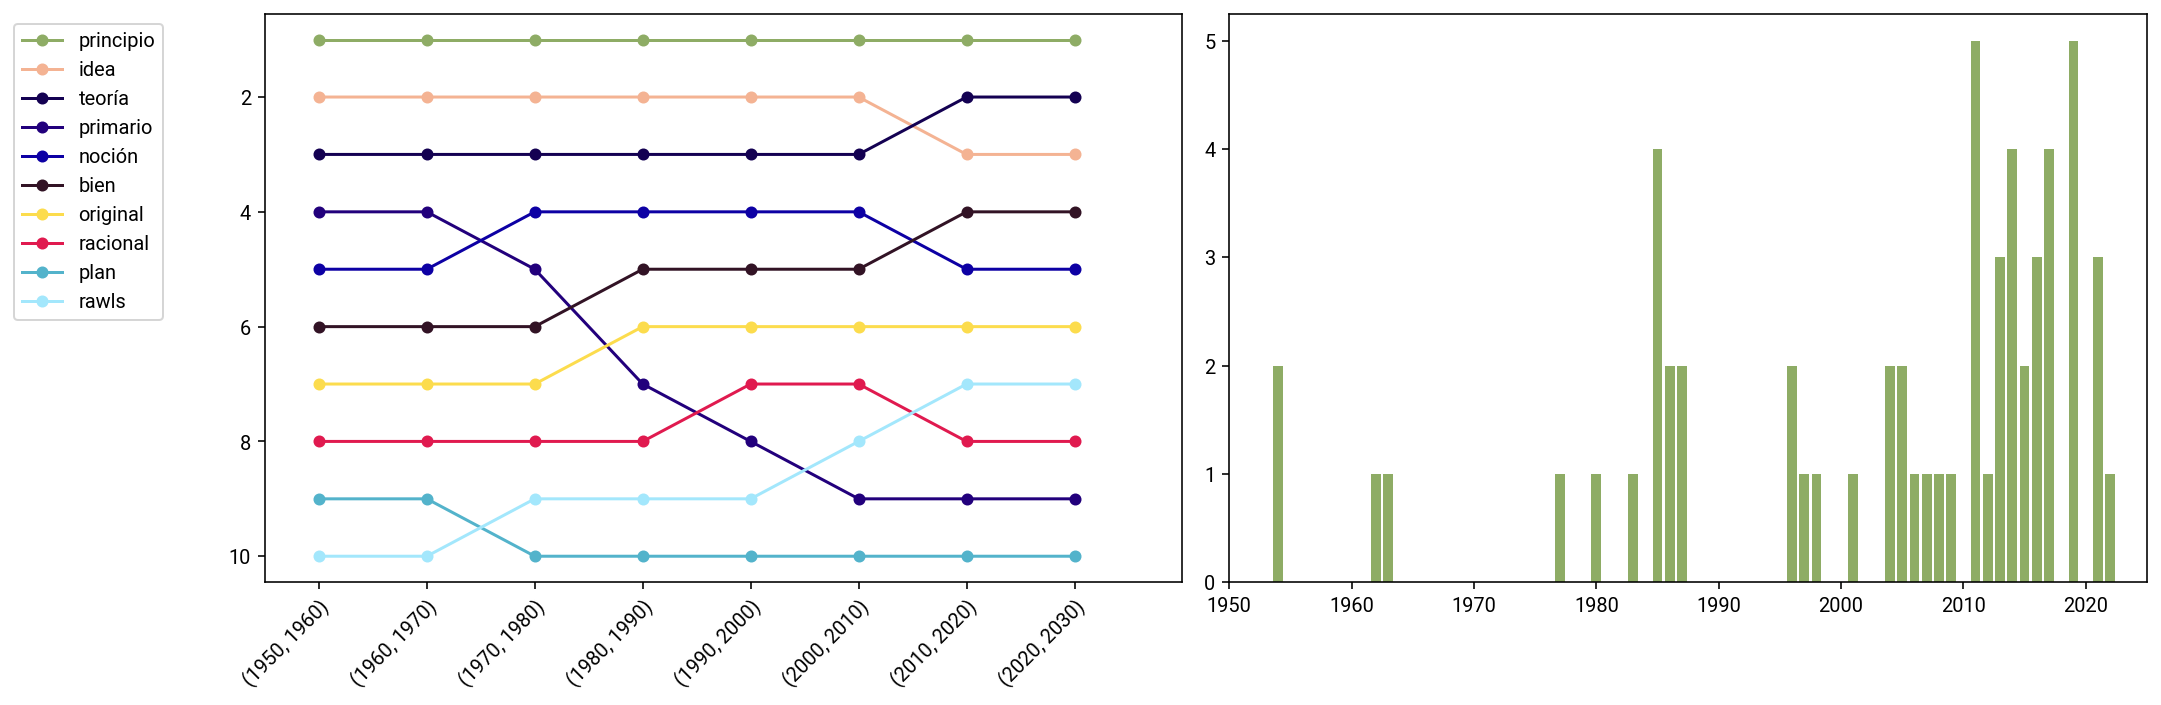

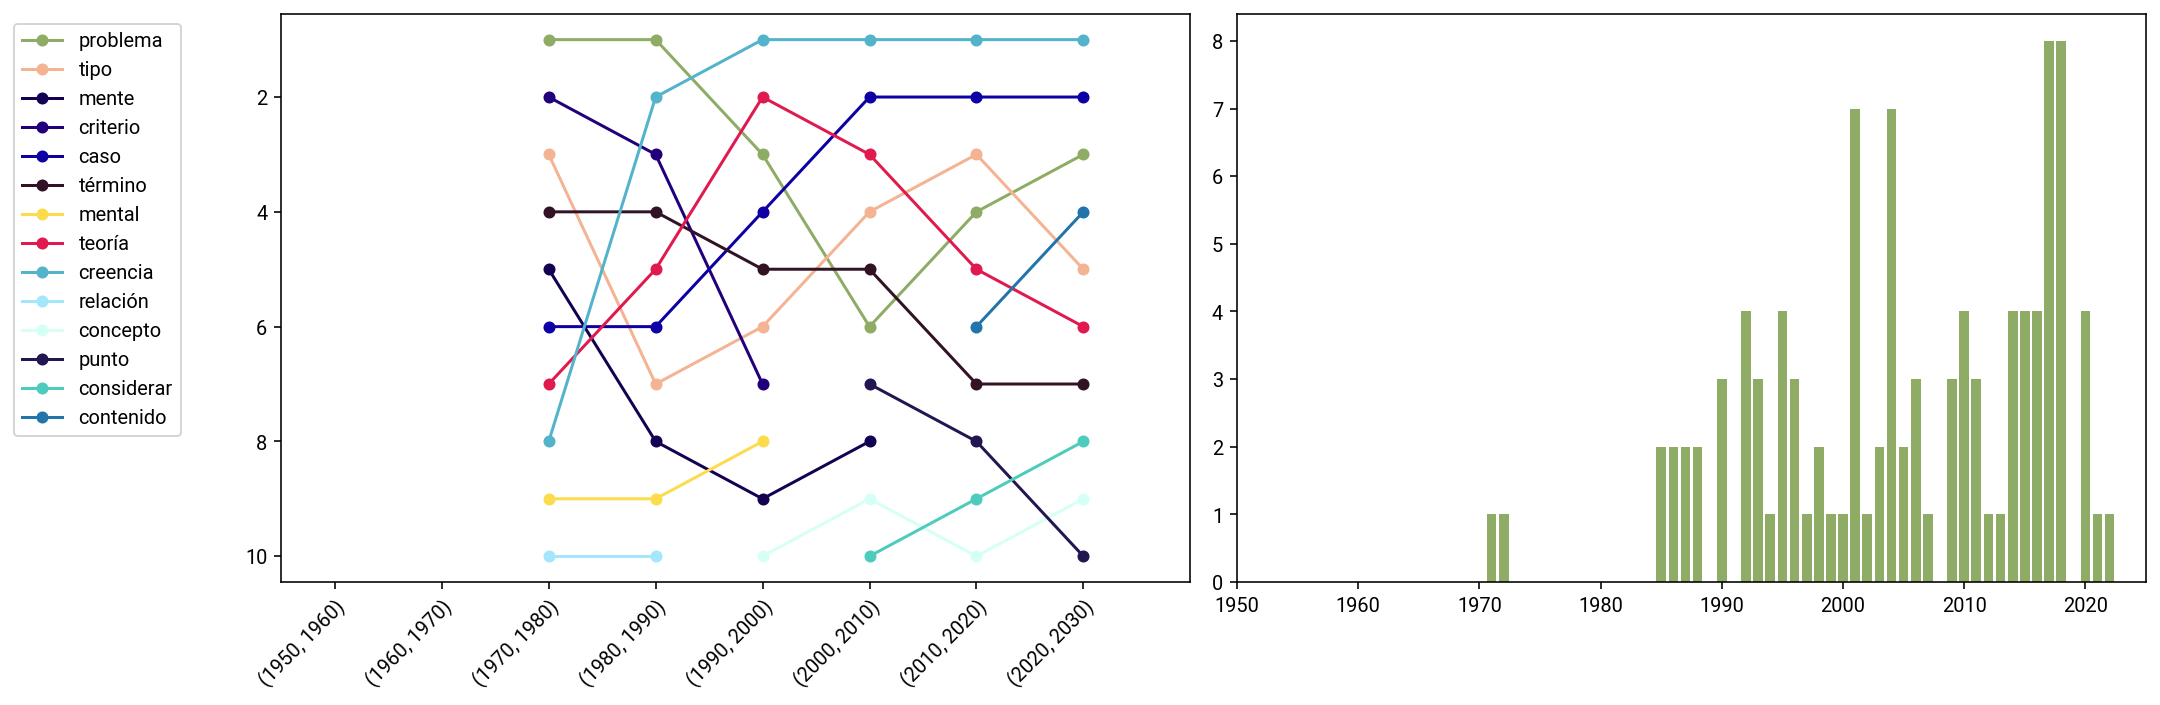

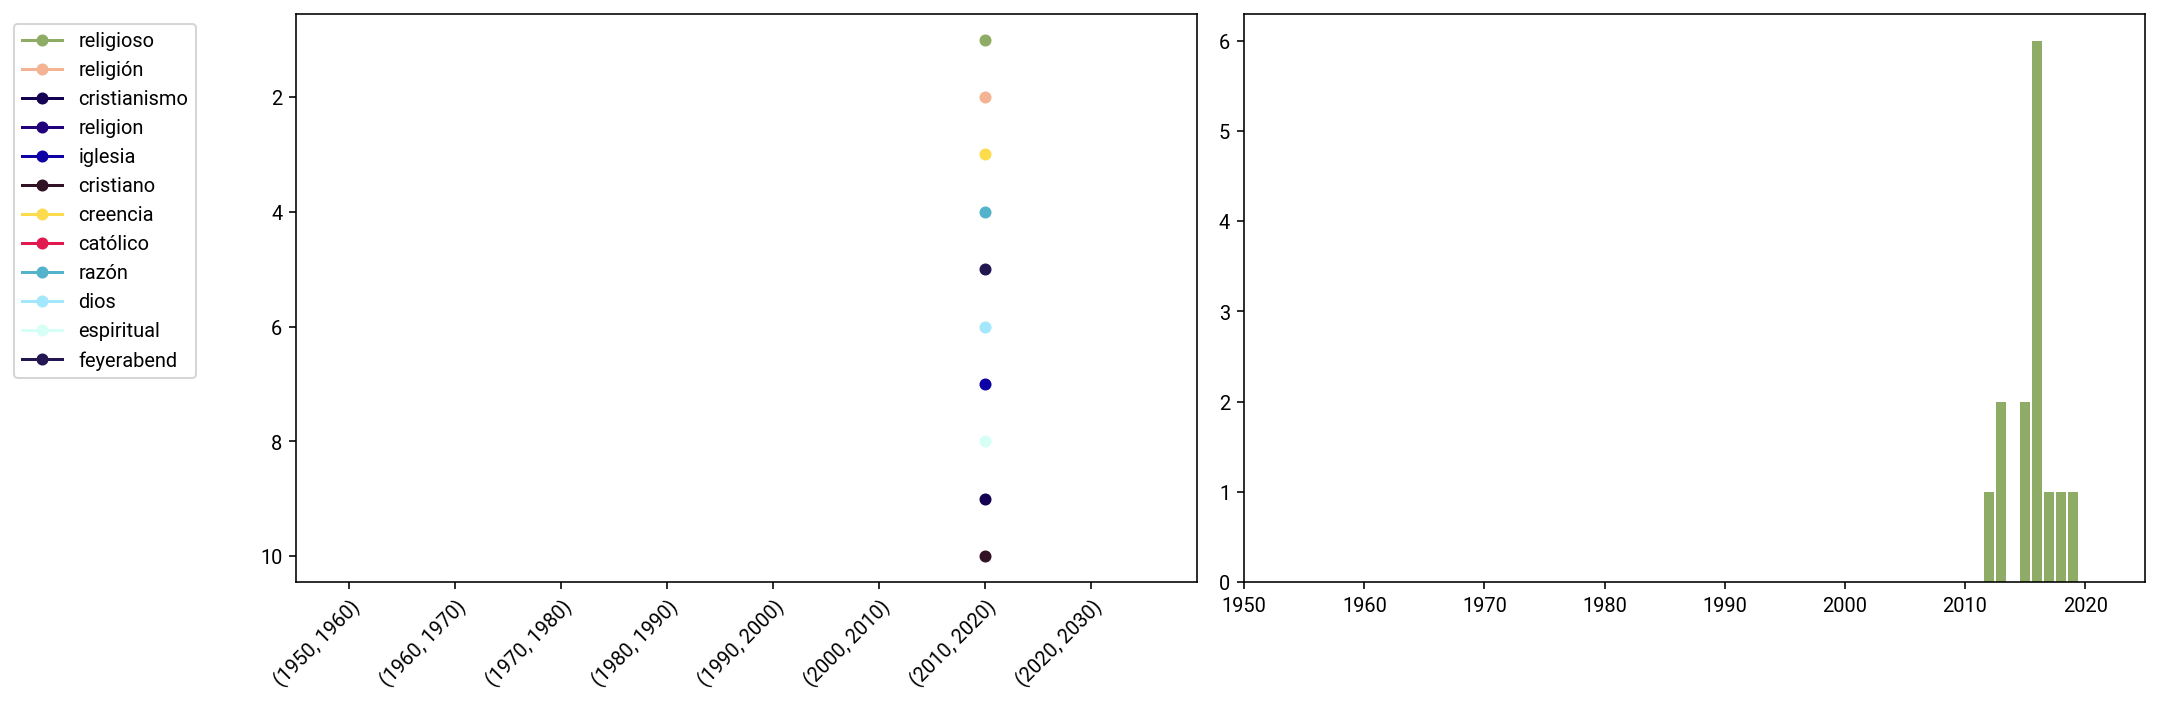

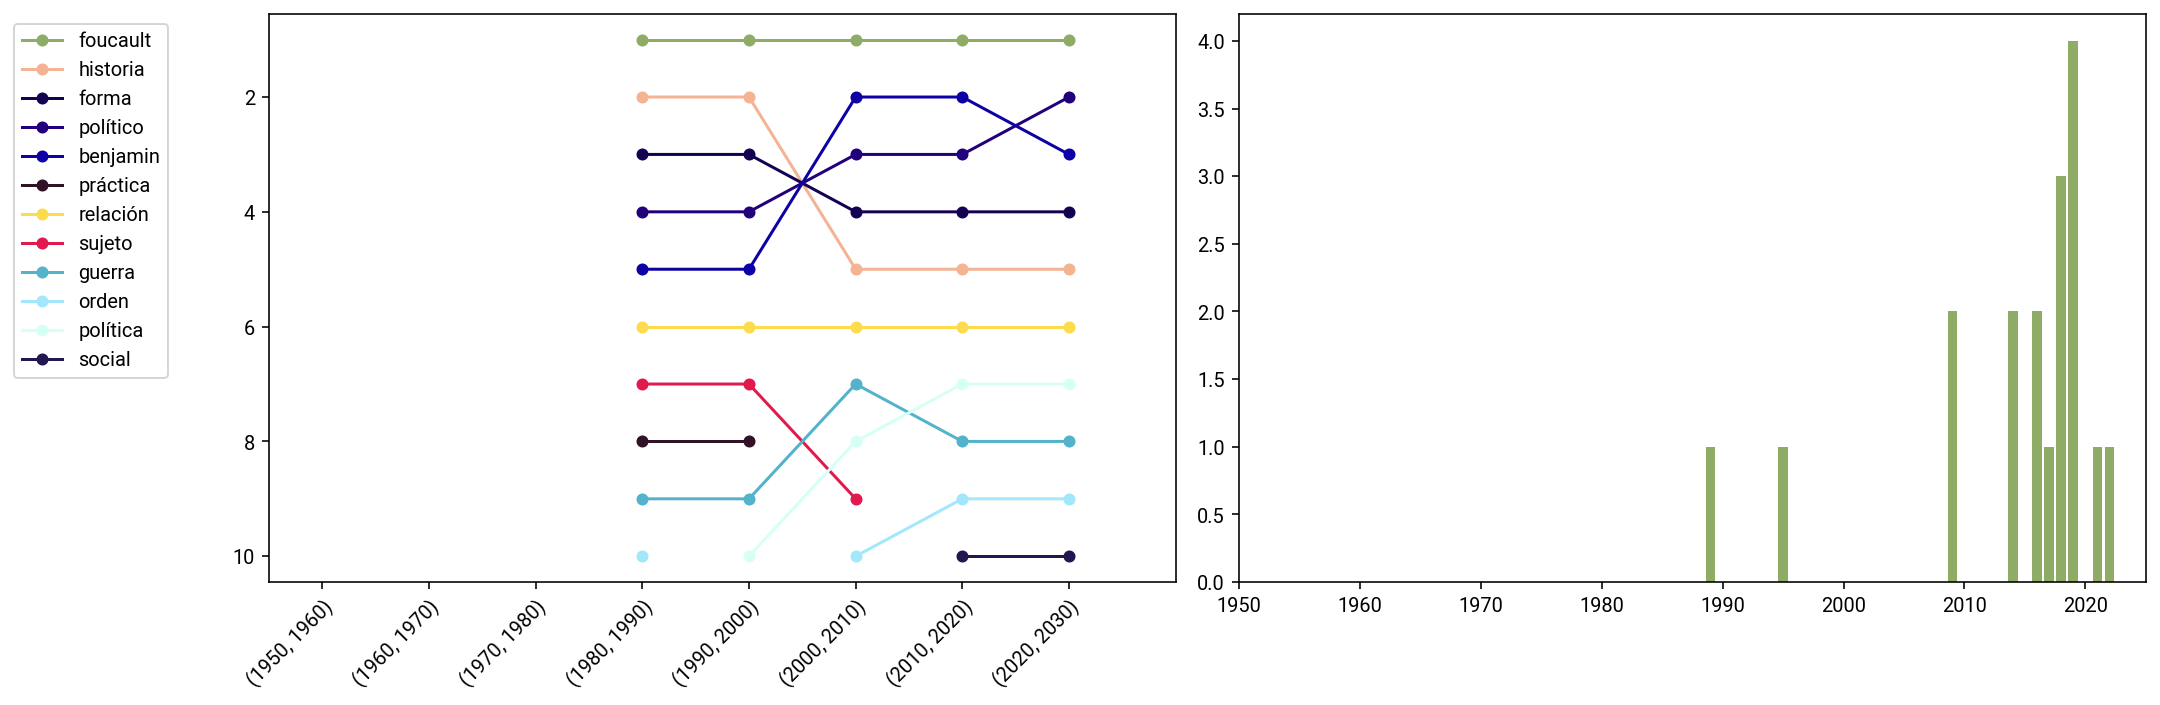

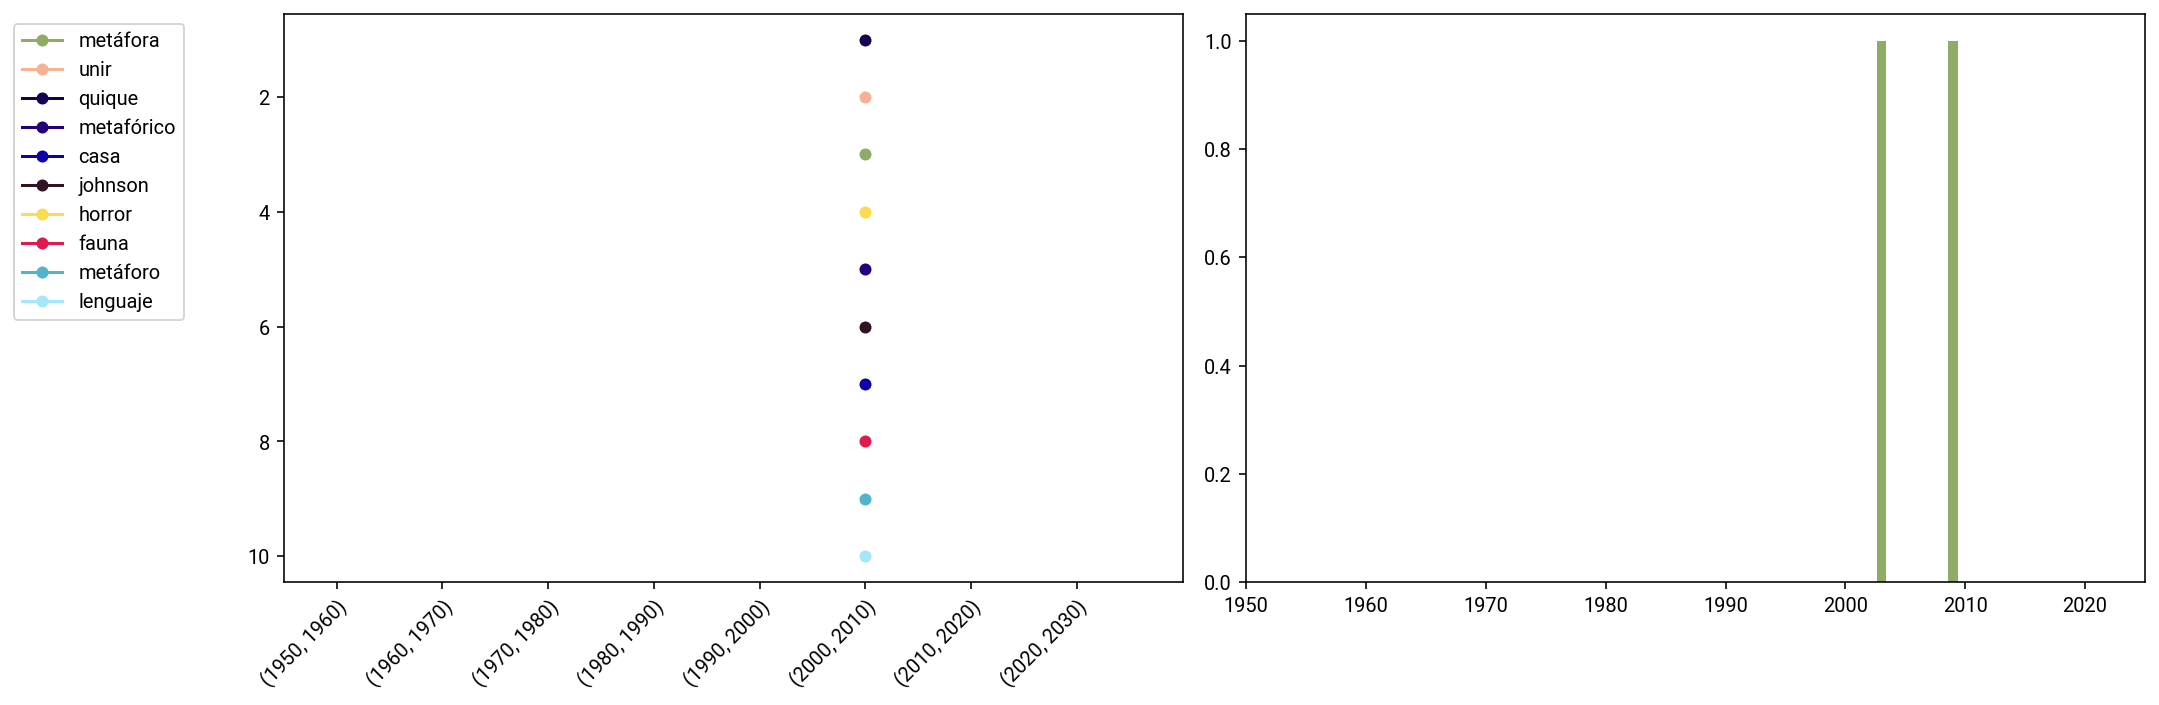

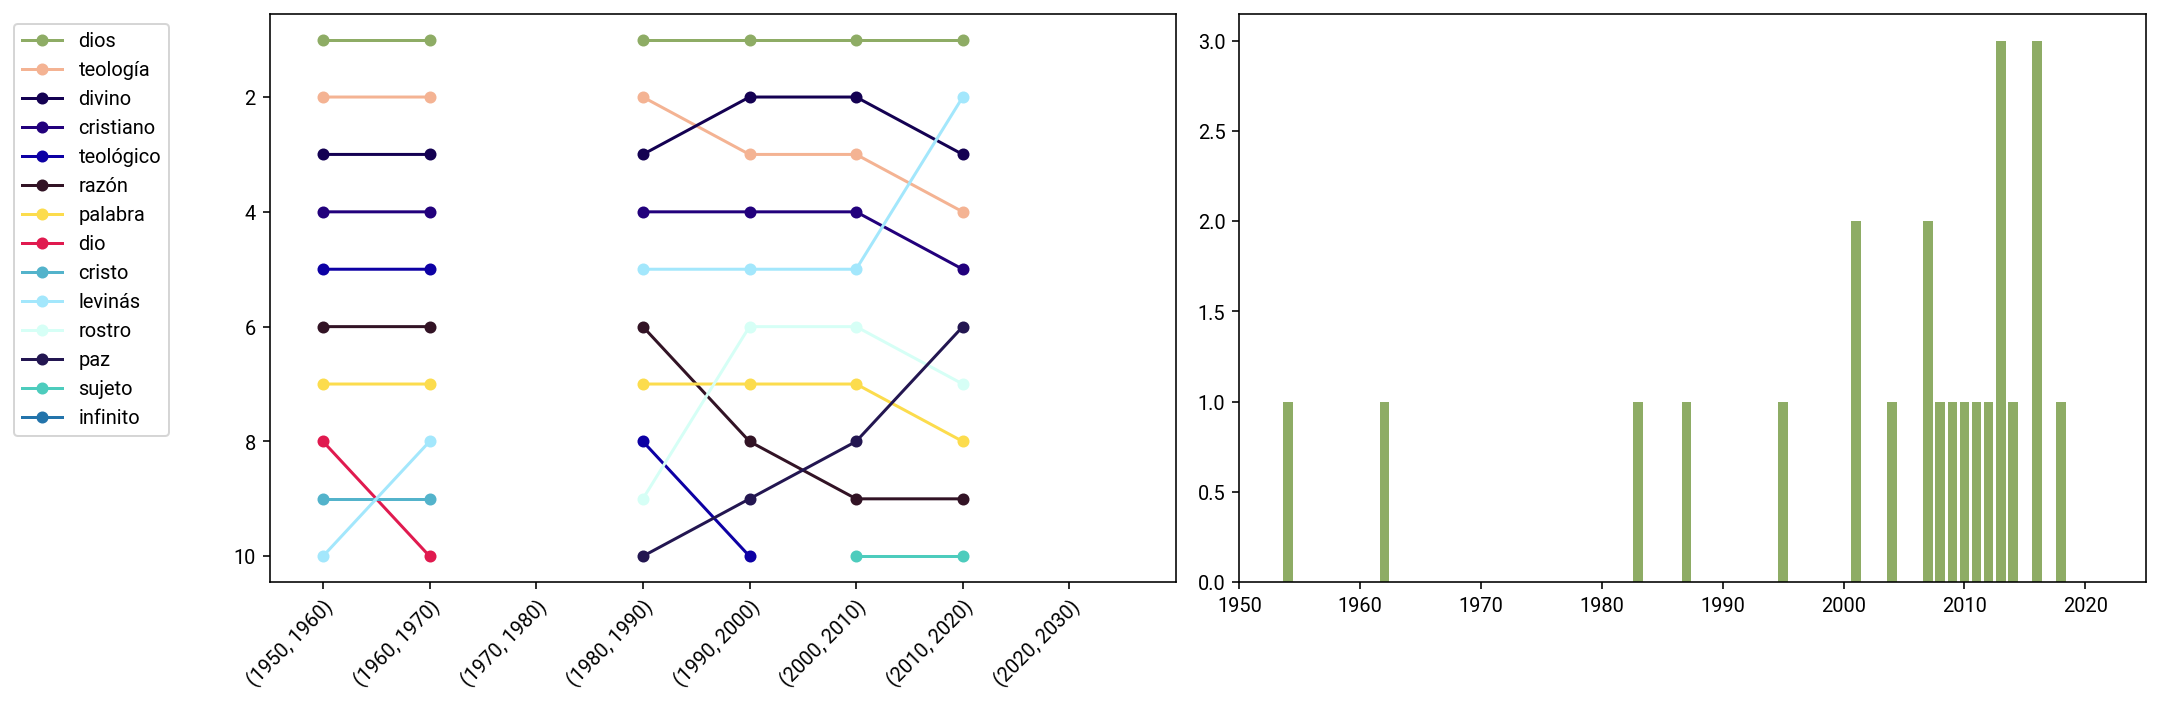

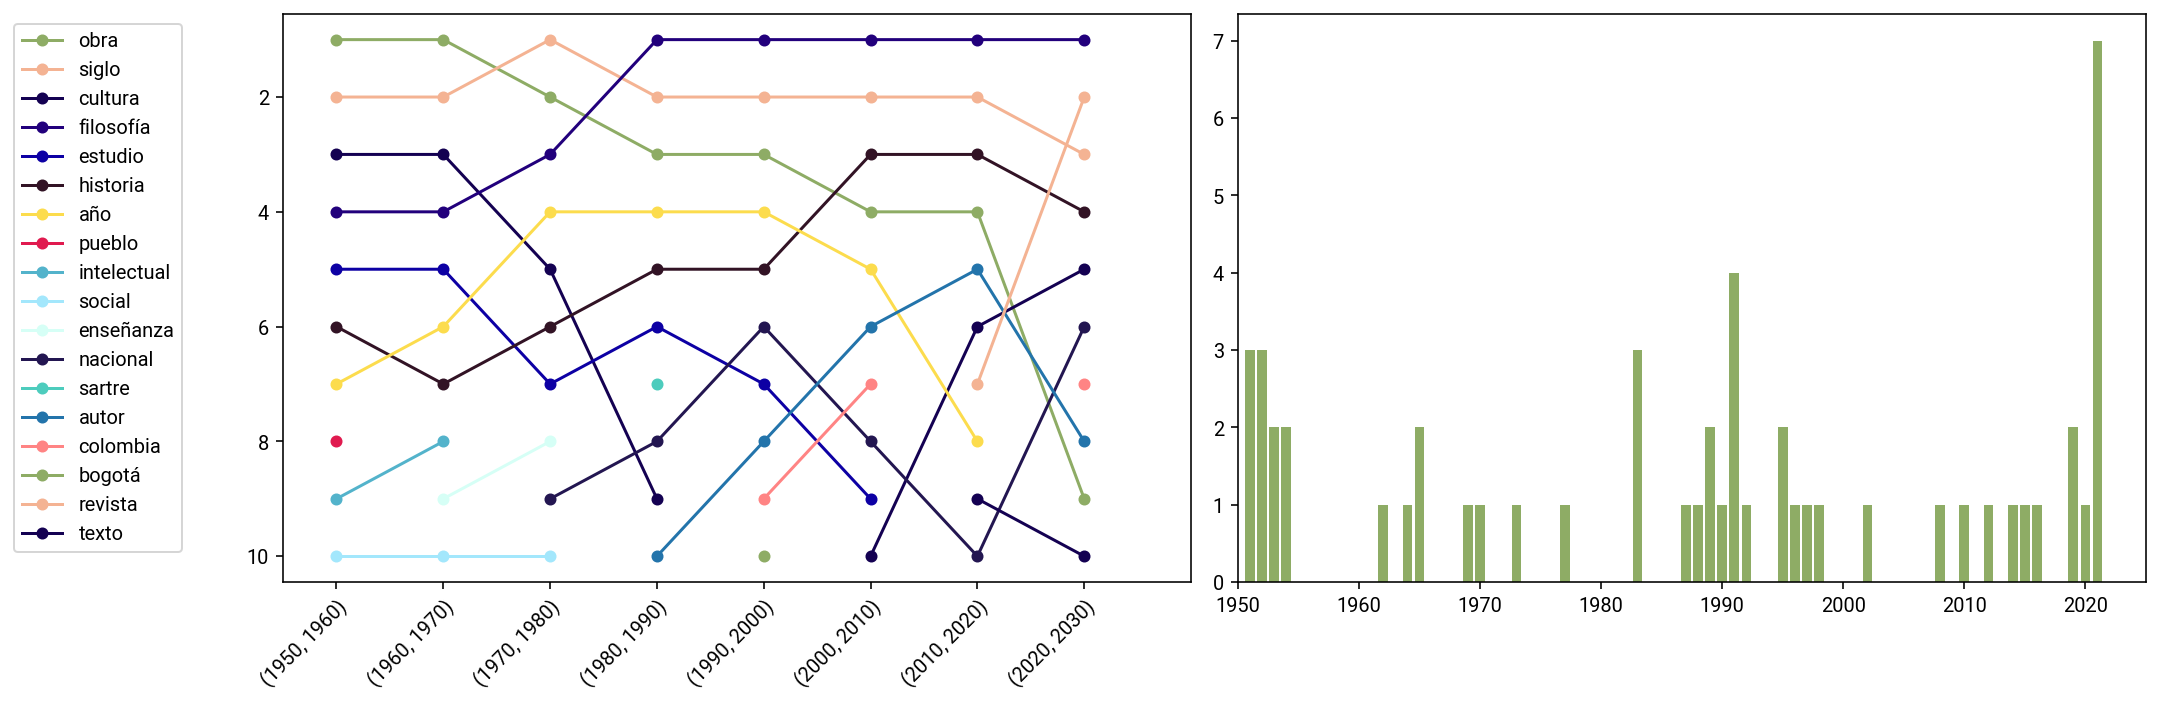

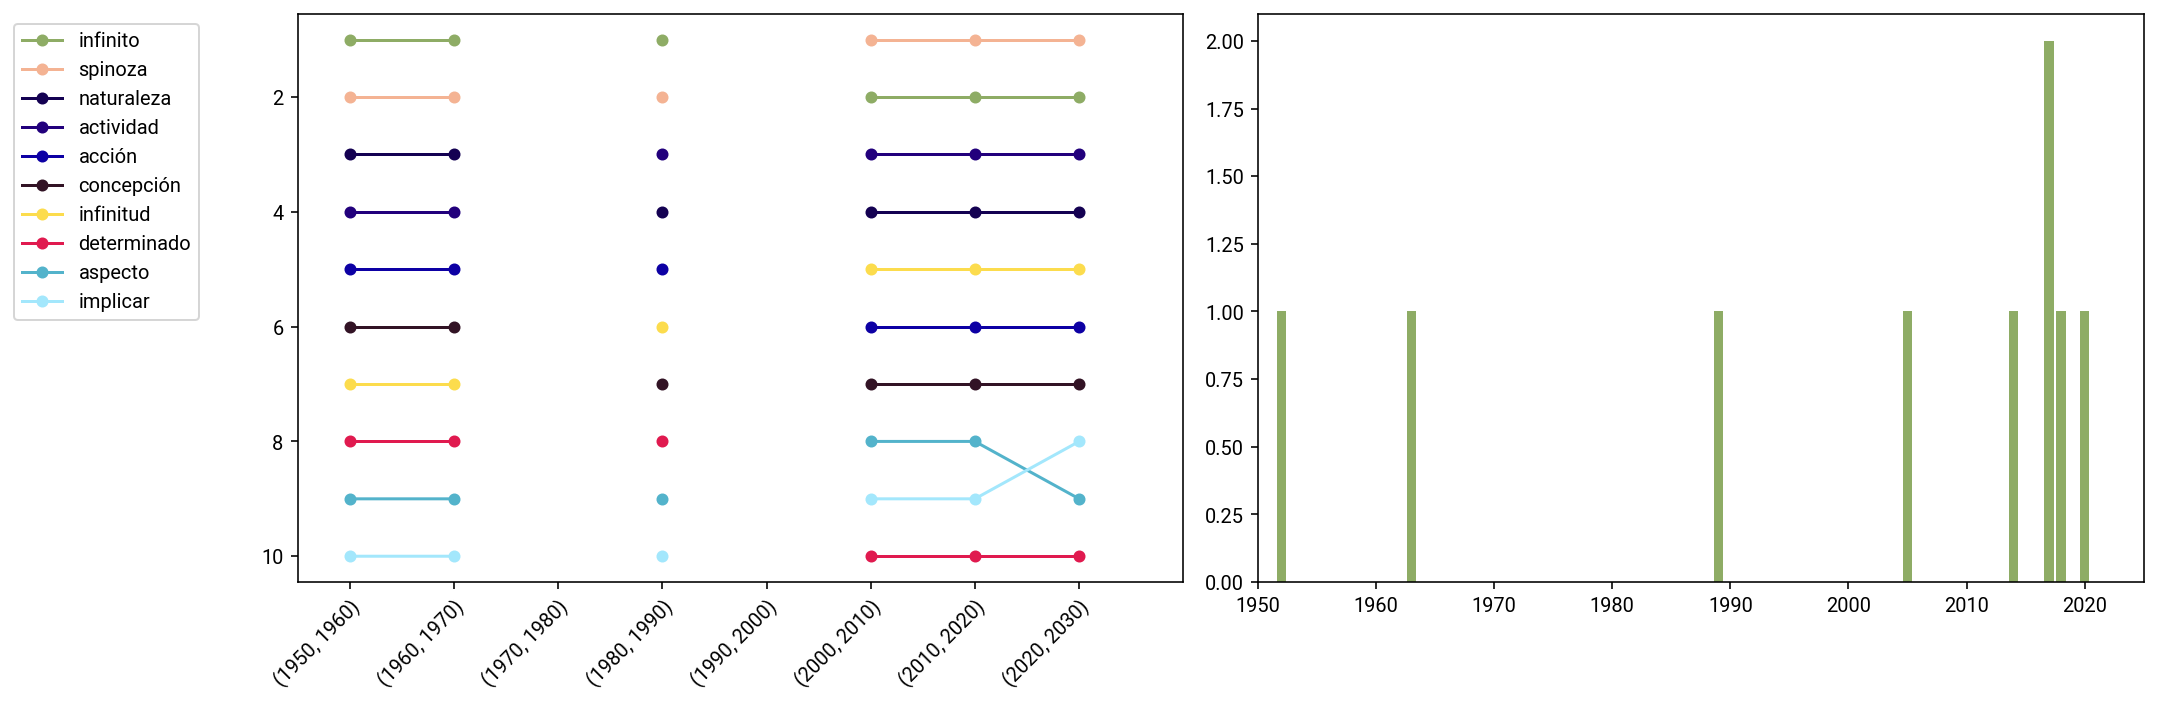

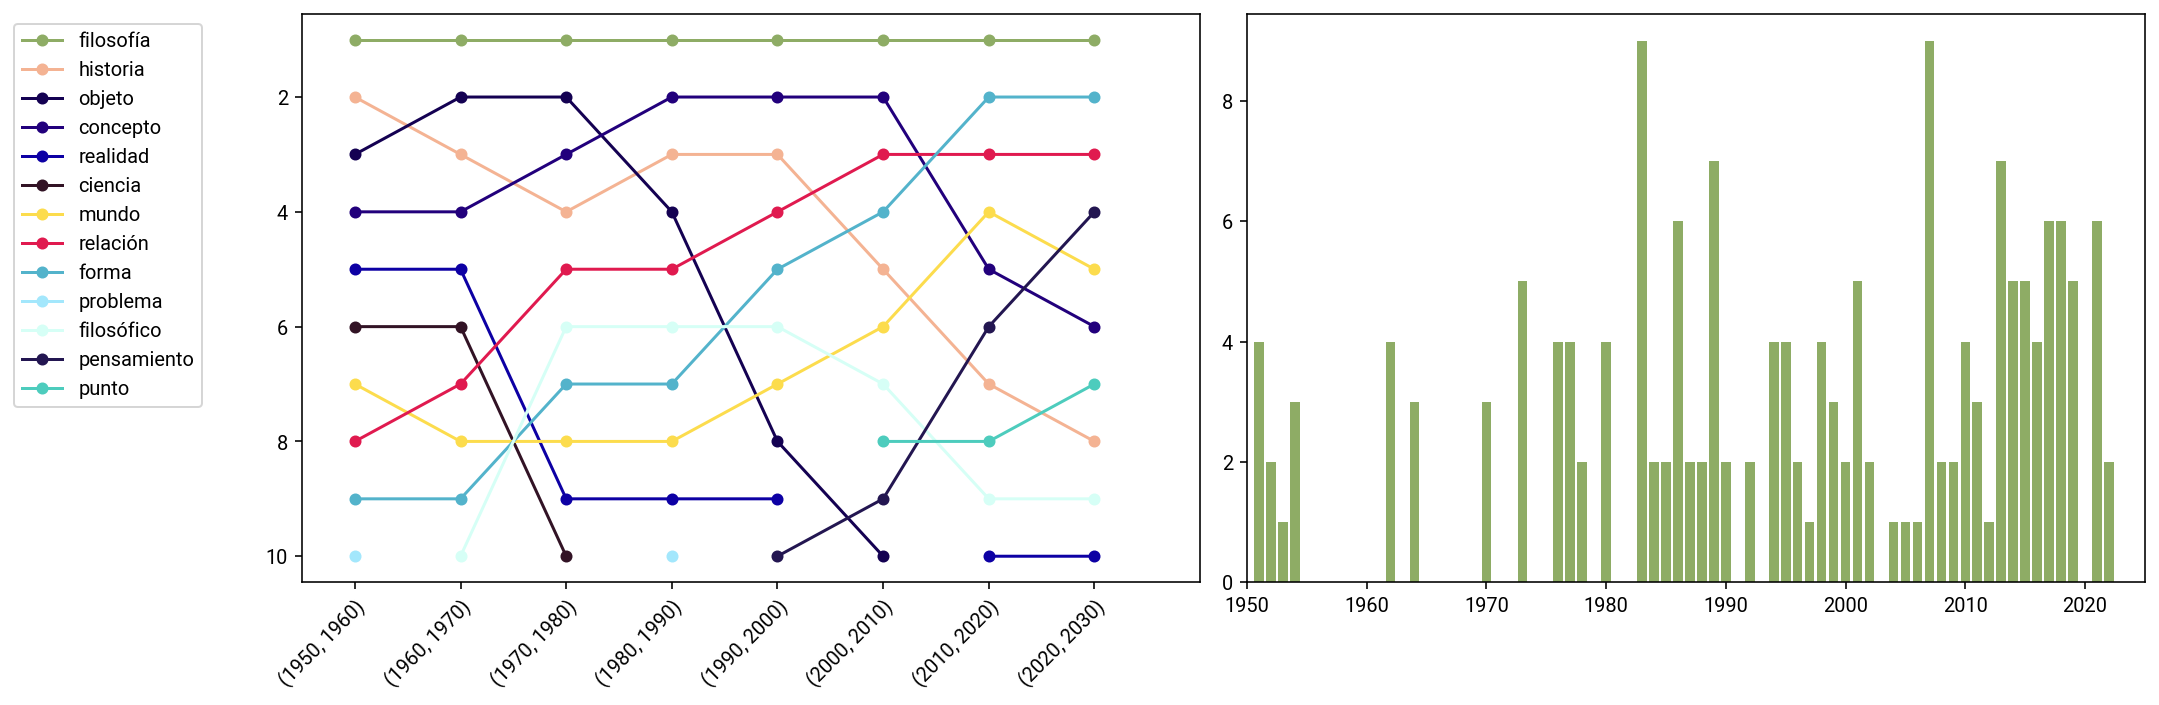

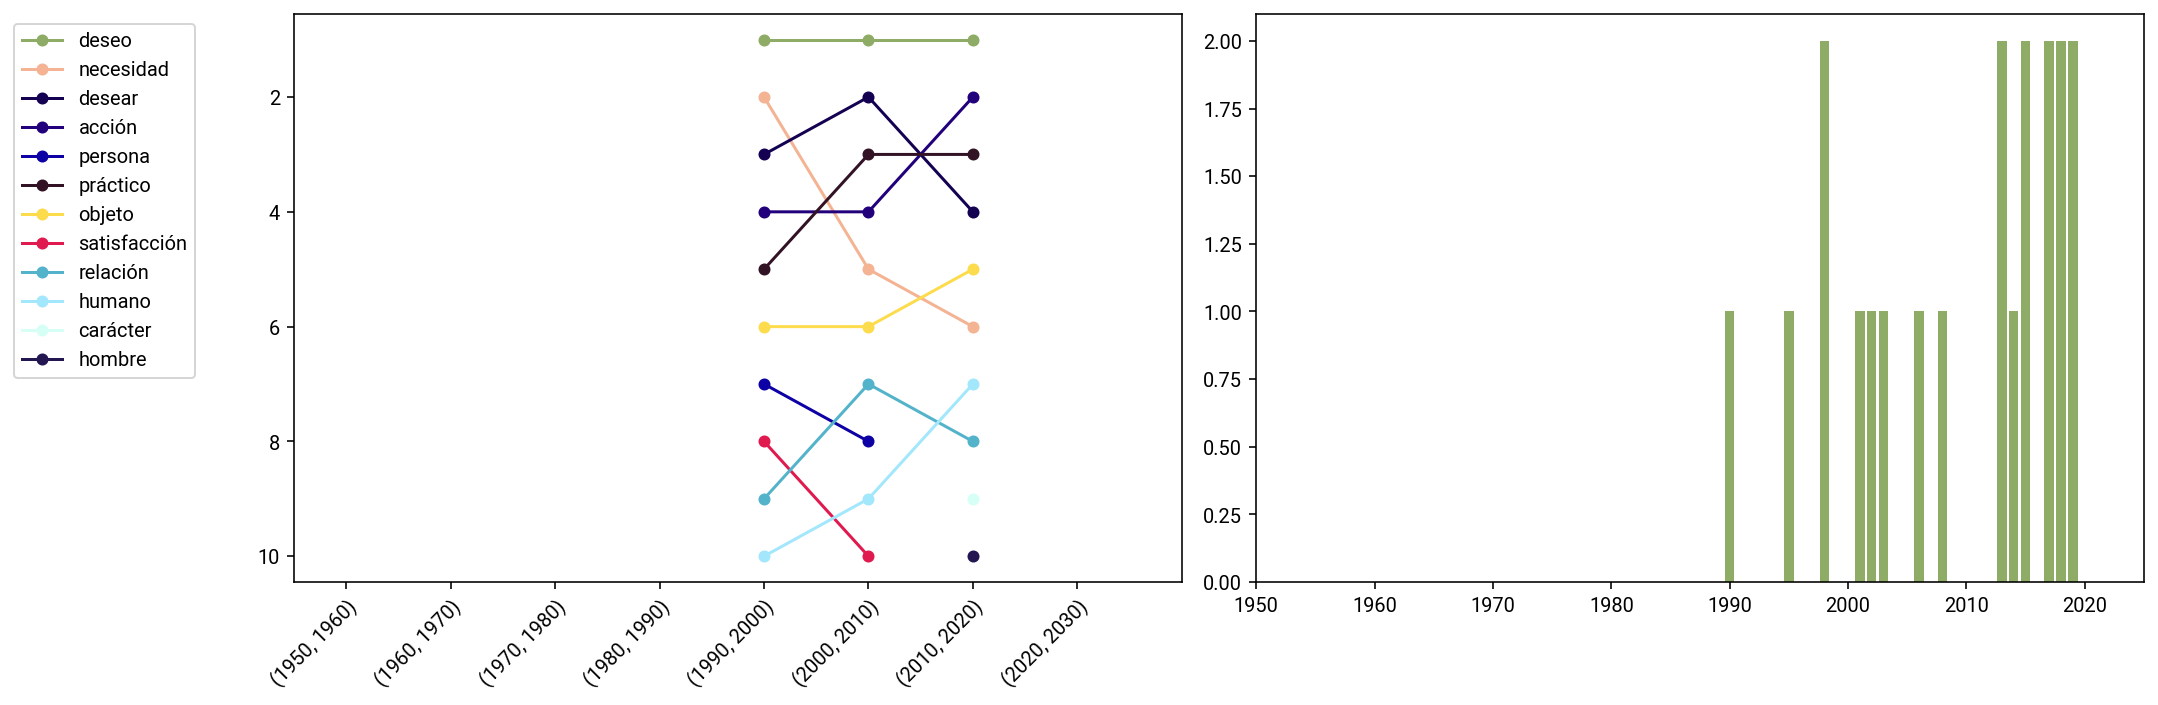

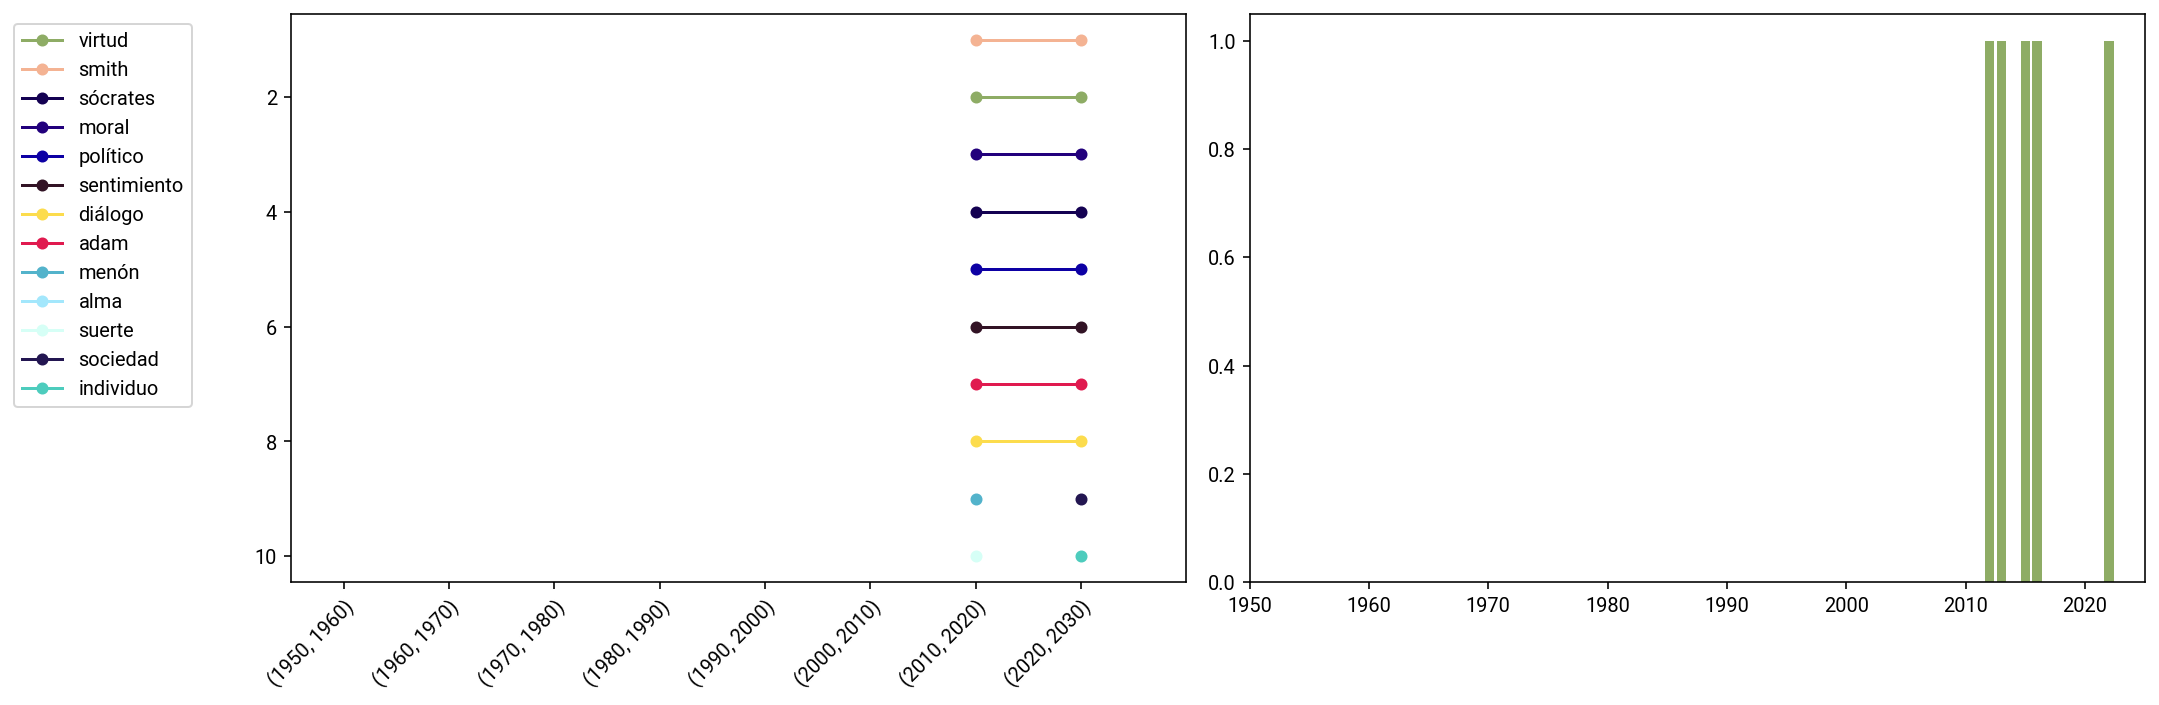

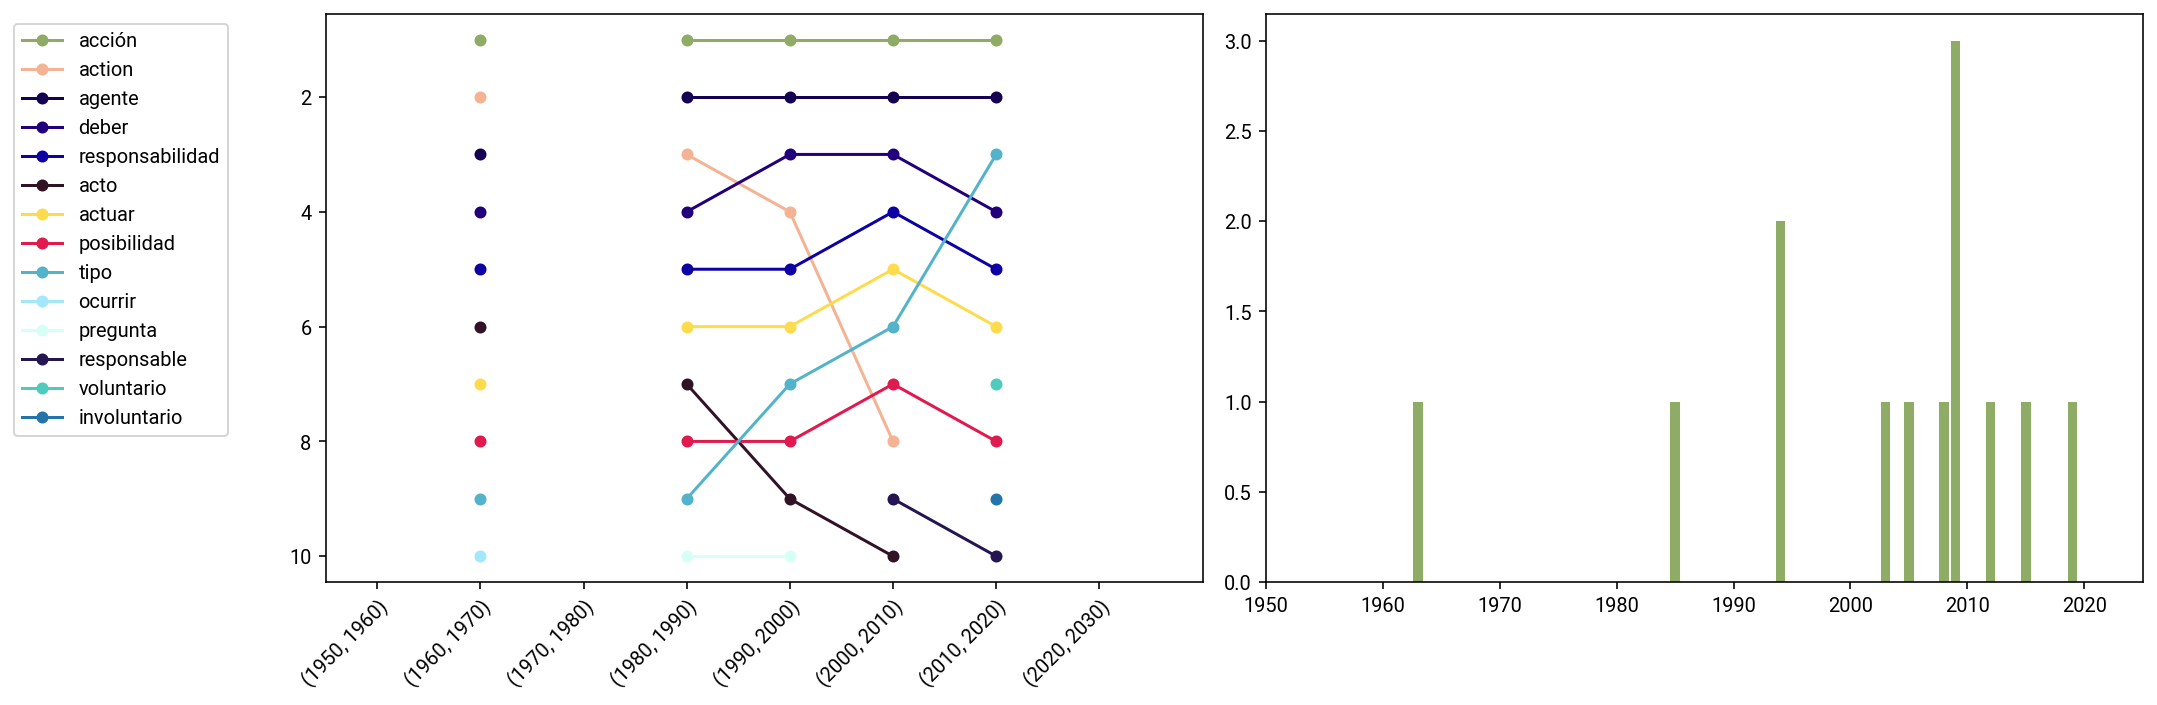

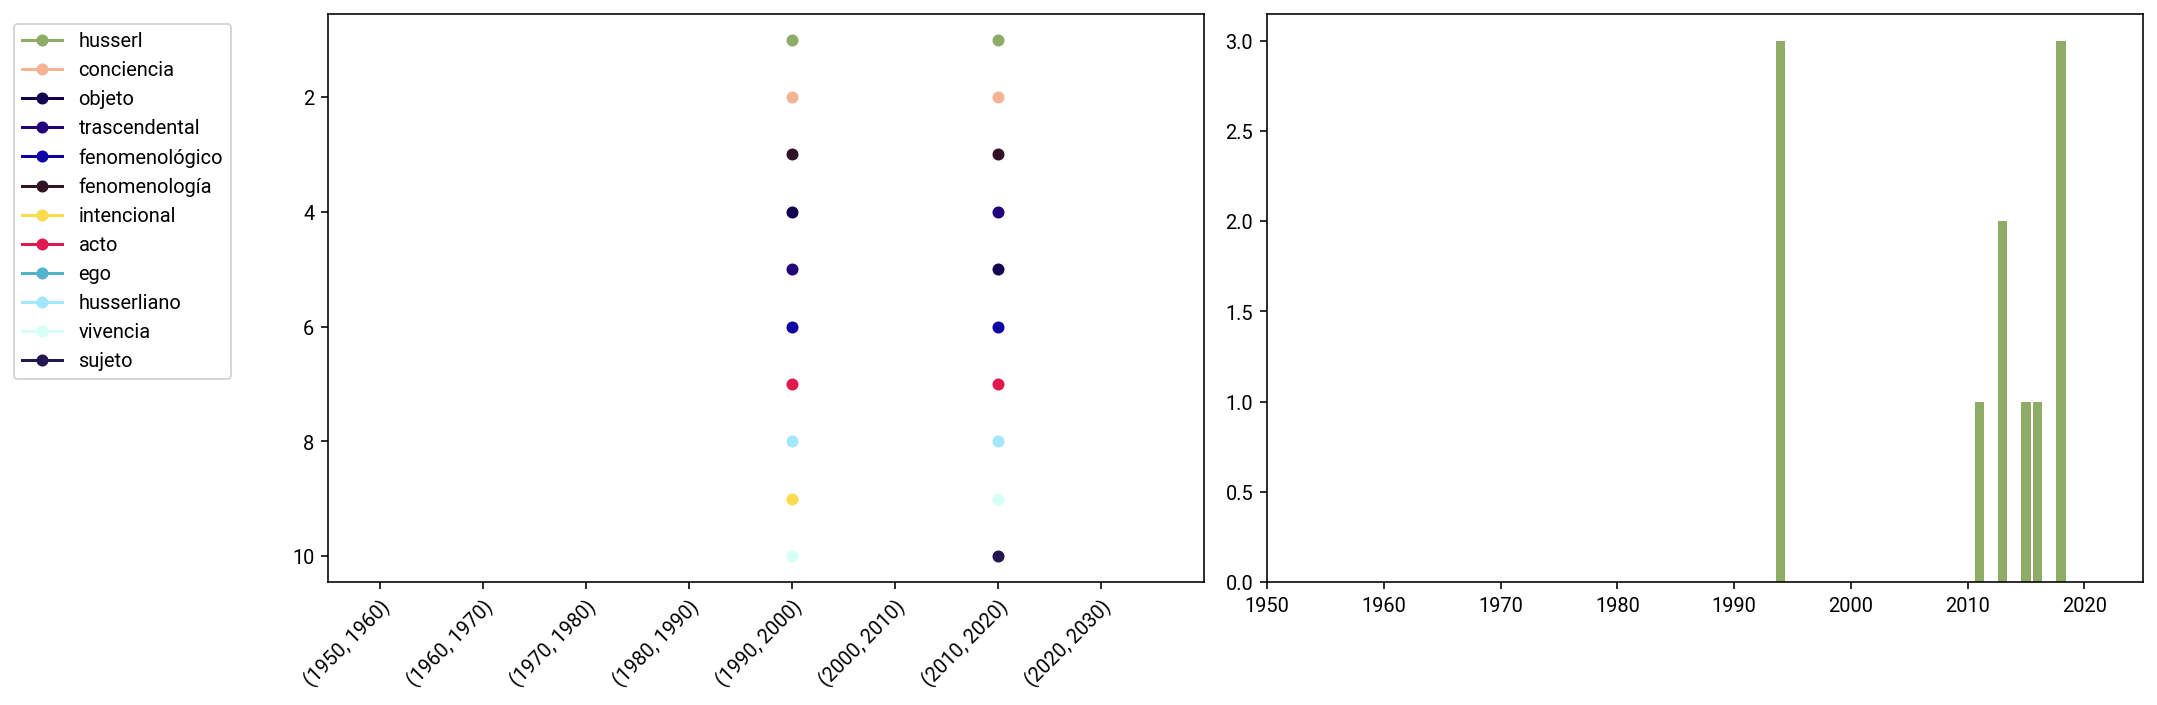

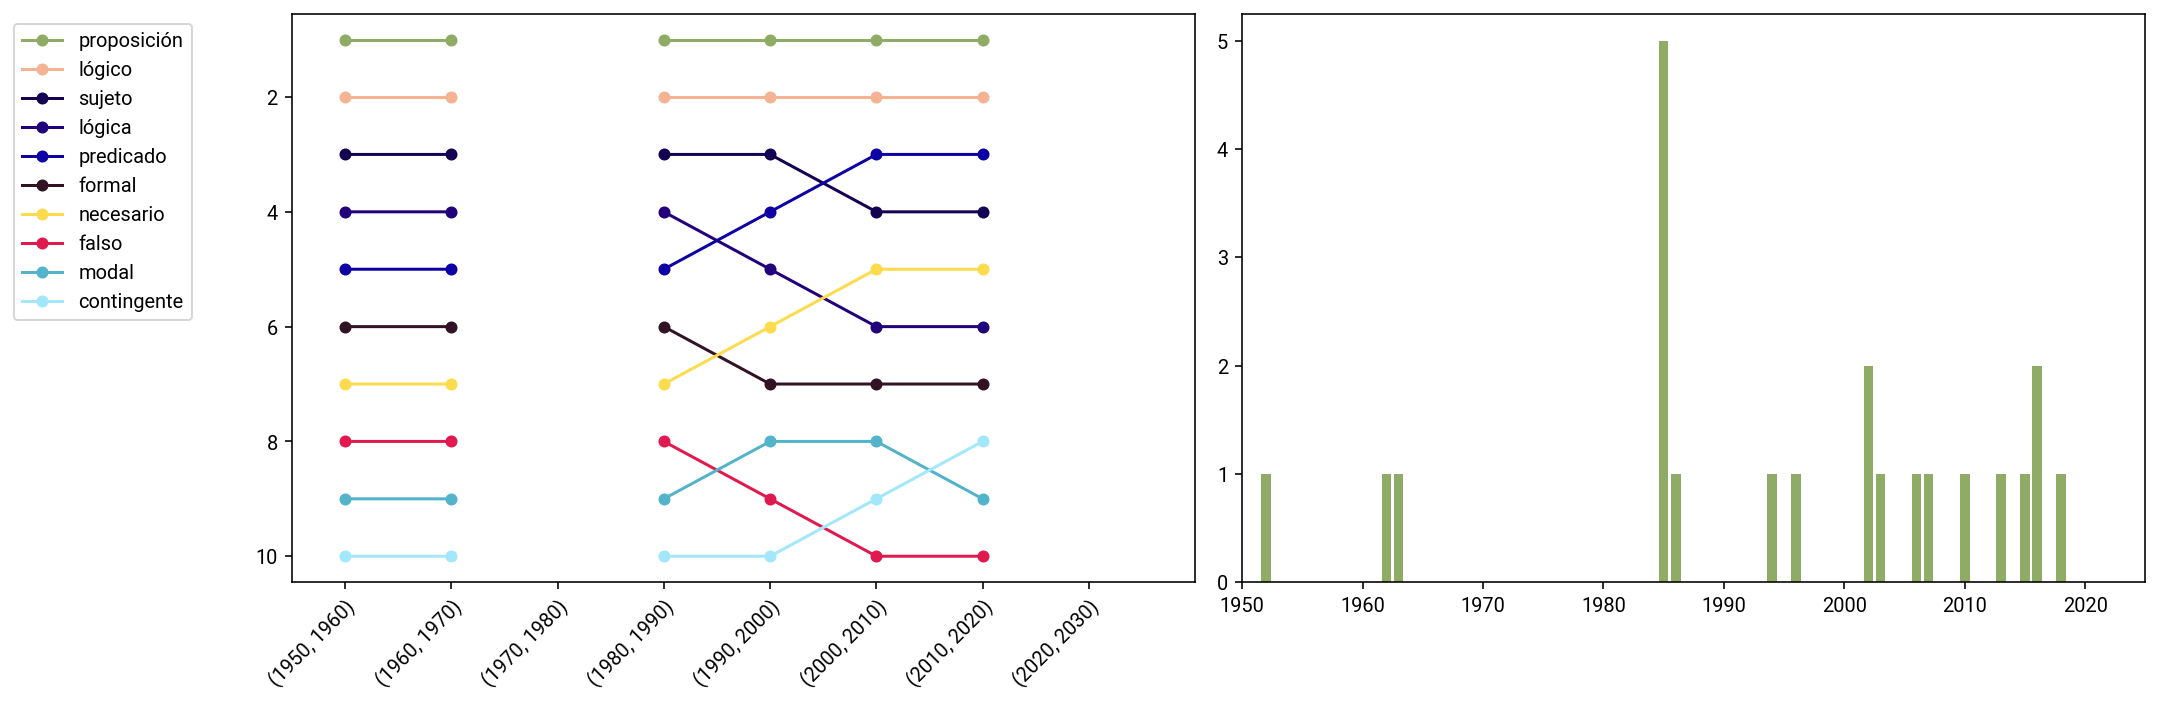

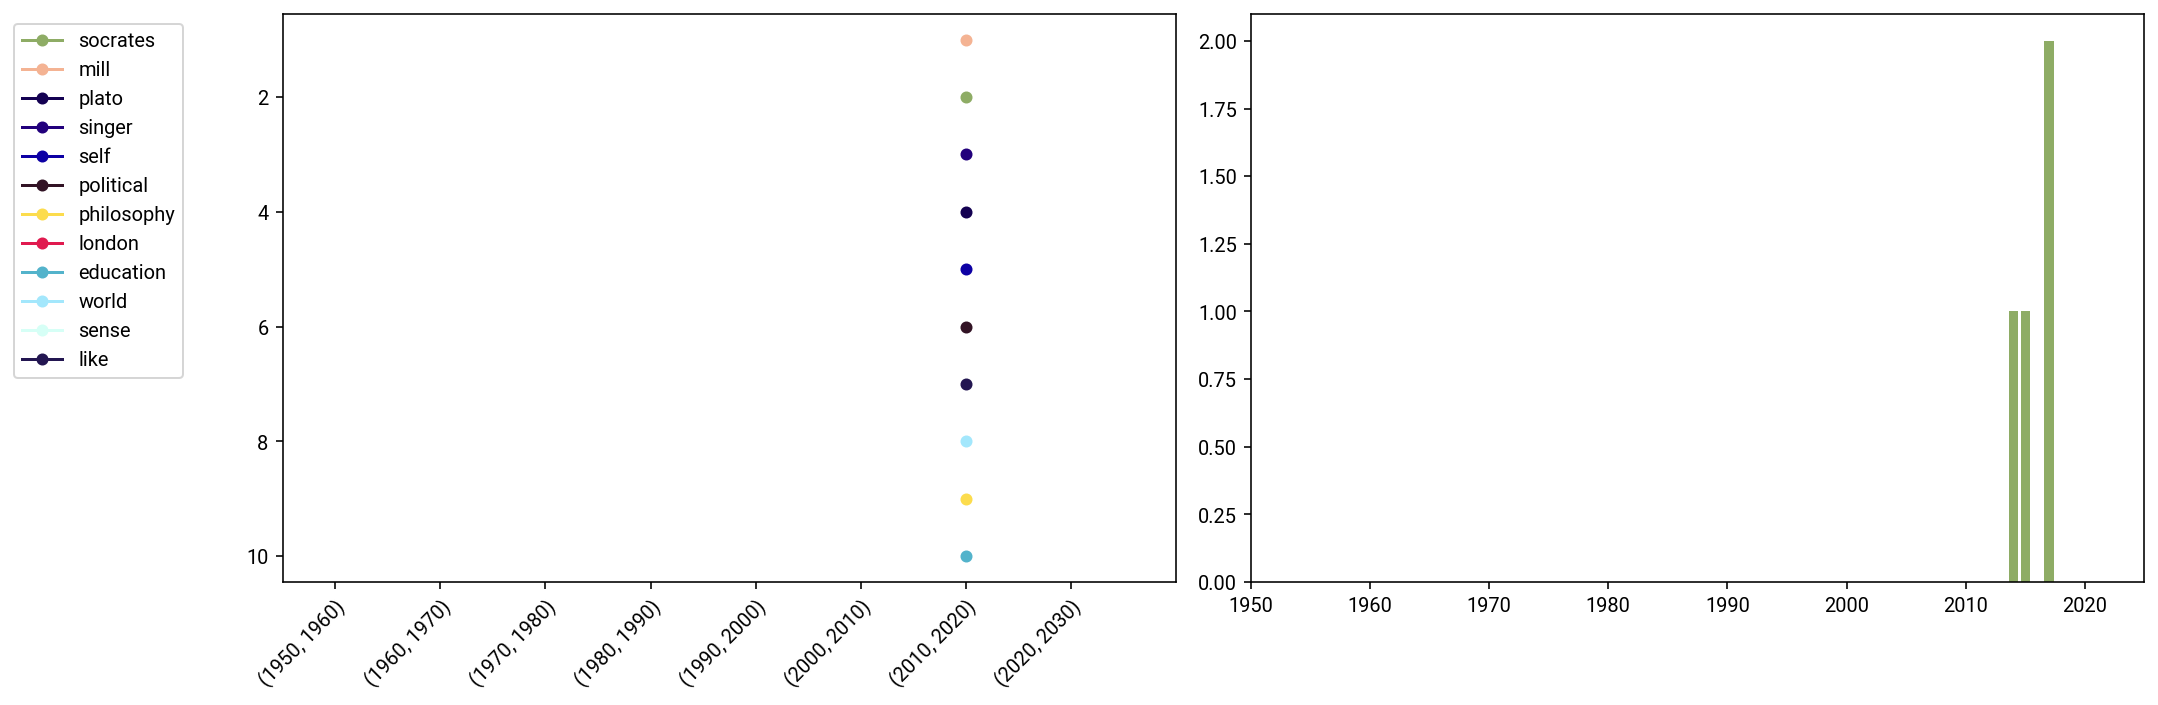

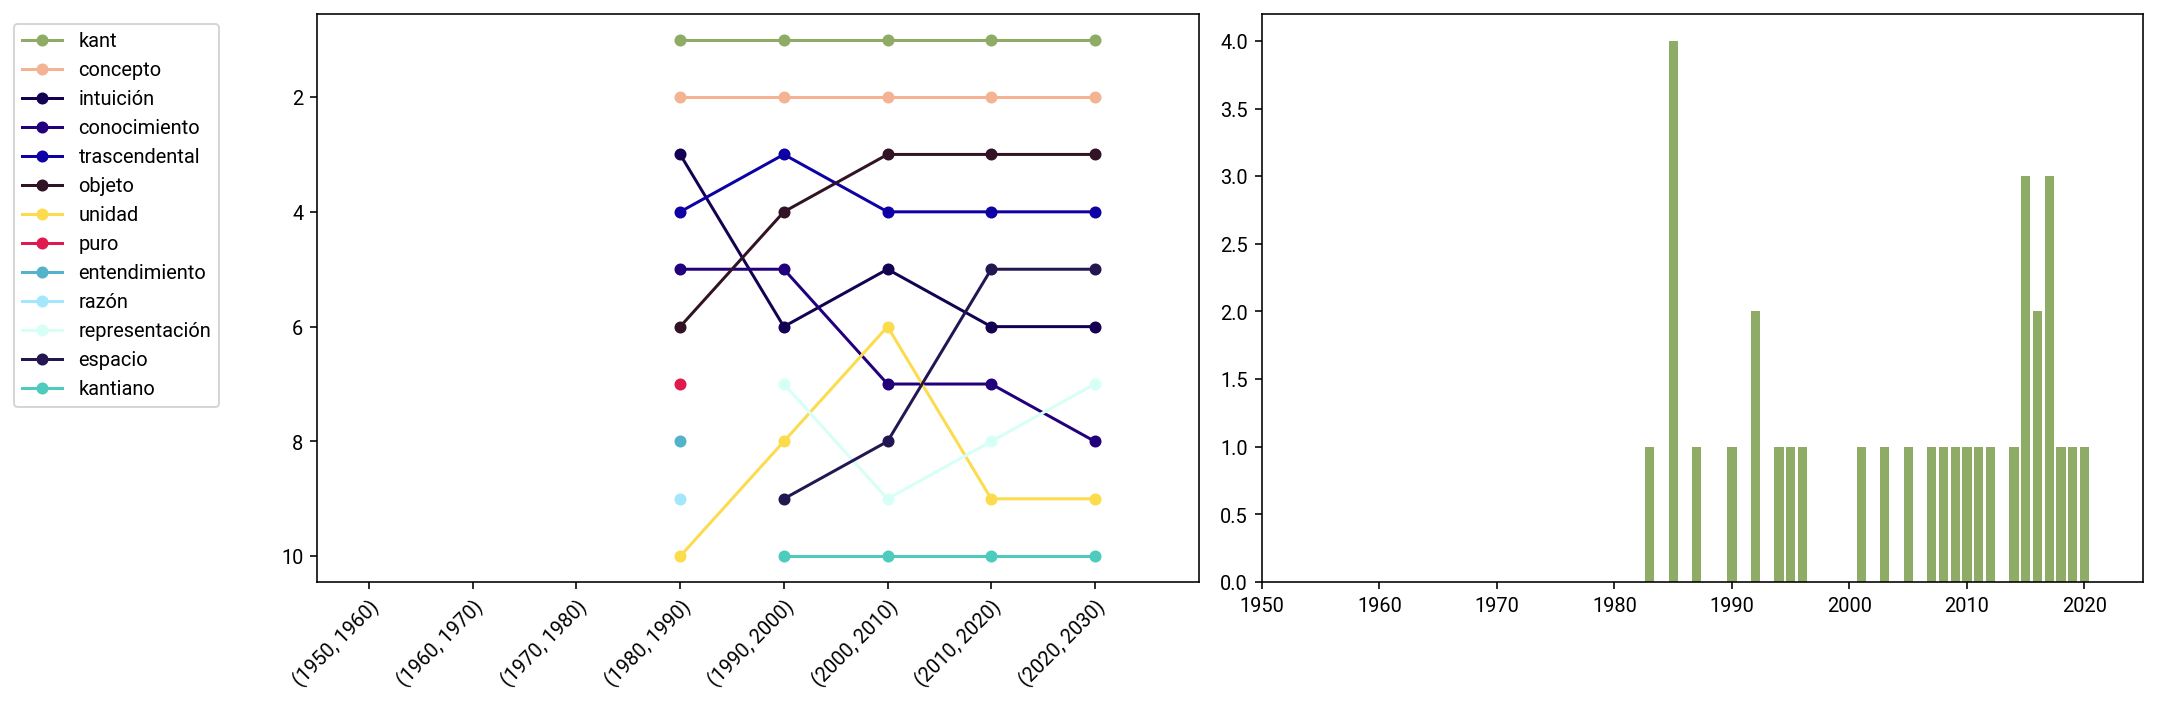

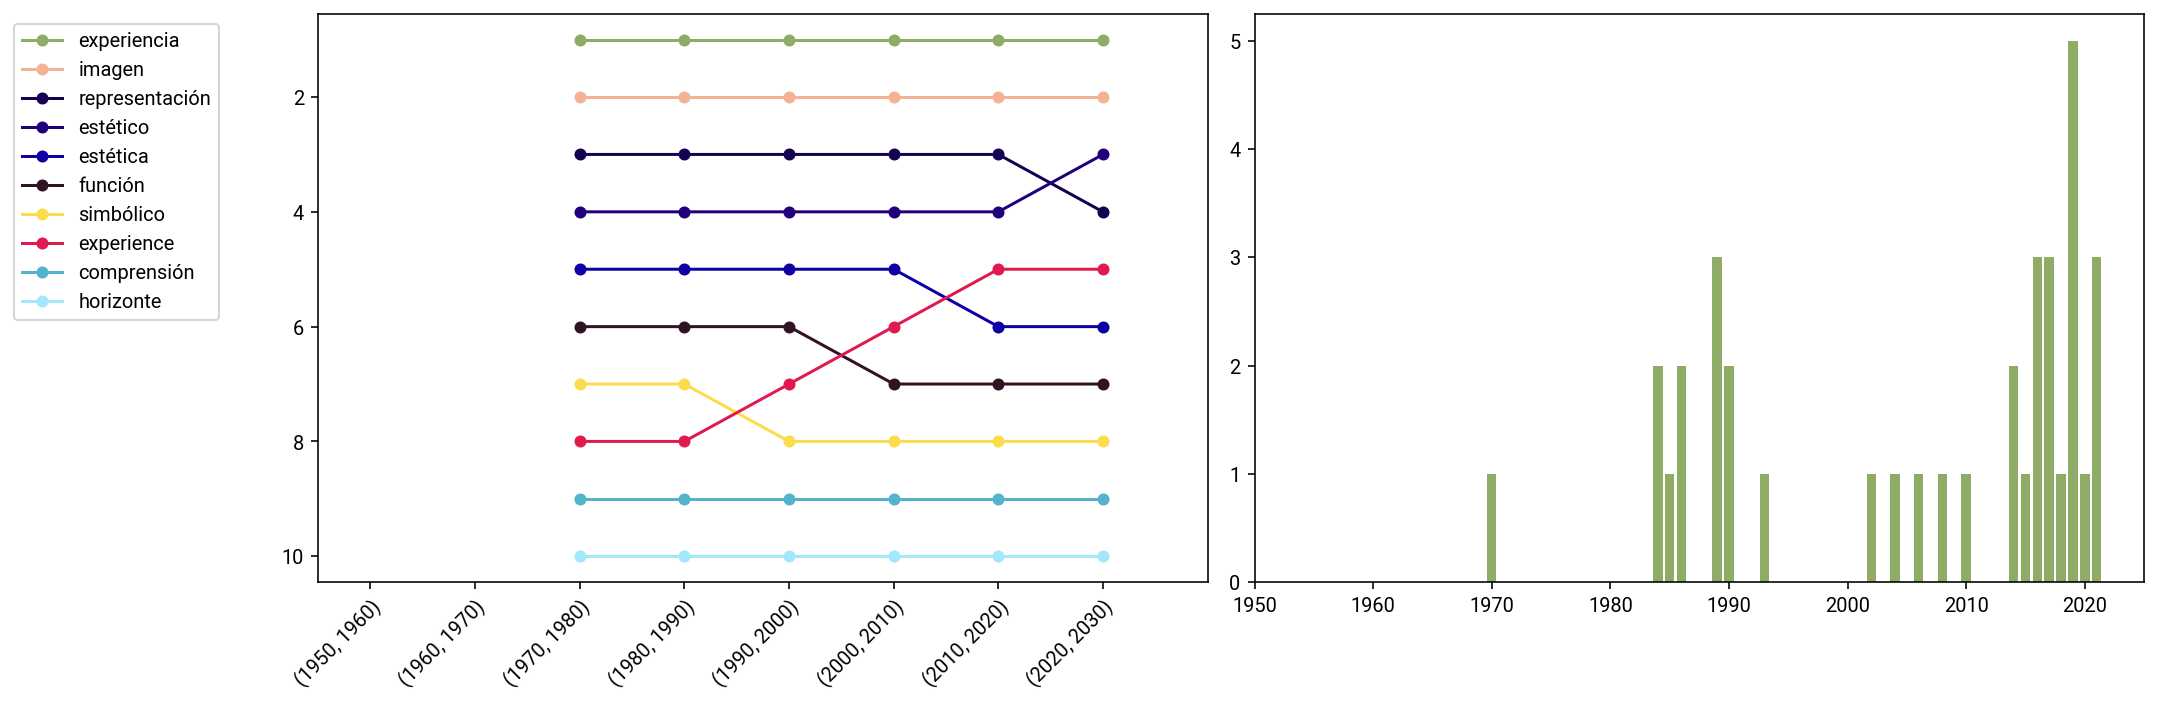

In [42]:
for topic in model.topics:
    if topic.is_trash:
        continue
    
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=144)

    topic_id = topic.topic_id
    viz.plot_word_evolution_by_topic_graph(topic_id, ax=ax1)
    viz.plot_number_of_documents_per_year_in_topic(topic_id, ax = ax2)
    ax1.legend(bbox_to_anchor=(-0.1, 1))

    _.tight_layout()

    _.savefig(TOPIC_PLOTS_FOLDER / f"{topic_id}.jpg")

In [ ]:
interesting_topics = [
    56, # Philosophy of science, stable
    58, # Moral philosophy
    60, # Merleau-Ponty, recent interest
    70, # Foucault/Benjamin, recent interest in Benjamin
    73, # Phil of Religion, growing interest in Levinas
    11, # Wittgenstein, interest in religious aspects
    16, # Skepticism, very recent interest
    20, # Marx, declining interest
    31, # Kantian political philosophy
    32, # Feminism, growing interest
    40, # McDowell, growing interest
    41, # Hermeneutics, growing interest in Ricoeur
    54, # Moral philosophy, stable, shift away from Kantian ethics
]

In [ ]:
from IPython.display import Markdown
for main_area in model.get_main_areas().keys():
    print(f"# {main_area}")
    print(model.compute_main_area_descriptor(main_area).mean(axis=1).sort_values(ascending=False).head(10))
    print("\n")

# Value theory
moral          0.021352
principio      0.019351
experiencia    0.016057
vida           0.015813
hombre         0.013888
libertad       0.013350
juicio         0.012853
humano         0.010545
acción         0.010136
razón          0.009080
dtype: float64


# History of western philosophy
rorty          0.031117
fichte         0.016177
infinito       0.012677
hegel          0.010661
spinoza        0.009582
pensar         0.009580
kant           0.009469
husserl        0.009096
objeto         0.008074
pensamiento    0.007529
dtype: float64


# Science, logic, and mathematics
priori          0.035360
ciencia         0.027812
proposición     0.021297
lógico          0.016884
conocimiento    0.016493
cassirer        0.015599
teoría          0.014219
sistema         0.013373
científico      0.011900
geometría       0.010944
dtype: float64


# Philosophical traditions
educación      0.032966
analogía       0.029317
analítico      0.016408
sujeto         0.015425
analógico      